# Group 004 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [24]:
!mkdir data
!kaggle datasets download mrdaniilak/russia-real-estate-20182021
!mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

mkdir: data: File exists
100%|████████████████████████████████████████| 111M/111M [00:18<00:00, 8.43MB/s]
100%|████████████████████████████████████████| 111M/111M [00:18<00:00, 6.39MB/s]


In [25]:
import zipfile
with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [28]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
5188292,9200000,2021-03-19,17:59:49,44.676576,37.778292,2843,3,17,20,3,99.60,16.0,1
2198519,900000,2019-07-12,21:13:35,58.053616,63.692800,6171,3,1,5,2,50.20,9.0,1
1770949,4300000,2019-05-11,08:16:36,55.002518,83.011314,9654,3,1,10,3,70.30,11.3,1
3761477,2850000,2020-05-21,09:00:23,57.586661,39.900910,2604,2,5,17,2,60.00,12.0,11
425313,1650000,2018-11-06,12:40:20,54.944094,82.968391,9654,1,8,18,2,56.14,7.0,11


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [29]:
MOSCOW_CODE = 81

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]

In [30]:
moscow_df.isnull().values.any()

False

In [31]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
2785877,1669000,2019,brick,2,5,1,31.0,6.0,preowned
2740222,2750000,2019,brick,2,2,2,47.2,7.4,preowned
1179131,5850000,2019,monolithic,2,17,2,73.0,13.0,preowned
3038789,4750000,2019,monolithic,2,25,1,57.0,9.0,preowned
841069,3620000,2018,brick,2,9,2,39.7,5.6,preowned


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [32]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,5.001920e+05,500192.000000,500192.00000,500192.000000,500192.000000,500192.000000,500192.000000
mean,4.765453e+06,2019.310803,7.05152,12.741489,1.782240,51.734531,10.364580
std,4.208466e+06,0.880217,5.71243,7.391100,0.864063,25.727061,7.177274
min,0.000000e+00,2018.000000,1.00000,1.000000,0.000000,1.000000,0.050000
25%,3.000000e+06,2019.000000,3.00000,5.000000,1.000000,38.000000,7.000000
50%,4.300000e+06,2019.000000,5.00000,12.000000,2.000000,46.200000,9.600000
75%,5.950000e+06,2020.000000,10.00000,17.000000,2.000000,62.000000,12.000000
max,2.147484e+09,2021.000000,36.00000,39.000000,9.000000,5000.000000,3000.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

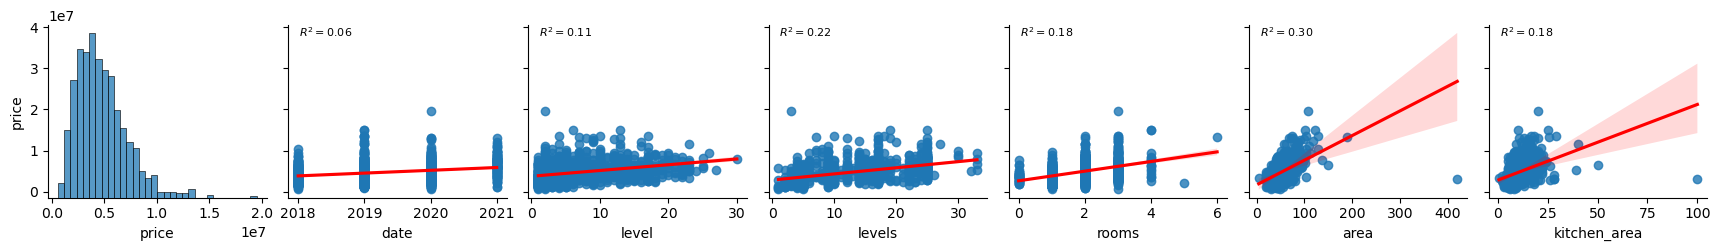

In [33]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like te might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

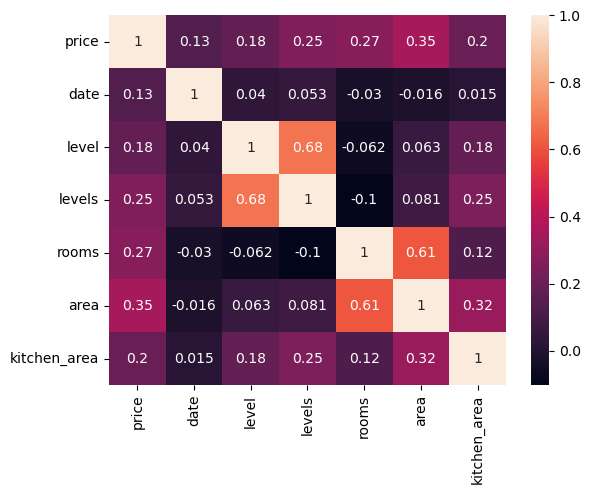

In [34]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)
plt.show()

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [35]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

350134 train samples; 150058 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [36]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
5137091,2021,5,5,1,40.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
101148,2018,9,10,5,113.8,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1314818,2019,15,24,3,74.5,15.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4953797,2021,1,4,0,23.5,3.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4065253,2020,6,17,1,39.8,10.1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [37]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
3189062,0.783197,-0.184174,-0.775935,-0.905443,-0.452069,-0.229652,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2178954,-0.353996,-0.009107,1.523448,0.252737,-0.024270,-0.043110,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3230842,0.783197,-0.184174,0.306128,-0.905443,-0.374988,0.109516,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3964179,0.783197,-0.709375,-0.640677,-2.063624,-1.222878,-1.416741,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5432214,1.920389,-0.534308,-1.046451,-0.905443,-0.721852,-0.399236,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [50]:
MAX_EPOCHS = 10000

### Linear Regression

Note that SckiKit doesn't offer MAE loss for its `LinearRegression` implementation. However, `linear_model.SGDRegressor` can be made to use an MAE loss by using `epsilon_insensitive` loss and setting its $\epsilon$ hyperparam to $0$.

Note that this does mean we will be using SGD for descent, so our model will take more steps to converge and loss won't strcitly decrease, but in our case using SGD will actually be helpful since our dataset is relatively large, so each epoch will be much faster.

In [51]:
from sklearn.linear_model import SGDRegressor

linreg_mae_model = SGDRegressor(loss='epsilon_insensitive', epsilon=0, max_iter=MAX_EPOCHS, verbose=1)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

linreg_mae_model.fit(X_train_scaled, y_train)

linreg_mae_train_preds = linreg_mae_model.predict(X_train_scaled)
linreg_mae_test_preds = linreg_mae_model.predict(X_test_scaled)

linreg_mae_train_mae = mean_absolute_error(y_train, linreg_mae_train_preds)
linreg_mae_test_mae = mean_absolute_error(y_test, linreg_mae_test_preds)

linreg_mae_train_mse = mean_squared_error(y_train, linreg_mae_train_preds)
linreg_mae_test_mse = mean_squared_error(y_test, linreg_mae_test_preds)

linreg_mae_train_rmse = np.sqrt(linreg_mae_train_mse)
linreg_mae_test_rmse = np.sqrt(linreg_mae_test_mse)

print(f'Linear Regression MAE train error: {linreg_mae_train_mae}, test error: {linreg_mae_test_mae}')
print(f'Linear Regression MSE train error: {linreg_mae_train_mse}, test error: {linreg_mae_test_mse}')
print(f'Linear Regression RMSE train error: {linreg_mae_train_rmse}, test error: {linreg_mae_test_rmse}')

-- Epoch 1
Norm: 185.21, NNZs: 14, Bias: 191.907386, T: 350134, Avg. loss: 4764456.900927
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 309.47, NNZs: 14, Bias: 322.753765, T: 700268, Avg. loss: 4764167.917379
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 417.07, NNZs: 14, Bias: 437.464253, T: 1050402, Avg. loss: 4763933.953684
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 514.81, NNZs: 14, Bias: 542.810370, T: 1400536, Avg. loss: 4763724.546629
Total training time: 0.29 seconds.
-- Epoch 5
Norm: 605.63, NNZs: 14, Bias: 641.698815, T: 1750670, Avg. loss: 4763530.907181
Total training time: 0.37 seconds.
-- Epoch 6
Norm: 691.15, NNZs: 14, Bias: 735.727421, T: 2100804, Avg. loss: 4763348.744133
Total training time: 0.44 seconds.
-- Epoch 7
Norm: 772.42, NNZs: 14, Bias: 825.896800, T: 2450938, Avg. loss: 4763175.527475
Total training time: 0.52 seconds.
-- Epoch 8
Norm: 850.13, NNZs: 14, Bias: 912.890187, T: 2801072, Avg. loss: 4763009.599603
Total training time: 0.60 sec

Norm: 3495.22, NNZs: 14, Bias: 4443.035411, T: 23108844, Avg. loss: 4756863.479790
Total training time: 4.84 seconds.
-- Epoch 67
Norm: 3526.61, NNZs: 14, Bias: 4493.420015, T: 23458978, Avg. loss: 4756782.305491
Total training time: 4.92 seconds.
-- Epoch 68
Norm: 3557.74, NNZs: 14, Bias: 4543.616681, T: 23809112, Avg. loss: 4756701.587061
Total training time: 4.99 seconds.
-- Epoch 69
Norm: 3588.59, NNZs: 14, Bias: 4593.629133, T: 24159246, Avg. loss: 4756621.319109
Total training time: 5.07 seconds.
-- Epoch 70
Norm: 3619.18, NNZs: 14, Bias: 4643.460694, T: 24509380, Avg. loss: 4756541.495347
Total training time: 5.14 seconds.
-- Epoch 71
Norm: 3649.51, NNZs: 14, Bias: 4693.114602, T: 24859514, Avg. loss: 4756462.108000
Total training time: 5.21 seconds.
-- Epoch 72
Norm: 3679.58, NNZs: 14, Bias: 4742.593971, T: 25209648, Avg. loss: 4756383.146461
Total training time: 5.28 seconds.
-- Epoch 73
Norm: 3709.40, NNZs: 14, Bias: 4791.901829, T: 25559782, Avg. loss: 4756304.601355
Total t

Norm: 5068.19, NNZs: 14, Bias: 7343.942511, T: 45167286, Avg. loss: 4752422.148256
Total training time: 9.60 seconds.
-- Epoch 130
Norm: 5088.08, NNZs: 14, Bias: 7386.592366, T: 45517420, Avg. loss: 4752360.046228
Total training time: 9.68 seconds.
-- Epoch 131
Norm: 5107.85, NNZs: 14, Bias: 7429.160279, T: 45867554, Avg. loss: 4752298.148017
Total training time: 9.76 seconds.
-- Epoch 132
Norm: 5127.49, NNZs: 14, Bias: 7471.647031, T: 46217688, Avg. loss: 4752236.447758
Total training time: 9.83 seconds.
-- Epoch 133
Norm: 5147.02, NNZs: 14, Bias: 7514.053393, T: 46567822, Avg. loss: 4752174.940265
Total training time: 9.92 seconds.
-- Epoch 134
Norm: 5166.43, NNZs: 14, Bias: 7556.380117, T: 46917956, Avg. loss: 4752113.639529
Total training time: 10.00 seconds.
-- Epoch 135
Norm: 5185.71, NNZs: 14, Bias: 7598.627944, T: 47268090, Avg. loss: 4752052.522231
Total training time: 10.09 seconds.
-- Epoch 136
Norm: 5204.88, NNZs: 14, Bias: 7640.797607, T: 47618224, Avg. loss: 4751991.60422

Norm: 6148.47, NNZs: 14, Bias: 9972.847830, T: 67925996, Avg. loss: 4748737.279322
Total training time: 14.61 seconds.
-- Epoch 195
Norm: 6162.28, NNZs: 14, Bias: 10011.372156, T: 68276130, Avg. loss: 4748685.263462
Total training time: 14.68 seconds.
-- Epoch 196
Norm: 6176.02, NNZs: 14, Bias: 10049.847124, T: 68626264, Avg. loss: 4748633.361142
Total training time: 14.75 seconds.
-- Epoch 197
Norm: 6189.70, NNZs: 14, Bias: 10088.273047, T: 68976398, Avg. loss: 4748581.580425
Total training time: 14.84 seconds.
-- Epoch 198
Norm: 6203.30, NNZs: 14, Bias: 10126.650236, T: 69326532, Avg. loss: 4748529.922574
Total training time: 14.92 seconds.
-- Epoch 199
Norm: 6216.83, NNZs: 14, Bias: 10164.979000, T: 69676666, Avg. loss: 4748478.370850
Total training time: 15.01 seconds.
-- Epoch 200
Norm: 6230.29, NNZs: 14, Bias: 10203.259424, T: 70026800, Avg. loss: 4748426.944523
Total training time: 15.09 seconds.
-- Epoch 201
Norm: 6243.69, NNZs: 14, Bias: 10241.492028, T: 70376934, Avg. loss: 4

Norm: 6898.26, NNZs: 14, Bias: 12314.129879, T: 89984438, Avg. loss: 4745663.884257
Total training time: 19.42 seconds.
-- Epoch 258
Norm: 6908.45, NNZs: 14, Bias: 12350.042388, T: 90334572, Avg. loss: 4745618.037199
Total training time: 19.49 seconds.
-- Epoch 259
Norm: 6918.59, NNZs: 14, Bias: 12385.920117, T: 90684706, Avg. loss: 4745572.262108
Total training time: 19.56 seconds.
-- Epoch 260
Norm: 6928.68, NNZs: 14, Bias: 12421.763231, T: 91034840, Avg. loss: 4745526.568916
Total training time: 19.63 seconds.
-- Epoch 261
Norm: 6938.73, NNZs: 14, Bias: 12457.571896, T: 91384974, Avg. loss: 4745480.950477
Total training time: 19.71 seconds.
-- Epoch 262
Norm: 6948.73, NNZs: 14, Bias: 12493.346278, T: 91735108, Avg. loss: 4745435.416641
Total training time: 19.77 seconds.
-- Epoch 263
Norm: 6958.69, NNZs: 14, Bias: 12529.086539, T: 92085242, Avg. loss: 4745389.955322
Total training time: 19.85 seconds.
-- Epoch 264
Norm: 6968.60, NNZs: 14, Bias: 12564.792640, T: 92435376, Avg. loss: 

Norm: 7459.50, NNZs: 14, Bias: 14514.567602, T: 112042880, Avg. loss: 4742915.958334
Total training time: 23.83 seconds.
-- Epoch 321
Norm: 7467.24, NNZs: 14, Bias: 14548.566757, T: 112393014, Avg. loss: 4742874.420336
Total training time: 23.90 seconds.
-- Epoch 322
Norm: 7474.94, NNZs: 14, Bias: 14582.539445, T: 112743148, Avg. loss: 4742832.931573
Total training time: 23.97 seconds.
-- Epoch 323
Norm: 7482.62, NNZs: 14, Bias: 14616.485765, T: 113093282, Avg. loss: 4742791.499325
Total training time: 24.04 seconds.
-- Epoch 324
Norm: 7490.26, NNZs: 14, Bias: 14650.405822, T: 113443416, Avg. loss: 4742750.128954
Total training time: 24.11 seconds.
-- Epoch 325
Norm: 7497.87, NNZs: 14, Bias: 14684.299716, T: 113793550, Avg. loss: 4742708.814297
Total training time: 24.18 seconds.
-- Epoch 326
Norm: 7505.45, NNZs: 14, Bias: 14718.167548, T: 114143684, Avg. loss: 4742667.560155
Total training time: 24.25 seconds.
-- Epoch 327
Norm: 7512.99, NNZs: 14, Bias: 14752.009418, T: 114493818, Avg

Norm: 7890.20, NNZs: 14, Bias: 16608.509749, T: 134101322, Avg. loss: 4740402.217991
Total training time: 28.27 seconds.
-- Epoch 384
Norm: 7896.20, NNZs: 14, Bias: 16641.016522, T: 134451456, Avg. loss: 4740363.868271
Total training time: 28.34 seconds.
-- Epoch 385
Norm: 7902.17, NNZs: 14, Bias: 16673.502139, T: 134801590, Avg. loss: 4740325.558404
Total training time: 28.41 seconds.
-- Epoch 386
Norm: 7908.13, NNZs: 14, Bias: 16705.966668, T: 135151724, Avg. loss: 4740287.299175
Total training time: 28.48 seconds.
-- Epoch 387
Norm: 7914.06, NNZs: 14, Bias: 16738.410177, T: 135501858, Avg. loss: 4740249.073906
Total training time: 28.55 seconds.
-- Epoch 388
Norm: 7919.96, NNZs: 14, Bias: 16770.832549, T: 135851992, Avg. loss: 4740210.892991
Total training time: 28.62 seconds.
-- Epoch 389
Norm: 7925.85, NNZs: 14, Bias: 16803.234037, T: 136202126, Avg. loss: 4740172.768421
Total training time: 28.69 seconds.
-- Epoch 390
Norm: 7931.71, NNZs: 14, Bias: 16835.614709, T: 136552260, Avg

Norm: 8226.64, NNZs: 14, Bias: 18617.585575, T: 156159764, Avg. loss: 4738065.547121
Total training time: 32.79 seconds.
-- Epoch 447
Norm: 8231.36, NNZs: 14, Bias: 18648.878232, T: 156509898, Avg. loss: 4738029.657308
Total training time: 32.87 seconds.
-- Epoch 448
Norm: 8236.07, NNZs: 14, Bias: 18680.153393, T: 156860032, Avg. loss: 4737993.799809
Total training time: 32.94 seconds.
-- Epoch 449
Norm: 8240.76, NNZs: 14, Bias: 18711.411105, T: 157210166, Avg. loss: 4737957.975271
Total training time: 33.01 seconds.
-- Epoch 450
Norm: 8245.43, NNZs: 14, Bias: 18742.651419, T: 157560300, Avg. loss: 4737922.190651
Total training time: 33.08 seconds.
-- Epoch 451
Norm: 8250.08, NNZs: 14, Bias: 18773.874382, T: 157910434, Avg. loss: 4737886.437918
Total training time: 33.15 seconds.
-- Epoch 452
Norm: 8254.72, NNZs: 14, Bias: 18805.080042, T: 158260568, Avg. loss: 4737850.719873
Total training time: 33.22 seconds.
-- Epoch 453
Norm: 8259.34, NNZs: 14, Bias: 18836.268447, T: 158610702, Avg

Norm: 8493.08, NNZs: 14, Bias: 20556.640614, T: 178218206, Avg. loss: 4735867.317152
Total training time: 37.17 seconds.
-- Epoch 510
Norm: 8496.85, NNZs: 14, Bias: 20586.916673, T: 178568340, Avg. loss: 4735833.384149
Total training time: 37.24 seconds.
-- Epoch 511
Norm: 8500.60, NNZs: 14, Bias: 20617.177895, T: 178918474, Avg. loss: 4735799.478465
Total training time: 37.30 seconds.
-- Epoch 512
Norm: 8504.34, NNZs: 14, Bias: 20647.424315, T: 179268608, Avg. loss: 4735765.598093
Total training time: 37.37 seconds.
-- Epoch 513
Norm: 8508.06, NNZs: 14, Bias: 20677.655970, T: 179618742, Avg. loss: 4735731.748784
Total training time: 37.44 seconds.
-- Epoch 514
Norm: 8511.77, NNZs: 14, Bias: 20707.872896, T: 179968876, Avg. loss: 4735697.918745
Total training time: 37.52 seconds.
-- Epoch 515
Norm: 8515.47, NNZs: 14, Bias: 20738.075129, T: 180319010, Avg. loss: 4735664.128174
Total training time: 37.59 seconds.
-- Epoch 516
Norm: 8519.15, NNZs: 14, Bias: 20768.262704, T: 180669144, Avg

Norm: 8706.39, NNZs: 14, Bias: 22436.383512, T: 200276648, Avg. loss: 4733780.364937
Total training time: 41.61 seconds.
-- Epoch 573
Norm: 8709.42, NNZs: 14, Bias: 22465.789384, T: 200626782, Avg. loss: 4733748.021027
Total training time: 41.68 seconds.
-- Epoch 574
Norm: 8712.43, NNZs: 14, Bias: 22495.182429, T: 200976916, Avg. loss: 4733715.690241
Total training time: 41.75 seconds.
-- Epoch 575
Norm: 8715.44, NNZs: 14, Bias: 22524.562676, T: 201327050, Avg. loss: 4733683.388355
Total training time: 41.82 seconds.
-- Epoch 576
Norm: 8718.44, NNZs: 14, Bias: 22553.930151, T: 201677184, Avg. loss: 4733651.113375
Total training time: 41.89 seconds.
-- Epoch 577
Norm: 8721.43, NNZs: 14, Bias: 22583.284883, T: 202027318, Avg. loss: 4733618.861749
Total training time: 41.96 seconds.
-- Epoch 578
Norm: 8724.41, NNZs: 14, Bias: 22612.626899, T: 202377452, Avg. loss: 4733586.623516
Total training time: 42.03 seconds.
-- Epoch 579
Norm: 8727.37, NNZs: 14, Bias: 22641.956226, T: 202727586, Avg

Norm: 8878.72, NNZs: 14, Bias: 24264.943396, T: 222335090, Avg. loss: 4731784.606556
Total training time: 46.12 seconds.
-- Epoch 636
Norm: 8881.18, NNZs: 14, Bias: 24293.591545, T: 222685224, Avg. loss: 4731753.566991
Total training time: 46.20 seconds.
-- Epoch 637
Norm: 8883.63, NNZs: 14, Bias: 24322.228435, T: 223035358, Avg. loss: 4731722.560178
Total training time: 46.27 seconds.
-- Epoch 638
Norm: 8886.07, NNZs: 14, Bias: 24350.854089, T: 223385492, Avg. loss: 4731691.575166
Total training time: 46.34 seconds.
-- Epoch 639
Norm: 8888.50, NNZs: 14, Bias: 24379.468527, T: 223735626, Avg. loss: 4731660.599019
Total training time: 46.42 seconds.
-- Epoch 640
Norm: 8890.93, NNZs: 14, Bias: 24408.071773, T: 224085760, Avg. loss: 4731629.640539
Total training time: 46.49 seconds.
-- Epoch 641
Norm: 8893.34, NNZs: 14, Bias: 24436.663848, T: 224435894, Avg. loss: 4731598.710163
Total training time: 46.57 seconds.
-- Epoch 642
Norm: 8895.75, NNZs: 14, Bias: 24465.244773, T: 224786028, Avg

Norm: 9019.01, NNZs: 14, Bias: 26048.617946, T: 244393532, Avg. loss: 4729865.015710
Total training time: 50.93 seconds.
-- Epoch 699
Norm: 9021.02, NNZs: 14, Bias: 26076.596893, T: 244743666, Avg. loss: 4729835.093416
Total training time: 51.00 seconds.
-- Epoch 700
Norm: 9023.02, NNZs: 14, Bias: 26104.565835, T: 245093800, Avg. loss: 4729805.181765
Total training time: 51.07 seconds.
-- Epoch 701
Norm: 9025.02, NNZs: 14, Bias: 26132.524790, T: 245443934, Avg. loss: 4729775.293252
Total training time: 51.14 seconds.
-- Epoch 702
Norm: 9027.00, NNZs: 14, Bias: 26160.473775, T: 245794068, Avg. loss: 4729745.422680
Total training time: 51.21 seconds.
-- Epoch 703
Norm: 9028.99, NNZs: 14, Bias: 26188.412809, T: 246144202, Avg. loss: 4729715.564939
Total training time: 51.28 seconds.
-- Epoch 704
Norm: 9030.96, NNZs: 14, Bias: 26216.341909, T: 246494336, Avg. loss: 4729685.726323
Total training time: 51.35 seconds.
-- Epoch 705
Norm: 9032.93, NNZs: 14, Bias: 26244.261093, T: 246844470, Avg

Norm: 9133.97, NNZs: 14, Bias: 27792.428836, T: 266451974, Avg. loss: 4728010.016091
Total training time: 55.45 seconds.
-- Epoch 762
Norm: 9135.62, NNZs: 14, Bias: 27819.810226, T: 266802108, Avg. loss: 4727981.034249
Total training time: 55.52 seconds.
-- Epoch 763
Norm: 9137.26, NNZs: 14, Bias: 27847.182634, T: 267152242, Avg. loss: 4727952.075407
Total training time: 55.59 seconds.
-- Epoch 764
Norm: 9138.90, NNZs: 14, Bias: 27874.546075, T: 267502376, Avg. loss: 4727923.130707
Total training time: 55.66 seconds.
-- Epoch 765
Norm: 9140.53, NNZs: 14, Bias: 27901.900564, T: 267852510, Avg. loss: 4727894.193609
Total training time: 55.73 seconds.
-- Epoch 766
Norm: 9142.16, NNZs: 14, Bias: 27929.246115, T: 268202644, Avg. loss: 4727865.272405
Total training time: 55.80 seconds.
-- Epoch 767
Norm: 9143.79, NNZs: 14, Bias: 27956.582742, T: 268552778, Avg. loss: 4727836.372238
Total training time: 55.87 seconds.
-- Epoch 768
Norm: 9145.41, NNZs: 14, Bias: 27983.910460, T: 268902912, Avg

Norm: 9228.69, NNZs: 14, Bias: 29500.473764, T: 288510416, Avg. loss: 4726210.514184
Total training time: 60.33 seconds.
-- Epoch 825
Norm: 9230.06, NNZs: 14, Bias: 29527.316256, T: 288860550, Avg. loss: 4726182.348163
Total training time: 60.41 seconds.
-- Epoch 826
Norm: 9231.42, NNZs: 14, Bias: 29554.150614, T: 289210684, Avg. loss: 4726154.218736
Total training time: 60.48 seconds.
-- Epoch 827
Norm: 9232.77, NNZs: 14, Bias: 29580.976852, T: 289560818, Avg. loss: 4726126.080029
Total training time: 60.55 seconds.
-- Epoch 828
Norm: 9234.12, NNZs: 14, Bias: 29607.794981, T: 289910952, Avg. loss: 4726097.957601
Total training time: 60.62 seconds.
-- Epoch 829
Norm: 9235.47, NNZs: 14, Bias: 29634.605015, T: 290261086, Avg. loss: 4726069.849132
Total training time: 60.69 seconds.
-- Epoch 830
Norm: 9236.81, NNZs: 14, Bias: 29661.406965, T: 290611220, Avg. loss: 4726041.752698
Total training time: 60.76 seconds.
-- Epoch 831
Norm: 9238.15, NNZs: 14, Bias: 29688.200842, T: 290961354, Avg

Norm: 9307.14, NNZs: 14, Bias: 31176.136852, T: 310568858, Avg. loss: 4724459.286043
Total training time: 65.04 seconds.
-- Epoch 888
Norm: 9308.27, NNZs: 14, Bias: 31202.489751, T: 310918992, Avg. loss: 4724431.849929
Total training time: 65.11 seconds.
-- Epoch 889
Norm: 9309.40, NNZs: 14, Bias: 31228.835231, T: 311269126, Avg. loss: 4724404.412600
Total training time: 65.18 seconds.
-- Epoch 890
Norm: 9310.53, NNZs: 14, Bias: 31255.173304, T: 311619260, Avg. loss: 4724376.994072
Total training time: 65.25 seconds.
-- Epoch 891
Norm: 9311.65, NNZs: 14, Bias: 31281.503980, T: 311969394, Avg. loss: 4724349.581824
Total training time: 65.33 seconds.
-- Epoch 892
Norm: 9312.77, NNZs: 14, Bias: 31307.827269, T: 312319528, Avg. loss: 4724322.186168
Total training time: 65.40 seconds.
-- Epoch 893
Norm: 9313.88, NNZs: 14, Bias: 31334.143181, T: 312669662, Avg. loss: 4724294.793629
Total training time: 65.48 seconds.
-- Epoch 894
Norm: 9314.99, NNZs: 14, Bias: 31360.451726, T: 313019796, Avg

Norm: 9372.40, NNZs: 14, Bias: 32822.280954, T: 332627300, Avg. loss: 4722750.439956
Total training time: 69.75 seconds.
-- Epoch 951
Norm: 9373.35, NNZs: 14, Bias: 32848.185886, T: 332977434, Avg. loss: 4722723.629425
Total training time: 69.82 seconds.
-- Epoch 952
Norm: 9374.29, NNZs: 14, Bias: 32874.084008, T: 333327568, Avg. loss: 4722696.827440
Total training time: 69.89 seconds.
-- Epoch 953
Norm: 9375.23, NNZs: 14, Bias: 32899.975331, T: 333677702, Avg. loss: 4722670.034541
Total training time: 69.96 seconds.
-- Epoch 954
Norm: 9376.16, NNZs: 14, Bias: 32925.859863, T: 334027836, Avg. loss: 4722643.253112
Total training time: 70.03 seconds.
-- Epoch 955
Norm: 9377.09, NNZs: 14, Bias: 32951.737612, T: 334377970, Avg. loss: 4722616.483665
Total training time: 70.10 seconds.
-- Epoch 956
Norm: 9378.02, NNZs: 14, Bias: 32977.608588, T: 334728104, Avg. loss: 4722589.726543
Total training time: 70.17 seconds.
-- Epoch 957
Norm: 9378.95, NNZs: 14, Bias: 33003.472799, T: 335078238, Avg

Norm: 9426.91, NNZs: 14, Bias: 34441.336529, T: 354685742, Avg. loss: 4721079.163942
Total training time: 74.46 seconds.
-- Epoch 1014
Norm: 9427.70, NNZs: 14, Bias: 34466.829153, T: 355035876, Avg. loss: 4721052.919064
Total training time: 74.53 seconds.
-- Epoch 1015
Norm: 9428.49, NNZs: 14, Bias: 34492.315493, T: 355386010, Avg. loss: 4721026.671890
Total training time: 74.60 seconds.
-- Epoch 1016
Norm: 9429.28, NNZs: 14, Bias: 34517.795556, T: 355736144, Avg. loss: 4721000.445552
Total training time: 74.67 seconds.
-- Epoch 1017
Norm: 9430.06, NNZs: 14, Bias: 34543.269205, T: 356086278, Avg. loss: 4720974.229966
Total training time: 74.74 seconds.
-- Epoch 1018
Norm: 9430.84, NNZs: 14, Bias: 34568.736592, T: 356436412, Avg. loss: 4720948.012187
Total training time: 74.81 seconds.
-- Epoch 1019
Norm: 9431.62, NNZs: 14, Bias: 34594.197726, T: 356786546, Avg. loss: 4720921.800085
Total training time: 74.88 seconds.
-- Epoch 1020
Norm: 9432.39, NNZs: 14, Bias: 34619.652615, T: 3571366

Norm: 9472.61, NNZs: 14, Bias: 36035.387230, T: 376744184, Avg. loss: 4719441.498063
Total training time: 78.84 seconds.
-- Epoch 1077
Norm: 9473.27, NNZs: 14, Bias: 36060.498258, T: 377094318, Avg. loss: 4719415.754839
Total training time: 78.91 seconds.
-- Epoch 1078
Norm: 9473.93, NNZs: 14, Bias: 36085.603458, T: 377444452, Avg. loss: 4719390.024806
Total training time: 78.98 seconds.
-- Epoch 1079
Norm: 9474.59, NNZs: 14, Bias: 36110.702836, T: 377794586, Avg. loss: 4719364.295130
Total training time: 79.05 seconds.
-- Epoch 1080
Norm: 9475.25, NNZs: 14, Bias: 36135.796399, T: 378144720, Avg. loss: 4719338.574387
Total training time: 79.12 seconds.
-- Epoch 1081
Norm: 9475.90, NNZs: 14, Bias: 36160.884155, T: 378494854, Avg. loss: 4719312.857504
Total training time: 79.19 seconds.
-- Epoch 1082
Norm: 9476.56, NNZs: 14, Bias: 36185.966108, T: 378844988, Avg. loss: 4719287.157274
Total training time: 79.25 seconds.
-- Epoch 1083
Norm: 9477.21, NNZs: 14, Bias: 36211.042268, T: 3791951

Norm: 9511.04, NNZs: 14, Bias: 37606.259645, T: 398802626, Avg. loss: 4717834.094032
Total training time: 83.26 seconds.
-- Epoch 1140
Norm: 9511.60, NNZs: 14, Bias: 37631.016154, T: 399152760, Avg. loss: 4717808.805899
Total training time: 83.33 seconds.
-- Epoch 1141
Norm: 9512.15, NNZs: 14, Bias: 37655.767235, T: 399502894, Avg. loss: 4717783.530381
Total training time: 83.41 seconds.
-- Epoch 1142
Norm: 9512.71, NNZs: 14, Bias: 37680.512894, T: 399853028, Avg. loss: 4717758.261745
Total training time: 83.48 seconds.
-- Epoch 1143
Norm: 9513.26, NNZs: 14, Bias: 37705.253136, T: 400203162, Avg. loss: 4717732.987670
Total training time: 83.55 seconds.
-- Epoch 1144
Norm: 9513.82, NNZs: 14, Bias: 37729.987968, T: 400553296, Avg. loss: 4717707.729918
Total training time: 83.63 seconds.
-- Epoch 1145
Norm: 9514.37, NNZs: 14, Bias: 37754.717394, T: 400903430, Avg. loss: 4717682.482298
Total training time: 83.70 seconds.
-- Epoch 1146
Norm: 9514.92, NNZs: 14, Bias: 37779.441422, T: 4012535

Norm: 9543.46, NNZs: 14, Bias: 39155.547349, T: 420861068, Avg. loss: 4716254.117173
Total training time: 87.72 seconds.
-- Epoch 1203
Norm: 9543.93, NNZs: 14, Bias: 39179.973033, T: 421211202, Avg. loss: 4716229.249125
Total training time: 87.79 seconds.
-- Epoch 1204
Norm: 9544.40, NNZs: 14, Bias: 39204.393641, T: 421561336, Avg. loss: 4716204.384002
Total training time: 87.86 seconds.
-- Epoch 1205
Norm: 9544.87, NNZs: 14, Bias: 39228.809179, T: 421911470, Avg. loss: 4716179.529328
Total training time: 87.93 seconds.
-- Epoch 1206
Norm: 9545.34, NNZs: 14, Bias: 39253.219652, T: 422261604, Avg. loss: 4716154.676229
Total training time: 88.00 seconds.
-- Epoch 1207
Norm: 9545.81, NNZs: 14, Bias: 39277.625065, T: 422611738, Avg. loss: 4716129.831953
Total training time: 88.07 seconds.
-- Epoch 1208
Norm: 9546.27, NNZs: 14, Bias: 39302.025424, T: 422961872, Avg. loss: 4716104.992221
Total training time: 88.13 seconds.
-- Epoch 1209
Norm: 9546.74, NNZs: 14, Bias: 39326.420733, T: 4233120

Norm: 9570.89, NNZs: 14, Bias: 40684.656577, T: 442919510, Avg. loss: 4714699.192157
Total training time: 92.11 seconds.
-- Epoch 1266
Norm: 9571.29, NNZs: 14, Bias: 40708.772421, T: 443269644, Avg. loss: 4714674.701113
Total training time: 92.18 seconds.
-- Epoch 1267
Norm: 9571.69, NNZs: 14, Bias: 40732.883503, T: 443619778, Avg. loss: 4714650.218354
Total training time: 92.26 seconds.
-- Epoch 1268
Norm: 9572.09, NNZs: 14, Bias: 40756.989828, T: 443969912, Avg. loss: 4714625.734671
Total training time: 92.33 seconds.
-- Epoch 1269
Norm: 9572.49, NNZs: 14, Bias: 40781.091400, T: 444320046, Avg. loss: 4714601.265165
Total training time: 92.40 seconds.
-- Epoch 1270
Norm: 9572.88, NNZs: 14, Bias: 40805.188225, T: 444670180, Avg. loss: 4714576.795394
Total training time: 92.47 seconds.
-- Epoch 1271
Norm: 9573.28, NNZs: 14, Bias: 40829.280307, T: 445020314, Avg. loss: 4714552.334023
Total training time: 92.54 seconds.
-- Epoch 1272
Norm: 9573.67, NNZs: 14, Bias: 40853.367651, T: 4453704

Norm: 9594.16, NNZs: 14, Bias: 42194.836765, T: 464977952, Avg. loss: 4713167.254080
Total training time: 96.58 seconds.
-- Epoch 1329
Norm: 9594.50, NNZs: 14, Bias: 42218.661474, T: 465328086, Avg. loss: 4713143.111283
Total training time: 96.65 seconds.
-- Epoch 1330
Norm: 9594.84, NNZs: 14, Bias: 42242.481702, T: 465678220, Avg. loss: 4713118.973122
Total training time: 96.73 seconds.
-- Epoch 1331
Norm: 9595.18, NNZs: 14, Bias: 42266.297453, T: 466028354, Avg. loss: 4713094.843801
Total training time: 96.80 seconds.
-- Epoch 1332
Norm: 9595.52, NNZs: 14, Bias: 42290.108731, T: 466378488, Avg. loss: 4713070.720179
Total training time: 96.88 seconds.
-- Epoch 1333
Norm: 9595.85, NNZs: 14, Bias: 42313.915540, T: 466728622, Avg. loss: 4713046.602845
Total training time: 96.95 seconds.
-- Epoch 1334
Norm: 9596.19, NNZs: 14, Bias: 42337.717885, T: 467078756, Avg. loss: 4713022.484181
Total training time: 97.02 seconds.
-- Epoch 1335
Norm: 9596.52, NNZs: 14, Bias: 42361.515769, T: 4674288

Norm: 9613.95, NNZs: 14, Bias: 43687.204620, T: 487036394, Avg. loss: 4711656.509395
Total training time: 101.09 seconds.
-- Epoch 1392
Norm: 9614.24, NNZs: 14, Bias: 43710.754961, T: 487386528, Avg. loss: 4711632.694187
Total training time: 101.16 seconds.
-- Epoch 1393
Norm: 9614.53, NNZs: 14, Bias: 43734.301072, T: 487736662, Avg. loss: 4711608.878769
Total training time: 101.23 seconds.
-- Epoch 1394
Norm: 9614.82, NNZs: 14, Bias: 43757.842958, T: 488086796, Avg. loss: 4711585.076093
Total training time: 101.30 seconds.
-- Epoch 1395
Norm: 9615.10, NNZs: 14, Bias: 43781.380623, T: 488436930, Avg. loss: 4711561.276069
Total training time: 101.37 seconds.
-- Epoch 1396
Norm: 9615.39, NNZs: 14, Bias: 43804.914069, T: 488787064, Avg. loss: 4711537.476473
Total training time: 101.44 seconds.
-- Epoch 1397
Norm: 9615.68, NNZs: 14, Bias: 43828.443302, T: 489137198, Avg. loss: 4711513.679873
Total training time: 101.51 seconds.
-- Epoch 1398
Norm: 9615.96, NNZs: 14, Bias: 43851.968324, T: 

Norm: 9630.82, NNZs: 14, Bias: 45162.763582, T: 509094836, Avg. loss: 4710165.426532
Total training time: 105.46 seconds.
-- Epoch 1455
Norm: 9631.06, NNZs: 14, Bias: 45186.054659, T: 509444970, Avg. loss: 4710141.907028
Total training time: 105.53 seconds.
-- Epoch 1456
Norm: 9631.31, NNZs: 14, Bias: 45209.341734, T: 509795104, Avg. loss: 4710118.396393
Total training time: 105.60 seconds.
-- Epoch 1457
Norm: 9631.56, NNZs: 14, Bias: 45232.624811, T: 510145238, Avg. loss: 4710094.888946
Total training time: 105.67 seconds.
-- Epoch 1458
Norm: 9631.80, NNZs: 14, Bias: 45255.903893, T: 510495372, Avg. loss: 4710071.389372
Total training time: 105.74 seconds.
-- Epoch 1459
Norm: 9632.04, NNZs: 14, Bias: 45279.178984, T: 510845506, Avg. loss: 4710047.886018
Total training time: 105.81 seconds.
-- Epoch 1460
Norm: 9632.29, NNZs: 14, Bias: 45302.450087, T: 511195640, Avg. loss: 4710024.393653
Total training time: 105.88 seconds.
-- Epoch 1461
Norm: 9632.53, NNZs: 14, Bias: 45325.717206, T: 

Norm: 9645.22, NNZs: 14, Bias: 46622.419699, T: 531153278, Avg. loss: 4708692.641128
Total training time: 109.82 seconds.
-- Epoch 1518
Norm: 9645.43, NNZs: 14, Bias: 46645.465183, T: 531503412, Avg. loss: 4708669.406930
Total training time: 109.89 seconds.
-- Epoch 1519
Norm: 9645.64, NNZs: 14, Bias: 46668.506871, T: 531853546, Avg. loss: 4708646.166481
Total training time: 109.96 seconds.
-- Epoch 1520
Norm: 9645.85, NNZs: 14, Bias: 46691.544768, T: 532203680, Avg. loss: 4708622.942457
Total training time: 110.03 seconds.
-- Epoch 1521
Norm: 9646.06, NNZs: 14, Bias: 46714.578875, T: 532553814, Avg. loss: 4708599.718137
Total training time: 110.10 seconds.
-- Epoch 1522
Norm: 9646.27, NNZs: 14, Bias: 46737.609197, T: 532903948, Avg. loss: 4708576.499799
Total training time: 110.17 seconds.
-- Epoch 1523
Norm: 9646.48, NNZs: 14, Bias: 46760.635736, T: 533254082, Avg. loss: 4708553.283816
Total training time: 110.24 seconds.
-- Epoch 1524
Norm: 9646.69, NNZs: 14, Bias: 46783.658496, T: 

Norm: 9657.55, NNZs: 14, Bias: 48066.994725, T: 553211720, Avg. loss: 4707236.956532
Total training time: 114.26 seconds.
-- Epoch 1581
Norm: 9657.73, NNZs: 14, Bias: 48089.807041, T: 553561854, Avg. loss: 4707213.977965
Total training time: 114.33 seconds.
-- Epoch 1582
Norm: 9657.91, NNZs: 14, Bias: 48112.615749, T: 553911988, Avg. loss: 4707191.008438
Total training time: 114.40 seconds.
-- Epoch 1583
Norm: 9658.09, NNZs: 14, Bias: 48135.420854, T: 554262122, Avg. loss: 4707168.046941
Total training time: 114.47 seconds.
-- Epoch 1584
Norm: 9658.27, NNZs: 14, Bias: 48158.222357, T: 554612256, Avg. loss: 4707145.081310
Total training time: 114.55 seconds.
-- Epoch 1585
Norm: 9658.45, NNZs: 14, Bias: 48181.020262, T: 554962390, Avg. loss: 4707122.124106
Total training time: 114.61 seconds.
-- Epoch 1586
Norm: 9658.63, NNZs: 14, Bias: 48203.814571, T: 555312524, Avg. loss: 4707099.168580
Total training time: 114.68 seconds.
-- Epoch 1587
Norm: 9658.80, NNZs: 14, Bias: 48226.605288, T: 

Norm: 9668.12, NNZs: 14, Bias: 49497.236997, T: 575270162, Avg. loss: 4705797.313907
Total training time: 118.63 seconds.
-- Epoch 1644
Norm: 9668.27, NNZs: 14, Bias: 49519.827483, T: 575620296, Avg. loss: 4705774.582549
Total training time: 118.70 seconds.
-- Epoch 1645
Norm: 9668.43, NNZs: 14, Bias: 49542.414534, T: 575970430, Avg. loss: 4705751.862823
Total training time: 118.77 seconds.
-- Epoch 1646
Norm: 9668.58, NNZs: 14, Bias: 49564.998152, T: 576320564, Avg. loss: 4705729.140571
Total training time: 118.84 seconds.
-- Epoch 1647
Norm: 9668.74, NNZs: 14, Bias: 49587.578340, T: 576670698, Avg. loss: 4705706.418822
Total training time: 118.91 seconds.
-- Epoch 1648
Norm: 9668.89, NNZs: 14, Bias: 49610.155102, T: 577020832, Avg. loss: 4705683.710698
Total training time: 118.98 seconds.
-- Epoch 1649
Norm: 9669.04, NNZs: 14, Bias: 49632.728438, T: 577370966, Avg. loss: 4705661.003781
Total training time: 119.04 seconds.
-- Epoch 1650
Norm: 9669.20, NNZs: 14, Bias: 49655.298353, T: 

Norm: 9677.20, NNZs: 14, Bias: 50913.830550, T: 597328604, Avg. loss: 4704372.762087
Total training time: 123.00 seconds.
-- Epoch 1707
Norm: 9677.33, NNZs: 14, Bias: 50936.209588, T: 597678738, Avg. loss: 4704350.271505
Total training time: 123.07 seconds.
-- Epoch 1708
Norm: 9677.46, NNZs: 14, Bias: 50958.585349, T: 598028872, Avg. loss: 4704327.778427
Total training time: 123.14 seconds.
-- Epoch 1709
Norm: 9677.59, NNZs: 14, Bias: 50980.957835, T: 598379006, Avg. loss: 4704305.293146
Total training time: 123.20 seconds.
-- Epoch 1710
Norm: 9677.73, NNZs: 14, Bias: 51003.327049, T: 598729140, Avg. loss: 4704282.806384
Total training time: 123.28 seconds.
-- Epoch 1711
Norm: 9677.86, NNZs: 14, Bias: 51025.692993, T: 599079274, Avg. loss: 4704260.330218
Total training time: 123.34 seconds.
-- Epoch 1712
Norm: 9677.99, NNZs: 14, Bias: 51048.055669, T: 599429408, Avg. loss: 4704237.851179
Total training time: 123.41 seconds.
-- Epoch 1713
Norm: 9678.12, NNZs: 14, Bias: 51070.415079, T: 

Norm: 9685.01, NNZs: 14, Bias: 52317.402807, T: 619387046, Avg. loss: 4702962.468637
Total training time: 127.41 seconds.
-- Epoch 1770
Norm: 9685.12, NNZs: 14, Bias: 52339.579937, T: 619737180, Avg. loss: 4702940.198241
Total training time: 127.49 seconds.
-- Epoch 1771
Norm: 9685.24, NNZs: 14, Bias: 52361.753936, T: 620087314, Avg. loss: 4702917.920385
Total training time: 127.56 seconds.
-- Epoch 1772
Norm: 9685.35, NNZs: 14, Bias: 52383.924804, T: 620437448, Avg. loss: 4702895.657541
Total training time: 127.63 seconds.
-- Epoch 1773
Norm: 9685.46, NNZs: 14, Bias: 52406.092545, T: 620787582, Avg. loss: 4702873.392692
Total training time: 127.70 seconds.
-- Epoch 1774
Norm: 9685.58, NNZs: 14, Bias: 52428.257160, T: 621137716, Avg. loss: 4702851.134384
Total training time: 127.77 seconds.
-- Epoch 1775
Norm: 9685.69, NNZs: 14, Bias: 52450.418652, T: 621487850, Avg. loss: 4702828.871525
Total training time: 127.85 seconds.
-- Epoch 1776
Norm: 9685.80, NNZs: 14, Bias: 52472.577023, T: 

Norm: 9691.74, NNZs: 14, Bias: 53708.531108, T: 641445488, Avg. loss: 4701565.669924
Total training time: 131.90 seconds.
-- Epoch 1833
Norm: 9691.84, NNZs: 14, Bias: 53730.515123, T: 641795622, Avg. loss: 4701543.602167
Total training time: 131.98 seconds.
-- Epoch 1834
Norm: 9691.94, NNZs: 14, Bias: 53752.496139, T: 642145756, Avg. loss: 4701521.536561
Total training time: 132.05 seconds.
-- Epoch 1835
Norm: 9692.03, NNZs: 14, Bias: 53774.474159, T: 642495890, Avg. loss: 4701499.480454
Total training time: 132.12 seconds.
-- Epoch 1836
Norm: 9692.13, NNZs: 14, Bias: 53796.449185, T: 642846024, Avg. loss: 4701477.423305
Total training time: 132.19 seconds.
-- Epoch 1837
Norm: 9692.23, NNZs: 14, Bias: 53818.421219, T: 643196158, Avg. loss: 4701455.368922
Total training time: 132.26 seconds.
-- Epoch 1838
Norm: 9692.33, NNZs: 14, Bias: 53840.390263, T: 643546292, Avg. loss: 4701433.315523
Total training time: 132.34 seconds.
-- Epoch 1839
Norm: 9692.43, NNZs: 14, Bias: 53862.356319, T: 

Norm: 9697.55, NNZs: 14, Bias: 55087.748287, T: 663503930, Avg. loss: 4700181.673646
Total training time: 136.37 seconds.
-- Epoch 1896
Norm: 9697.63, NNZs: 14, Bias: 55109.547311, T: 663854064, Avg. loss: 4700159.798437
Total training time: 136.44 seconds.
-- Epoch 1897
Norm: 9697.72, NNZs: 14, Bias: 55131.343461, T: 664204198, Avg. loss: 4700137.941796
Total training time: 136.51 seconds.
-- Epoch 1898
Norm: 9697.80, NNZs: 14, Bias: 55153.136739, T: 664554332, Avg. loss: 4700116.079036
Total training time: 136.57 seconds.
-- Epoch 1899
Norm: 9697.89, NNZs: 14, Bias: 55174.927146, T: 664904466, Avg. loss: 4700094.219610
Total training time: 136.65 seconds.
-- Epoch 1900
Norm: 9697.97, NNZs: 14, Bias: 55196.714684, T: 665254600, Avg. loss: 4700072.361846
Total training time: 136.71 seconds.
-- Epoch 1901
Norm: 9698.06, NNZs: 14, Bias: 55218.499356, T: 665604734, Avg. loss: 4700050.503826
Total training time: 136.78 seconds.
-- Epoch 1902
Norm: 9698.14, NNZs: 14, Bias: 55240.281164, T: 

Norm: 9702.57, NNZs: 14, Bias: 56455.547464, T: 685562372, Avg. loss: 4698809.857666
Total training time: 140.73 seconds.
-- Epoch 1959
Norm: 9702.64, NNZs: 14, Bias: 56477.169028, T: 685912506, Avg. loss: 4698788.177683
Total training time: 140.80 seconds.
-- Epoch 1960
Norm: 9702.72, NNZs: 14, Bias: 56498.787832, T: 686262640, Avg. loss: 4698766.501205
Total training time: 140.87 seconds.
-- Epoch 1961
Norm: 9702.79, NNZs: 14, Bias: 56520.403880, T: 686612774, Avg. loss: 4698744.833222
Total training time: 140.94 seconds.
-- Epoch 1962
Norm: 9702.86, NNZs: 14, Bias: 56542.017172, T: 686962908, Avg. loss: 4698723.158327
Total training time: 141.01 seconds.
-- Epoch 1963
Norm: 9702.94, NNZs: 14, Bias: 56563.627709, T: 687313042, Avg. loss: 4698701.487503
Total training time: 141.08 seconds.
-- Epoch 1964
Norm: 9703.01, NNZs: 14, Bias: 56585.235495, T: 687663176, Avg. loss: 4698679.826411
Total training time: 141.15 seconds.
-- Epoch 1965
Norm: 9703.08, NNZs: 14, Bias: 56606.840531, T: 

Norm: 9706.92, NNZs: 14, Bias: 57812.386184, T: 707620814, Avg. loss: 4697449.657386
Total training time: 145.16 seconds.
-- Epoch 2022
Norm: 9706.98, NNZs: 14, Bias: 57833.837283, T: 707970948, Avg. loss: 4697428.157967
Total training time: 145.23 seconds.
-- Epoch 2023
Norm: 9707.04, NNZs: 14, Bias: 57855.285731, T: 708321082, Avg. loss: 4697406.657581
Total training time: 145.29 seconds.
-- Epoch 2024
Norm: 9707.11, NNZs: 14, Bias: 57876.731528, T: 708671216, Avg. loss: 4697385.172129
Total training time: 145.36 seconds.
-- Epoch 2025
Norm: 9707.17, NNZs: 14, Bias: 57898.174676, T: 709021350, Avg. loss: 4697363.676027
Total training time: 145.43 seconds.
-- Epoch 2026
Norm: 9707.24, NNZs: 14, Bias: 57919.615178, T: 709371484, Avg. loss: 4697342.190167
Total training time: 145.51 seconds.
-- Epoch 2027
Norm: 9707.30, NNZs: 14, Bias: 57941.053033, T: 709721618, Avg. loss: 4697320.702215
Total training time: 145.58 seconds.
-- Epoch 2028
Norm: 9707.36, NNZs: 14, Bias: 57962.488245, T: 

Norm: 9710.68, NNZs: 14, Bias: 59158.690010, T: 729679256, Avg. loss: 4696100.553148
Total training time: 149.57 seconds.
-- Epoch 2085
Norm: 9710.74, NNZs: 14, Bias: 59179.977160, T: 730029390, Avg. loss: 4696079.233138
Total training time: 149.64 seconds.
-- Epoch 2086
Norm: 9710.79, NNZs: 14, Bias: 59201.261758, T: 730379524, Avg. loss: 4696057.902226
Total training time: 149.71 seconds.
-- Epoch 2087
Norm: 9710.85, NNZs: 14, Bias: 59222.543805, T: 730729658, Avg. loss: 4696036.578705
Total training time: 149.78 seconds.
-- Epoch 2088
Norm: 9710.91, NNZs: 14, Bias: 59243.823303, T: 731079792, Avg. loss: 4696015.259748
Total training time: 149.85 seconds.
-- Epoch 2089
Norm: 9710.96, NNZs: 14, Bias: 59265.100253, T: 731429926, Avg. loss: 4695993.945562
Total training time: 149.92 seconds.
-- Epoch 2090
Norm: 9711.02, NNZs: 14, Bias: 59286.374657, T: 731780060, Avg. loss: 4695972.633861
Total training time: 149.99 seconds.
-- Epoch 2091
Norm: 9711.07, NNZs: 14, Bias: 59307.646516, T: 

Norm: 9713.95, NNZs: 14, Bias: 60494.855656, T: 751737698, Avg. loss: 4694762.066375
Total training time: 153.94 seconds.
-- Epoch 2148
Norm: 9714.00, NNZs: 14, Bias: 60515.984936, T: 752087832, Avg. loss: 4694740.907047
Total training time: 154.01 seconds.
-- Epoch 2149
Norm: 9714.05, NNZs: 14, Bias: 60537.111758, T: 752437966, Avg. loss: 4694719.749753
Total training time: 154.08 seconds.
-- Epoch 2150
Norm: 9714.10, NNZs: 14, Bias: 60558.236121, T: 752788100, Avg. loss: 4694698.588872
Total training time: 154.15 seconds.
-- Epoch 2151
Norm: 9714.15, NNZs: 14, Bias: 60579.358028, T: 753138234, Avg. loss: 4694677.435381
Total training time: 154.22 seconds.
-- Epoch 2152
Norm: 9714.19, NNZs: 14, Bias: 60600.477481, T: 753488368, Avg. loss: 4694656.280514
Total training time: 154.28 seconds.
-- Epoch 2153
Norm: 9714.24, NNZs: 14, Bias: 60621.594480, T: 753838502, Avg. loss: 4694635.131177
Total training time: 154.35 seconds.
-- Epoch 2154
Norm: 9714.29, NNZs: 14, Bias: 60642.709028, T: 

Norm: 9716.79, NNZs: 14, Bias: 61821.253728, T: 773796140, Avg. loss: 4693433.763028
Total training time: 158.32 seconds.
-- Epoch 2211
Norm: 9716.84, NNZs: 14, Bias: 61842.230824, T: 774146274, Avg. loss: 4693412.762858
Total training time: 158.40 seconds.
-- Epoch 2212
Norm: 9716.88, NNZs: 14, Bias: 61863.205548, T: 774496408, Avg. loss: 4693391.762418
Total training time: 158.47 seconds.
-- Epoch 2213
Norm: 9716.92, NNZs: 14, Bias: 61884.177902, T: 774846542, Avg. loss: 4693370.760703
Total training time: 158.54 seconds.
-- Epoch 2214
Norm: 9716.96, NNZs: 14, Bias: 61905.147887, T: 775196676, Avg. loss: 4693349.767832
Total training time: 158.62 seconds.
-- Epoch 2215
Norm: 9717.00, NNZs: 14, Bias: 61926.115504, T: 775546810, Avg. loss: 4693328.764996
Total training time: 158.69 seconds.
-- Epoch 2216
Norm: 9717.04, NNZs: 14, Bias: 61947.080754, T: 775896944, Avg. loss: 4693307.776900
Total training time: 158.76 seconds.
-- Epoch 2217
Norm: 9717.09, NNZs: 14, Bias: 61968.043640, T: 

Norm: 9719.26, NNZs: 14, Bias: 63138.231137, T: 795854582, Avg. loss: 4692115.237865
Total training time: 162.85 seconds.
-- Epoch 2274
Norm: 9719.30, NNZs: 14, Bias: 63159.061376, T: 796204716, Avg. loss: 4692094.384654
Total training time: 162.92 seconds.
-- Epoch 2275
Norm: 9719.34, NNZs: 14, Bias: 63179.889325, T: 796554850, Avg. loss: 4692073.537767
Total training time: 162.99 seconds.
-- Epoch 2276
Norm: 9719.37, NNZs: 14, Bias: 63200.714986, T: 796904984, Avg. loss: 4692052.692500
Total training time: 163.07 seconds.
-- Epoch 2277
Norm: 9719.41, NNZs: 14, Bias: 63221.538359, T: 797255118, Avg. loss: 4692031.846235
Total training time: 163.14 seconds.
-- Epoch 2278
Norm: 9719.45, NNZs: 14, Bias: 63242.359446, T: 797605252, Avg. loss: 4692011.004360
Total training time: 163.22 seconds.
-- Epoch 2279
Norm: 9719.48, NNZs: 14, Bias: 63263.178248, T: 797955386, Avg. loss: 4691990.160894
Total training time: 163.28 seconds.
-- Epoch 2280
Norm: 9719.52, NNZs: 14, Bias: 63283.994767, T: 

Norm: 9721.42, NNZs: 14, Bias: 64446.113225, T: 817913024, Avg. loss: 4690806.114685
Total training time: 167.26 seconds.
-- Epoch 2337
Norm: 9721.45, NNZs: 14, Bias: 64466.801608, T: 818263158, Avg. loss: 4690785.410915
Total training time: 167.34 seconds.
-- Epoch 2338
Norm: 9721.48, NNZs: 14, Bias: 64487.487778, T: 818613292, Avg. loss: 4690764.710178
Total training time: 167.41 seconds.
-- Epoch 2339
Norm: 9721.51, NNZs: 14, Bias: 64508.171736, T: 818963426, Avg. loss: 4690744.005370
Total training time: 167.48 seconds.
-- Epoch 2340
Norm: 9721.54, NNZs: 14, Bias: 64528.853484, T: 819313560, Avg. loss: 4690723.306508
Total training time: 167.55 seconds.
-- Epoch 2341
Norm: 9721.57, NNZs: 14, Bias: 64549.533022, T: 819663694, Avg. loss: 4690702.607704
Total training time: 167.62 seconds.
-- Epoch 2342
Norm: 9721.61, NNZs: 14, Bias: 64570.210352, T: 820013828, Avg. loss: 4690681.914920
Total training time: 167.70 seconds.
-- Epoch 2343
Norm: 9721.64, NNZs: 14, Bias: 64590.885474, T: 

Norm: 9723.29, NNZs: 14, Bias: 65745.205653, T: 839971466, Avg. loss: 4689506.041969
Total training time: 171.90 seconds.
-- Epoch 2400
Norm: 9723.32, NNZs: 14, Bias: 65765.756882, T: 840321600, Avg. loss: 4689485.477731
Total training time: 171.97 seconds.
-- Epoch 2401
Norm: 9723.35, NNZs: 14, Bias: 65786.305971, T: 840671734, Avg. loss: 4689464.921241
Total training time: 172.04 seconds.
-- Epoch 2402
Norm: 9723.38, NNZs: 14, Bias: 65806.852920, T: 841021868, Avg. loss: 4689444.358509
Total training time: 172.12 seconds.
-- Epoch 2403
Norm: 9723.40, NNZs: 14, Bias: 65827.397731, T: 841372002, Avg. loss: 4689423.799834
Total training time: 172.19 seconds.
-- Epoch 2404
Norm: 9723.43, NNZs: 14, Bias: 65847.940404, T: 841722136, Avg. loss: 4689403.244878
Total training time: 172.26 seconds.
-- Epoch 2405
Norm: 9723.46, NNZs: 14, Bias: 65868.480942, T: 842072270, Avg. loss: 4689382.690963
Total training time: 172.33 seconds.
-- Epoch 2406
Norm: 9723.49, NNZs: 14, Bias: 65889.019344, T: 

Norm: 9724.93, NNZs: 14, Bias: 67035.796071, T: 862029908, Avg. loss: 4688214.708942
Total training time: 176.37 seconds.
-- Epoch 2463
Norm: 9724.95, NNZs: 14, Bias: 67056.214576, T: 862380042, Avg. loss: 4688194.282749
Total training time: 176.44 seconds.
-- Epoch 2464
Norm: 9724.98, NNZs: 14, Bias: 67076.631008, T: 862730176, Avg. loss: 4688173.853805
Total training time: 176.51 seconds.
-- Epoch 2465
Norm: 9725.00, NNZs: 14, Bias: 67097.045369, T: 863080310, Avg. loss: 4688153.428691
Total training time: 176.58 seconds.
-- Epoch 2466
Norm: 9725.03, NNZs: 14, Bias: 67117.457660, T: 863430444, Avg. loss: 4688133.008812
Total training time: 176.65 seconds.
-- Epoch 2467
Norm: 9725.05, NNZs: 14, Bias: 67137.867881, T: 863780578, Avg. loss: 4688112.585045
Total training time: 176.72 seconds.
-- Epoch 2468
Norm: 9725.07, NNZs: 14, Bias: 67158.276034, T: 864130712, Avg. loss: 4688092.168016
Total training time: 176.79 seconds.
-- Epoch 2469
Norm: 9725.10, NNZs: 14, Bias: 67178.682120, T: 

Norm: 9726.36, NNZs: 14, Bias: 68318.155621, T: 884088350, Avg. loss: 4686931.800720
Total training time: 180.74 seconds.
-- Epoch 2526
Norm: 9726.38, NNZs: 14, Bias: 68338.445579, T: 884438484, Avg. loss: 4686911.503958
Total training time: 180.81 seconds.
-- Epoch 2527
Norm: 9726.40, NNZs: 14, Bias: 68358.733529, T: 884788618, Avg. loss: 4686891.204283
Total training time: 180.88 seconds.
-- Epoch 2528
Norm: 9726.42, NNZs: 14, Bias: 68379.019472, T: 885138752, Avg. loss: 4686870.917227
Total training time: 180.95 seconds.
-- Epoch 2529
Norm: 9726.44, NNZs: 14, Bias: 68399.303409, T: 885488886, Avg. loss: 4686850.622292
Total training time: 181.02 seconds.
-- Epoch 2530
Norm: 9726.46, NNZs: 14, Bias: 68419.585341, T: 885839020, Avg. loss: 4686830.337558
Total training time: 181.09 seconds.
-- Epoch 2531
Norm: 9726.49, NNZs: 14, Bias: 68439.865269, T: 886189154, Avg. loss: 4686810.046436
Total training time: 181.15 seconds.
-- Epoch 2532
Norm: 9726.51, NNZs: 14, Bias: 68460.143194, T: 

Norm: 9727.61, NNZs: 14, Bias: 69592.540261, T: 906146792, Avg. loss: 4685657.038032
Total training time: 185.10 seconds.
-- Epoch 2589
Norm: 9727.63, NNZs: 14, Bias: 69612.705620, T: 906496926, Avg. loss: 4685636.863837
Total training time: 185.18 seconds.
-- Epoch 2590
Norm: 9727.65, NNZs: 14, Bias: 69632.869031, T: 906847060, Avg. loss: 4685616.697220
Total training time: 185.25 seconds.
-- Epoch 2591
Norm: 9727.67, NNZs: 14, Bias: 69653.030497, T: 907197194, Avg. loss: 4685596.529283
Total training time: 185.31 seconds.
-- Epoch 2592
Norm: 9727.68, NNZs: 14, Bias: 69673.190017, T: 907547328, Avg. loss: 4685576.367689
Total training time: 185.39 seconds.
-- Epoch 2593
Norm: 9727.70, NNZs: 14, Bias: 69693.347593, T: 907897462, Avg. loss: 4685556.203106
Total training time: 185.45 seconds.
-- Epoch 2594
Norm: 9727.72, NNZs: 14, Bias: 69713.503225, T: 908247596, Avg. loss: 4685536.043442
Total training time: 185.52 seconds.
-- Epoch 2595
Norm: 9727.74, NNZs: 14, Bias: 69733.656916, T: 

Norm: 9728.72, NNZs: 14, Bias: 70879.236465, T: 928555368, Avg. loss: 4684370.106916
Total training time: 189.91 seconds.
-- Epoch 2653
Norm: 9728.74, NNZs: 14, Bias: 70899.279069, T: 928905502, Avg. loss: 4684350.060610
Total training time: 189.98 seconds.
-- Epoch 2654
Norm: 9728.75, NNZs: 14, Bias: 70919.319784, T: 929255636, Avg. loss: 4684330.017790
Total training time: 190.05 seconds.
-- Epoch 2655
Norm: 9728.77, NNZs: 14, Bias: 70939.358612, T: 929605770, Avg. loss: 4684309.976133
Total training time: 190.12 seconds.
-- Epoch 2656
Norm: 9728.79, NNZs: 14, Bias: 70959.395553, T: 929955904, Avg. loss: 4684289.934742
Total training time: 190.18 seconds.
-- Epoch 2657
Norm: 9728.80, NNZs: 14, Bias: 70979.430608, T: 930306038, Avg. loss: 4684269.902258
Total training time: 190.25 seconds.
-- Epoch 2658
Norm: 9728.82, NNZs: 14, Bias: 70999.463778, T: 930656172, Avg. loss: 4684249.861925
Total training time: 190.32 seconds.
-- Epoch 2659
Norm: 9728.83, NNZs: 14, Bias: 71019.495064, T: 

Norm: 9729.66, NNZs: 14, Bias: 72118.339826, T: 950263676, Avg. loss: 4683130.900241
Total training time: 194.54 seconds.
-- Epoch 2715
Norm: 9729.68, NNZs: 14, Bias: 72138.266992, T: 950613810, Avg. loss: 4683110.974485
Total training time: 194.62 seconds.
-- Epoch 2716
Norm: 9729.69, NNZs: 14, Bias: 72158.192323, T: 950963944, Avg. loss: 4683091.052895
Total training time: 194.71 seconds.
-- Epoch 2717
Norm: 9729.71, NNZs: 14, Bias: 72178.115819, T: 951314078, Avg. loss: 4683071.124915
Total training time: 194.79 seconds.
-- Epoch 2718
Norm: 9729.72, NNZs: 14, Bias: 72198.037483, T: 951664212, Avg. loss: 4683051.202294
Total training time: 194.85 seconds.
-- Epoch 2719
Norm: 9729.73, NNZs: 14, Bias: 72217.957315, T: 952014346, Avg. loss: 4683031.281205
Total training time: 194.92 seconds.
-- Epoch 2720
Norm: 9729.75, NNZs: 14, Bias: 72237.875315, T: 952364480, Avg. loss: 4683011.366192
Total training time: 194.99 seconds.
-- Epoch 2721
Norm: 9729.76, NNZs: 14, Bias: 72257.791484, T: 

Norm: 9730.48, NNZs: 14, Bias: 73330.569229, T: 971621850, Avg. loss: 4681918.684905
Total training time: 198.83 seconds.
-- Epoch 2776
Norm: 9730.49, NNZs: 14, Bias: 73350.385991, T: 971971984, Avg. loss: 4681898.867760
Total training time: 198.90 seconds.
-- Epoch 2777
Norm: 9730.50, NNZs: 14, Bias: 73370.200968, T: 972322118, Avg. loss: 4681879.053178
Total training time: 198.96 seconds.
-- Epoch 2778
Norm: 9730.52, NNZs: 14, Bias: 73390.014161, T: 972672252, Avg. loss: 4681859.236504
Total training time: 199.02 seconds.
-- Epoch 2779
Norm: 9730.53, NNZs: 14, Bias: 73409.825572, T: 973022386, Avg. loss: 4681839.430500
Total training time: 199.09 seconds.
-- Epoch 2780
Norm: 9730.54, NNZs: 14, Bias: 73429.635200, T: 973372520, Avg. loss: 4681819.621304
Total training time: 199.15 seconds.
-- Epoch 2781
Norm: 9730.55, NNZs: 14, Bias: 73449.443047, T: 973722654, Avg. loss: 4681799.812448
Total training time: 199.22 seconds.
-- Epoch 2782
Norm: 9730.57, NNZs: 14, Bias: 73469.249113, T: 

Norm: 9731.20, NNZs: 14, Bias: 74536.154503, T: 992980024, Avg. loss: 4680713.197730
Total training time: 202.85 seconds.
-- Epoch 2837
Norm: 9731.21, NNZs: 14, Bias: 74555.863853, T: 993330158, Avg. loss: 4680693.491166
Total training time: 202.91 seconds.
-- Epoch 2838
Norm: 9731.22, NNZs: 14, Bias: 74575.571466, T: 993680292, Avg. loss: 4680673.788123
Total training time: 202.98 seconds.
-- Epoch 2839
Norm: 9731.23, NNZs: 14, Bias: 74595.277343, T: 994030426, Avg. loss: 4680654.081177
Total training time: 203.04 seconds.
-- Epoch 2840
Norm: 9731.24, NNZs: 14, Bias: 74614.981485, T: 994380560, Avg. loss: 4680634.379880
Total training time: 203.11 seconds.
-- Epoch 2841
Norm: 9731.25, NNZs: 14, Bias: 74634.683892, T: 994730694, Avg. loss: 4680614.681022
Total training time: 203.17 seconds.
-- Epoch 2842
Norm: 9731.26, NNZs: 14, Bias: 74654.384566, T: 995080828, Avg. loss: 4680594.984005
Total training time: 203.24 seconds.
-- Epoch 2843
Norm: 9731.28, NNZs: 14, Bias: 74674.083507, T: 

Norm: 9731.84, NNZs: 14, Bias: 75754.878619, T: 1014688332, Avg. loss: 4679494.656820
Total training time: 206.91 seconds.
-- Epoch 2899
Norm: 9731.85, NNZs: 14, Bias: 75774.481715, T: 1015038466, Avg. loss: 4679475.056442
Total training time: 206.98 seconds.
-- Epoch 2900
Norm: 9731.86, NNZs: 14, Bias: 75794.083121, T: 1015388600, Avg. loss: 4679455.460395
Total training time: 207.04 seconds.
-- Epoch 2901
Norm: 9731.87, NNZs: 14, Bias: 75813.682837, T: 1015738734, Avg. loss: 4679435.862514
Total training time: 207.10 seconds.
-- Epoch 2902
Norm: 9731.88, NNZs: 14, Bias: 75833.280864, T: 1016088868, Avg. loss: 4679416.266092
Total training time: 207.17 seconds.
-- Epoch 2903
Norm: 9731.89, NNZs: 14, Bias: 75852.877202, T: 1016439002, Avg. loss: 4679396.674188
Total training time: 207.23 seconds.
-- Epoch 2904
Norm: 9731.90, NNZs: 14, Bias: 75872.471854, T: 1016789136, Avg. loss: 4679377.089619
Total training time: 207.29 seconds.
-- Epoch 2905
Norm: 9731.91, NNZs: 14, Bias: 75892.0648

Norm: 9732.41, NNZs: 14, Bias: 76967.101213, T: 1036396640, Avg. loss: 4678282.689791
Total training time: 210.90 seconds.
-- Epoch 2961
Norm: 9732.42, NNZs: 14, Bias: 76986.600859, T: 1036746774, Avg. loss: 4678263.191412
Total training time: 210.97 seconds.
-- Epoch 2962
Norm: 9732.43, NNZs: 14, Bias: 77006.098859, T: 1037096908, Avg. loss: 4678243.698461
Total training time: 211.03 seconds.
-- Epoch 2963
Norm: 9732.43, NNZs: 14, Bias: 77025.595213, T: 1037447042, Avg. loss: 4678224.208298
Total training time: 211.09 seconds.
-- Epoch 2964
Norm: 9732.44, NNZs: 14, Bias: 77045.089922, T: 1037797176, Avg. loss: 4678204.716642
Total training time: 211.16 seconds.
-- Epoch 2965
Norm: 9732.45, NNZs: 14, Bias: 77064.582987, T: 1038147310, Avg. loss: 4678185.228462
Total training time: 211.22 seconds.
-- Epoch 2966
Norm: 9732.46, NNZs: 14, Bias: 77084.074409, T: 1038497444, Avg. loss: 4678165.745383
Total training time: 211.28 seconds.
-- Epoch 2967
Norm: 9732.47, NNZs: 14, Bias: 77103.5641

Norm: 9732.89, NNZs: 14, Bias: 78134.189538, T: 1057404680, Avg. loss: 4677115.905729
Total training time: 214.69 seconds.
-- Epoch 3021
Norm: 9732.90, NNZs: 14, Bias: 78153.591617, T: 1057754814, Avg. loss: 4677096.510429
Total training time: 214.75 seconds.
-- Epoch 3022
Norm: 9732.91, NNZs: 14, Bias: 78172.992091, T: 1058104948, Avg. loss: 4677077.117089
Total training time: 214.81 seconds.
-- Epoch 3023
Norm: 9732.92, NNZs: 14, Bias: 78192.390961, T: 1058455082, Avg. loss: 4677057.719997
Total training time: 214.88 seconds.
-- Epoch 3024
Norm: 9732.92, NNZs: 14, Bias: 78211.788226, T: 1058805216, Avg. loss: 4677038.331007
Total training time: 214.94 seconds.
-- Epoch 3025
Norm: 9732.93, NNZs: 14, Bias: 78231.183887, T: 1059155350, Avg. loss: 4677018.940509
Total training time: 215.00 seconds.
-- Epoch 3026
Norm: 9732.94, NNZs: 14, Bias: 78250.577946, T: 1059505484, Avg. loss: 4676999.548098
Total training time: 215.07 seconds.
-- Epoch 3027
Norm: 9732.95, NNZs: 14, Bias: 78269.9704

Norm: 9733.34, NNZs: 14, Bias: 79334.107257, T: 1079112988, Avg. loss: 4675916.357707
Total training time: 218.76 seconds.
-- Epoch 3083
Norm: 9733.34, NNZs: 14, Bias: 79353.411031, T: 1079463122, Avg. loss: 4675897.059800
Total training time: 218.83 seconds.
-- Epoch 3084
Norm: 9733.35, NNZs: 14, Bias: 79372.713240, T: 1079813256, Avg. loss: 4675877.761859
Total training time: 218.90 seconds.
-- Epoch 3085
Norm: 9733.36, NNZs: 14, Bias: 79392.013884, T: 1080163390, Avg. loss: 4675858.468632
Total training time: 218.97 seconds.
-- Epoch 3086
Norm: 9733.36, NNZs: 14, Bias: 79411.312964, T: 1080513524, Avg. loss: 4675839.177052
Total training time: 219.04 seconds.
-- Epoch 3087
Norm: 9733.37, NNZs: 14, Bias: 79430.610481, T: 1080863658, Avg. loss: 4675819.886845
Total training time: 219.11 seconds.
-- Epoch 3088
Norm: 9733.38, NNZs: 14, Bias: 79449.906435, T: 1081213792, Avg. loss: 4675800.596829
Total training time: 219.17 seconds.
-- Epoch 3089
Norm: 9733.38, NNZs: 14, Bias: 79469.2008

Norm: 9733.73, NNZs: 14, Bias: 80528.005042, T: 1100821296, Avg. loss: 4674722.876392
Total training time: 223.54 seconds.
-- Epoch 3145
Norm: 9733.73, NNZs: 14, Bias: 80547.212951, T: 1101171430, Avg. loss: 4674703.679592
Total training time: 223.66 seconds.
-- Epoch 3146
Norm: 9733.74, NNZs: 14, Bias: 80566.419334, T: 1101521564, Avg. loss: 4674684.472374
Total training time: 223.74 seconds.
-- Epoch 3147
Norm: 9733.74, NNZs: 14, Bias: 80585.624190, T: 1101871698, Avg. loss: 4674665.277090
Total training time: 223.82 seconds.
-- Epoch 3148
Norm: 9733.75, NNZs: 14, Bias: 80604.827521, T: 1102221832, Avg. loss: 4674646.083580
Total training time: 223.91 seconds.
-- Epoch 3149
Norm: 9733.76, NNZs: 14, Bias: 80624.029326, T: 1102571966, Avg. loss: 4674626.887216
Total training time: 224.09 seconds.
-- Epoch 3150
Norm: 9733.76, NNZs: 14, Bias: 80643.229608, T: 1102922100, Avg. loss: 4674607.696472
Total training time: 224.39 seconds.
-- Epoch 3151
Norm: 9733.77, NNZs: 14, Bias: 80662.4283

Norm: 9734.06, NNZs: 14, Bias: 81677.797709, T: 1121829336, Avg. loss: 4673573.526845
Total training time: 228.71 seconds.
-- Epoch 3205
Norm: 9734.07, NNZs: 14, Bias: 81696.915070, T: 1122179470, Avg. loss: 4673554.418194
Total training time: 228.78 seconds.
-- Epoch 3206
Norm: 9734.07, NNZs: 14, Bias: 81716.030939, T: 1122529604, Avg. loss: 4673535.311607
Total training time: 228.85 seconds.
-- Epoch 3207
Norm: 9734.08, NNZs: 14, Bias: 81735.145317, T: 1122879738, Avg. loss: 4673516.204623
Total training time: 228.92 seconds.
-- Epoch 3208
Norm: 9734.08, NNZs: 14, Bias: 81754.258206, T: 1123229872, Avg. loss: 4673497.093400
Total training time: 229.00 seconds.
-- Epoch 3209
Norm: 9734.09, NNZs: 14, Bias: 81773.369605, T: 1123580006, Avg. loss: 4673477.991915
Total training time: 229.07 seconds.
-- Epoch 3210
Norm: 9734.09, NNZs: 14, Bias: 81792.479516, T: 1123930140, Avg. loss: 4673458.890572
Total training time: 229.14 seconds.
-- Epoch 3211
Norm: 9734.10, NNZs: 14, Bias: 81811.5879

Norm: 9734.36, NNZs: 14, Bias: 82841.248587, T: 1143187510, Avg. loss: 4672410.564333
Total training time: 232.76 seconds.
-- Epoch 3266
Norm: 9734.37, NNZs: 14, Bias: 82860.276036, T: 1143537644, Avg. loss: 4672391.540661
Total training time: 232.82 seconds.
-- Epoch 3267
Norm: 9734.37, NNZs: 14, Bias: 82879.302029, T: 1143887778, Avg. loss: 4672372.526909
Total training time: 232.88 seconds.
-- Epoch 3268
Norm: 9734.38, NNZs: 14, Bias: 82898.326566, T: 1144237912, Avg. loss: 4672353.504841
Total training time: 232.94 seconds.
-- Epoch 3269
Norm: 9734.38, NNZs: 14, Bias: 82917.349648, T: 1144588046, Avg. loss: 4672334.492054
Total training time: 233.01 seconds.
-- Epoch 3270
Norm: 9734.39, NNZs: 14, Bias: 82936.371275, T: 1144938180, Avg. loss: 4672315.478228
Total training time: 233.06 seconds.
-- Epoch 3271
Norm: 9734.39, NNZs: 14, Bias: 82955.391447, T: 1145288314, Avg. loss: 4672296.471206
Total training time: 233.12 seconds.
-- Epoch 3272
Norm: 9734.40, NNZs: 14, Bias: 82974.4101

Norm: 9734.63, NNZs: 14, Bias: 83999.277593, T: 1164545684, Avg. loss: 4671253.044229
Total training time: 236.59 seconds.
-- Epoch 3327
Norm: 9734.63, NNZs: 14, Bias: 84018.217206, T: 1164895818, Avg. loss: 4671234.116786
Total training time: 236.65 seconds.
-- Epoch 3328
Norm: 9734.64, NNZs: 14, Bias: 84037.155397, T: 1165245952, Avg. loss: 4671215.184399
Total training time: 236.70 seconds.
-- Epoch 3329
Norm: 9734.64, NNZs: 14, Bias: 84056.092165, T: 1165596086, Avg. loss: 4671196.256796
Total training time: 236.76 seconds.
-- Epoch 3330
Norm: 9734.65, NNZs: 14, Bias: 84075.027510, T: 1165946220, Avg. loss: 4671177.330411
Total training time: 236.82 seconds.
-- Epoch 3331
Norm: 9734.65, NNZs: 14, Bias: 84093.961435, T: 1166296354, Avg. loss: 4671158.407573
Total training time: 236.89 seconds.
-- Epoch 3332
Norm: 9734.65, NNZs: 14, Bias: 84112.893938, T: 1166646488, Avg. loss: 4671139.481170
Total training time: 236.94 seconds.
-- Epoch 3333
Norm: 9734.66, NNZs: 14, Bias: 84131.8250

Norm: 9734.87, NNZs: 14, Bias: 85152.008756, T: 1185903858, Avg. loss: 4670100.859216
Total training time: 240.45 seconds.
-- Epoch 3388
Norm: 9734.87, NNZs: 14, Bias: 85170.862524, T: 1186253992, Avg. loss: 4670082.010299
Total training time: 240.52 seconds.
-- Epoch 3389
Norm: 9734.87, NNZs: 14, Bias: 85189.714902, T: 1186604126, Avg. loss: 4670063.165986
Total training time: 240.59 seconds.
-- Epoch 3390
Norm: 9734.88, NNZs: 14, Bias: 85208.565888, T: 1186954260, Avg. loss: 4670044.331048
Total training time: 240.66 seconds.
-- Epoch 3391
Norm: 9734.88, NNZs: 14, Bias: 85227.415485, T: 1187304394, Avg. loss: 4670025.490572
Total training time: 240.73 seconds.
-- Epoch 3392
Norm: 9734.89, NNZs: 14, Bias: 85246.263692, T: 1187654528, Avg. loss: 4670006.650189
Total training time: 240.80 seconds.
-- Epoch 3393
Norm: 9734.89, NNZs: 14, Bias: 85265.110509, T: 1188004662, Avg. loss: 4669987.808946
Total training time: 240.86 seconds.
-- Epoch 3394
Norm: 9734.89, NNZs: 14, Bias: 85283.9559

Norm: 9735.07, NNZs: 14, Bias: 86280.789893, T: 1206911898, Avg. loss: 4668972.633578
Total training time: 244.59 seconds.
-- Epoch 3448
Norm: 9735.08, NNZs: 14, Bias: 86299.561088, T: 1207262032, Avg. loss: 4668953.874383
Total training time: 244.65 seconds.
-- Epoch 3449
Norm: 9735.08, NNZs: 14, Bias: 86318.330922, T: 1207612166, Avg. loss: 4668935.114776
Total training time: 244.72 seconds.
-- Epoch 3450
Norm: 9735.08, NNZs: 14, Bias: 86337.099396, T: 1207962300, Avg. loss: 4668916.350747
Total training time: 244.78 seconds.
-- Epoch 3451
Norm: 9735.09, NNZs: 14, Bias: 86355.866510, T: 1208312434, Avg. loss: 4668897.596289
Total training time: 244.85 seconds.
-- Epoch 3452
Norm: 9735.09, NNZs: 14, Bias: 86374.632264, T: 1208662568, Avg. loss: 4668878.837376
Total training time: 244.91 seconds.
-- Epoch 3453
Norm: 9735.09, NNZs: 14, Bias: 86393.396659, T: 1209012702, Avg. loss: 4668860.084070
Total training time: 244.98 seconds.
-- Epoch 3454
Norm: 9735.10, NNZs: 14, Bias: 86412.1596

Norm: 9735.27, NNZs: 14, Bias: 87460.736611, T: 1228970340, Avg. loss: 4667793.293675
Total training time: 248.74 seconds.
-- Epoch 3511
Norm: 9735.27, NNZs: 14, Bias: 87479.423015, T: 1229320474, Avg. loss: 4667774.612891
Total training time: 248.80 seconds.
-- Epoch 3512
Norm: 9735.27, NNZs: 14, Bias: 87498.108090, T: 1229670608, Avg. loss: 4667755.941302
Total training time: 248.87 seconds.
-- Epoch 3513
Norm: 9735.28, NNZs: 14, Bias: 87516.791834, T: 1230020742, Avg. loss: 4667737.266311
Total training time: 248.93 seconds.
-- Epoch 3514
Norm: 9735.28, NNZs: 14, Bias: 87535.474248, T: 1230370876, Avg. loss: 4667718.595442
Total training time: 249.00 seconds.
-- Epoch 3515
Norm: 9735.28, NNZs: 14, Bias: 87554.155334, T: 1230721010, Avg. loss: 4667699.925249
Total training time: 249.06 seconds.
-- Epoch 3516
Norm: 9735.28, NNZs: 14, Bias: 87572.835091, T: 1231071144, Avg. loss: 4667681.251090
Total training time: 249.13 seconds.
-- Epoch 3517
Norm: 9735.29, NNZs: 14, Bias: 87591.5135

Norm: 9735.43, NNZs: 14, Bias: 88579.581940, T: 1249978380, Avg. loss: 4666675.041844
Total training time: 252.70 seconds.
-- Epoch 3571
Norm: 9735.43, NNZs: 14, Bias: 88598.189342, T: 1250328514, Avg. loss: 4666656.440377
Total training time: 252.76 seconds.
-- Epoch 3572
Norm: 9735.43, NNZs: 14, Bias: 88616.795441, T: 1250678648, Avg. loss: 4666637.850212
Total training time: 252.83 seconds.
-- Epoch 3573
Norm: 9735.44, NNZs: 14, Bias: 88635.400238, T: 1251028782, Avg. loss: 4666619.254453
Total training time: 252.90 seconds.
-- Epoch 3574
Norm: 9735.44, NNZs: 14, Bias: 88654.003734, T: 1251378916, Avg. loss: 4666600.659023
Total training time: 252.96 seconds.
-- Epoch 3575
Norm: 9735.44, NNZs: 14, Bias: 88672.605928, T: 1251729050, Avg. loss: 4666582.068896
Total training time: 253.03 seconds.
-- Epoch 3576
Norm: 9735.44, NNZs: 14, Bias: 88691.206821, T: 1252079184, Avg. loss: 4666563.476409
Total training time: 253.09 seconds.
-- Epoch 3577
Norm: 9735.45, NNZs: 14, Bias: 88709.8064

Norm: 9735.58, NNZs: 14, Bias: 89730.794025, T: 1271686688, Avg. loss: 4665524.464058
Total training time: 256.92 seconds.
-- Epoch 3633
Norm: 9735.58, NNZs: 14, Bias: 89749.321409, T: 1272036822, Avg. loss: 4665505.942598
Total training time: 256.99 seconds.
-- Epoch 3634
Norm: 9735.58, NNZs: 14, Bias: 89767.847518, T: 1272386956, Avg. loss: 4665487.429324
Total training time: 257.05 seconds.
-- Epoch 3635
Norm: 9735.58, NNZs: 14, Bias: 89786.372353, T: 1272737090, Avg. loss: 4665468.913220
Total training time: 257.12 seconds.
-- Epoch 3636
Norm: 9735.59, NNZs: 14, Bias: 89804.895914, T: 1273087224, Avg. loss: 4665450.400734
Total training time: 257.18 seconds.
-- Epoch 3637
Norm: 9735.59, NNZs: 14, Bias: 89823.418201, T: 1273437358, Avg. loss: 4665431.887595
Total training time: 257.25 seconds.
-- Epoch 3638
Norm: 9735.59, NNZs: 14, Bias: 89841.939215, T: 1273787492, Avg. loss: 4665413.377621
Total training time: 257.31 seconds.
-- Epoch 3639
Norm: 9735.59, NNZs: 14, Bias: 89860.4589

Norm: 9735.70, NNZs: 14, Bias: 90877.097454, T: 1293394996, Avg. loss: 4664378.813145
Total training time: 261.10 seconds.
-- Epoch 3695
Norm: 9735.71, NNZs: 14, Bias: 90895.546614, T: 1293745130, Avg. loss: 4664360.376876
Total training time: 261.17 seconds.
-- Epoch 3696
Norm: 9735.71, NNZs: 14, Bias: 90913.994525, T: 1294095264, Avg. loss: 4664341.939660
Total training time: 261.23 seconds.
-- Epoch 3697
Norm: 9735.71, NNZs: 14, Bias: 90932.441189, T: 1294445398, Avg. loss: 4664323.501854
Total training time: 261.30 seconds.
-- Epoch 3698
Norm: 9735.71, NNZs: 14, Bias: 90950.886606, T: 1294795532, Avg. loss: 4664305.066399
Total training time: 261.36 seconds.
-- Epoch 3699
Norm: 9735.71, NNZs: 14, Bias: 90969.330775, T: 1295145666, Avg. loss: 4664286.636710
Total training time: 261.43 seconds.
-- Epoch 3700
Norm: 9735.72, NNZs: 14, Bias: 90987.773698, T: 1295495800, Avg. loss: 4664268.202299
Total training time: 261.50 seconds.
-- Epoch 3701
Norm: 9735.72, NNZs: 14, Bias: 91006.2153

Norm: 9735.82, NNZs: 14, Bias: 92018.600825, T: 1315103304, Avg. loss: 4663237.974617
Total training time: 265.53 seconds.
-- Epoch 3757
Norm: 9735.82, NNZs: 14, Bias: 92036.973385, T: 1315453438, Avg. loss: 4663219.615617
Total training time: 265.60 seconds.
-- Epoch 3758
Norm: 9735.82, NNZs: 14, Bias: 92055.344722, T: 1315803572, Avg. loss: 4663201.256842
Total training time: 265.67 seconds.
-- Epoch 3759
Norm: 9735.82, NNZs: 14, Bias: 92073.714837, T: 1316153706, Avg. loss: 4663182.897978
Total training time: 265.74 seconds.
-- Epoch 3760
Norm: 9735.82, NNZs: 14, Bias: 92092.083730, T: 1316503840, Avg. loss: 4663164.537808
Total training time: 265.81 seconds.
-- Epoch 3761
Norm: 9735.83, NNZs: 14, Bias: 92110.451402, T: 1316853974, Avg. loss: 4663146.183182
Total training time: 265.87 seconds.
-- Epoch 3762
Norm: 9735.83, NNZs: 14, Bias: 92128.817853, T: 1317204108, Avg. loss: 4663127.822245
Total training time: 265.94 seconds.
-- Epoch 3763
Norm: 9735.83, NNZs: 14, Bias: 92147.1830

Norm: 9735.92, NNZs: 14, Bias: 93155.402986, T: 1336811612, Avg. loss: 4662101.853239
Total training time: 269.68 seconds.
-- Epoch 3819
Norm: 9735.92, NNZs: 14, Bias: 93173.700510, T: 1337161746, Avg. loss: 4662083.565640
Total training time: 269.76 seconds.
-- Epoch 3820
Norm: 9735.92, NNZs: 14, Bias: 93191.996835, T: 1337511880, Avg. loss: 4662065.273317
Total training time: 269.85 seconds.
-- Epoch 3821
Norm: 9735.92, NNZs: 14, Bias: 93210.291964, T: 1337862014, Avg. loss: 4662046.993990
Total training time: 269.94 seconds.
-- Epoch 3822
Norm: 9735.92, NNZs: 14, Bias: 93228.585895, T: 1338212148, Avg. loss: 4662028.713860
Total training time: 270.01 seconds.
-- Epoch 3823
Norm: 9735.92, NNZs: 14, Bias: 93246.878630, T: 1338562282, Avg. loss: 4662010.431751
Total training time: 270.09 seconds.
-- Epoch 3824
Norm: 9735.93, NNZs: 14, Bias: 93265.170168, T: 1338912416, Avg. loss: 4661992.150346
Total training time: 270.16 seconds.
-- Epoch 3825
Norm: 9735.93, NNZs: 14, Bias: 93283.4605

Norm: 9736.00, NNZs: 14, Bias: 94269.374010, T: 1358169786, Avg. loss: 4660988.552167
Total training time: 273.89 seconds.
-- Epoch 3880
Norm: 9736.01, NNZs: 14, Bias: 94287.599180, T: 1358519920, Avg. loss: 4660970.340996
Total training time: 273.97 seconds.
-- Epoch 3881
Norm: 9736.01, NNZs: 14, Bias: 94305.823175, T: 1358870054, Avg. loss: 4660952.128949
Total training time: 274.04 seconds.
-- Epoch 3882
Norm: 9736.01, NNZs: 14, Bias: 94324.045996, T: 1359220188, Avg. loss: 4660933.918844
Total training time: 274.11 seconds.
-- Epoch 3883
Norm: 9736.01, NNZs: 14, Bias: 94342.267644, T: 1359570322, Avg. loss: 4660915.705525
Total training time: 274.17 seconds.
-- Epoch 3884
Norm: 9736.01, NNZs: 14, Bias: 94360.488118, T: 1359920456, Avg. loss: 4660897.499981
Total training time: 274.25 seconds.
-- Epoch 3885
Norm: 9736.01, NNZs: 14, Bias: 94378.707420, T: 1360270590, Avg. loss: 4660879.285941
Total training time: 274.32 seconds.
-- Epoch 3886
Norm: 9736.01, NNZs: 14, Bias: 94396.9255

Norm: 9736.08, NNZs: 14, Bias: 95360.818561, T: 1379177826, Avg. loss: 4659897.778613
Total training time: 277.96 seconds.
-- Epoch 3940
Norm: 9736.08, NNZs: 14, Bias: 95378.973936, T: 1379527960, Avg. loss: 4659879.636005
Total training time: 278.03 seconds.
-- Epoch 3941
Norm: 9736.08, NNZs: 14, Bias: 95397.128160, T: 1379878094, Avg. loss: 4659861.492197
Total training time: 278.09 seconds.
-- Epoch 3942
Norm: 9736.08, NNZs: 14, Bias: 95415.281232, T: 1380228228, Avg. loss: 4659843.351681
Total training time: 278.16 seconds.
-- Epoch 3943
Norm: 9736.09, NNZs: 14, Bias: 95433.433152, T: 1380578362, Avg. loss: 4659825.210690
Total training time: 278.23 seconds.
-- Epoch 3944
Norm: 9736.09, NNZs: 14, Bias: 95451.583922, T: 1380928496, Avg. loss: 4659807.071626
Total training time: 278.29 seconds.
-- Epoch 3945
Norm: 9736.09, NNZs: 14, Bias: 95469.733542, T: 1381278630, Avg. loss: 4659788.931090
Total training time: 278.36 seconds.
-- Epoch 3946
Norm: 9736.09, NNZs: 14, Bias: 95487.8820

Norm: 9736.15, NNZs: 14, Bias: 96484.287199, T: 1400886134, Avg. loss: 4658775.008059
Total training time: 282.19 seconds.
-- Epoch 4002
Norm: 9736.15, NNZs: 14, Bias: 96502.371836, T: 1401236268, Avg. loss: 4658756.938868
Total training time: 282.25 seconds.
-- Epoch 4003
Norm: 9736.15, NNZs: 14, Bias: 96520.455344, T: 1401586402, Avg. loss: 4658738.865536
Total training time: 282.33 seconds.
-- Epoch 4004
Norm: 9736.15, NNZs: 14, Bias: 96538.537722, T: 1401936536, Avg. loss: 4658720.795311
Total training time: 282.41 seconds.
-- Epoch 4005
Norm: 9736.16, NNZs: 14, Bias: 96556.618972, T: 1402286670, Avg. loss: 4658702.722184
Total training time: 282.48 seconds.
-- Epoch 4006
Norm: 9736.16, NNZs: 14, Bias: 96574.699093, T: 1402636804, Avg. loss: 4658684.655734
Total training time: 282.57 seconds.
-- Epoch 4007
Norm: 9736.16, NNZs: 14, Bias: 96592.778085, T: 1402986938, Avg. loss: 4658666.590443
Total training time: 282.65 seconds.
-- Epoch 4008
Norm: 9736.16, NNZs: 14, Bias: 96610.8559

Norm: 9736.21, NNZs: 14, Bias: 97603.411709, T: 1422594442, Avg. loss: 4657656.591329
Total training time: 286.46 seconds.
-- Epoch 4064
Norm: 9736.21, NNZs: 14, Bias: 97621.426965, T: 1422944576, Avg. loss: 4657638.585339
Total training time: 286.53 seconds.
-- Epoch 4065
Norm: 9736.22, NNZs: 14, Bias: 97639.441113, T: 1423294710, Avg. loss: 4657620.582715
Total training time: 286.61 seconds.
-- Epoch 4066
Norm: 9736.22, NNZs: 14, Bias: 97657.454153, T: 1423644844, Avg. loss: 4657602.581257
Total training time: 286.69 seconds.
-- Epoch 4067
Norm: 9736.22, NNZs: 14, Bias: 97675.466086, T: 1423994978, Avg. loss: 4657584.578087
Total training time: 286.77 seconds.
-- Epoch 4068
Norm: 9736.22, NNZs: 14, Bias: 97693.476912, T: 1424345112, Avg. loss: 4657566.578027
Total training time: 286.84 seconds.
-- Epoch 4069
Norm: 9736.22, NNZs: 14, Bias: 97711.486631, T: 1424695246, Avg. loss: 4657548.581558
Total training time: 286.91 seconds.
-- Epoch 4070
Norm: 9736.22, NNZs: 14, Bias: 97729.4952

Norm: 9736.27, NNZs: 14, Bias: 98718.274801, T: 1444302750, Avg. loss: 4656542.433970
Total training time: 290.70 seconds.
-- Epoch 4126
Norm: 9736.27, NNZs: 14, Bias: 98736.221987, T: 1444652884, Avg. loss: 4656524.497447
Total training time: 290.77 seconds.
-- Epoch 4127
Norm: 9736.27, NNZs: 14, Bias: 98754.168086, T: 1445003018, Avg. loss: 4656506.563028
Total training time: 290.84 seconds.
-- Epoch 4128
Norm: 9736.27, NNZs: 14, Bias: 98772.113098, T: 1445353152, Avg. loss: 4656488.626416
Total training time: 290.90 seconds.
-- Epoch 4129
Norm: 9736.27, NNZs: 14, Bias: 98790.057022, T: 1445703286, Avg. loss: 4656470.697116
Total training time: 290.97 seconds.
-- Epoch 4130
Norm: 9736.27, NNZs: 14, Bias: 98807.999861, T: 1446053420, Avg. loss: 4656452.768112
Total training time: 291.03 seconds.
-- Epoch 4131
Norm: 9736.27, NNZs: 14, Bias: 98825.941613, T: 1446403554, Avg. loss: 4656434.834332
Total training time: 291.10 seconds.
-- Epoch 4132
Norm: 9736.28, NNZs: 14, Bias: 98843.8822

Norm: 9736.32, NNZs: 14, Bias: 99828.956395, T: 1466011058, Avg. loss: 4655432.463225
Total training time: 294.84 seconds.
-- Epoch 4188
Norm: 9736.32, NNZs: 14, Bias: 99846.836778, T: 1466361192, Avg. loss: 4655414.594101
Total training time: 294.90 seconds.
-- Epoch 4189
Norm: 9736.32, NNZs: 14, Bias: 99864.716093, T: 1466711326, Avg. loss: 4655396.723734
Total training time: 294.97 seconds.
-- Epoch 4190
Norm: 9736.32, NNZs: 14, Bias: 99882.594341, T: 1467061460, Avg. loss: 4655378.857721
Total training time: 295.03 seconds.
-- Epoch 4191
Norm: 9736.32, NNZs: 14, Bias: 99900.471523, T: 1467411594, Avg. loss: 4655360.996725
Total training time: 295.10 seconds.
-- Epoch 4192
Norm: 9736.32, NNZs: 14, Bias: 99918.347638, T: 1467761728, Avg. loss: 4655343.129450
Total training time: 295.16 seconds.
-- Epoch 4193
Norm: 9736.32, NNZs: 14, Bias: 99936.222687, T: 1468111862, Avg. loss: 4655325.265254
Total training time: 295.22 seconds.
-- Epoch 4194
Norm: 9736.32, NNZs: 14, Bias: 99954.0966

Norm: 9736.36, NNZs: 14, Bias: 100899.900998, T: 1487019098, Avg. loss: 4654362.207237
Total training time: 298.70 seconds.
-- Epoch 4248
Norm: 9736.36, NNZs: 14, Bias: 100917.717899, T: 1487369232, Avg. loss: 4654344.406625
Total training time: 298.76 seconds.
-- Epoch 4249
Norm: 9736.36, NNZs: 14, Bias: 100935.533751, T: 1487719366, Avg. loss: 4654326.600097
Total training time: 298.82 seconds.
-- Epoch 4250
Norm: 9736.36, NNZs: 14, Bias: 100953.348555, T: 1488069500, Avg. loss: 4654308.795225
Total training time: 298.89 seconds.
-- Epoch 4251
Norm: 9736.37, NNZs: 14, Bias: 100971.162312, T: 1488419634, Avg. loss: 4654290.994789
Total training time: 298.95 seconds.
-- Epoch 4252
Norm: 9736.37, NNZs: 14, Bias: 100988.975020, T: 1488769768, Avg. loss: 4654273.190944
Total training time: 299.02 seconds.
-- Epoch 4253
Norm: 9736.37, NNZs: 14, Bias: 101006.786682, T: 1489119902, Avg. loss: 4654255.394386
Total training time: 299.08 seconds.
-- Epoch 4254
Norm: 9736.37, NNZs: 14, Bias: 101

Norm: 9736.40, NNZs: 14, Bias: 101984.824187, T: 1508377272, Avg. loss: 4653277.990712
Total training time: 302.98 seconds.
-- Epoch 4309
Norm: 9736.40, NNZs: 14, Bias: 102002.577687, T: 1508727406, Avg. loss: 4653260.249364
Total training time: 303.04 seconds.
-- Epoch 4310
Norm: 9736.40, NNZs: 14, Bias: 102020.330158, T: 1509077540, Avg. loss: 4653242.507731
Total training time: 303.11 seconds.
-- Epoch 4311
Norm: 9736.40, NNZs: 14, Bias: 102038.081598, T: 1509427674, Avg. loss: 4653224.770331
Total training time: 303.17 seconds.
-- Epoch 4312
Norm: 9736.40, NNZs: 14, Bias: 102055.832009, T: 1509777808, Avg. loss: 4653207.032289
Total training time: 303.24 seconds.
-- Epoch 4313
Norm: 9736.40, NNZs: 14, Bias: 102073.581391, T: 1510127942, Avg. loss: 4653189.290981
Total training time: 303.30 seconds.
-- Epoch 4314
Norm: 9736.41, NNZs: 14, Bias: 102091.329744, T: 1510478076, Avg. loss: 4653171.556241
Total training time: 303.37 seconds.
-- Epoch 4315
Norm: 9736.41, NNZs: 14, Bias: 102

Norm: 9736.44, NNZs: 14, Bias: 103065.913475, T: 1529735446, Avg. loss: 4652197.608693
Total training time: 307.56 seconds.
-- Epoch 4370
Norm: 9736.44, NNZs: 14, Bias: 103083.604687, T: 1530085580, Avg. loss: 4652179.927232
Total training time: 307.63 seconds.
-- Epoch 4371
Norm: 9736.44, NNZs: 14, Bias: 103101.294886, T: 1530435714, Avg. loss: 4652162.245806
Total training time: 307.69 seconds.
-- Epoch 4372
Norm: 9736.44, NNZs: 14, Bias: 103118.984074, T: 1530785848, Avg. loss: 4652144.569960
Total training time: 307.75 seconds.
-- Epoch 4373
Norm: 9736.44, NNZs: 14, Bias: 103136.672250, T: 1531135982, Avg. loss: 4652126.894243
Total training time: 307.82 seconds.
-- Epoch 4374
Norm: 9736.44, NNZs: 14, Bias: 103154.359415, T: 1531486116, Avg. loss: 4652109.220962
Total training time: 307.88 seconds.
-- Epoch 4375
Norm: 9736.44, NNZs: 14, Bias: 103172.045570, T: 1531836250, Avg. loss: 4652091.548409
Total training time: 307.95 seconds.
-- Epoch 4376
Norm: 9736.44, NNZs: 14, Bias: 103

Norm: 9736.47, NNZs: 14, Bias: 104125.604665, T: 1550743486, Avg. loss: 4651138.615473
Total training time: 311.60 seconds.
-- Epoch 4430
Norm: 9736.47, NNZs: 14, Bias: 104143.235660, T: 1551093620, Avg. loss: 4651120.993840
Total training time: 311.67 seconds.
-- Epoch 4431
Norm: 9736.47, NNZs: 14, Bias: 104160.865661, T: 1551443754, Avg. loss: 4651103.378540
Total training time: 311.73 seconds.
-- Epoch 4432
Norm: 9736.47, NNZs: 14, Bias: 104178.494667, T: 1551793888, Avg. loss: 4651085.758445
Total training time: 311.80 seconds.
-- Epoch 4433
Norm: 9736.47, NNZs: 14, Bias: 104196.122678, T: 1552144022, Avg. loss: 4651068.141012
Total training time: 311.87 seconds.
-- Epoch 4434
Norm: 9736.47, NNZs: 14, Bias: 104213.749696, T: 1552494156, Avg. loss: 4651050.524533
Total training time: 311.93 seconds.
-- Epoch 4435
Norm: 9736.47, NNZs: 14, Bias: 104231.375719, T: 1552844290, Avg. loss: 4651032.917084
Total training time: 312.00 seconds.
-- Epoch 4436
Norm: 9736.47, NNZs: 14, Bias: 104

Norm: 9736.50, NNZs: 14, Bias: 105234.425309, T: 1572801928, Avg. loss: 4650030.523209
Total training time: 315.90 seconds.
-- Epoch 4493
Norm: 9736.50, NNZs: 14, Bias: 105251.994165, T: 1573152062, Avg. loss: 4650012.966967
Total training time: 315.97 seconds.
-- Epoch 4494
Norm: 9736.50, NNZs: 14, Bias: 105269.562044, T: 1573502196, Avg. loss: 4649995.414016
Total training time: 316.03 seconds.
-- Epoch 4495
Norm: 9736.50, NNZs: 14, Bias: 105287.128945, T: 1573852330, Avg. loss: 4649977.854426
Total training time: 316.09 seconds.
-- Epoch 4496
Norm: 9736.50, NNZs: 14, Bias: 105304.694870, T: 1574202464, Avg. loss: 4649960.300417
Total training time: 316.16 seconds.
-- Epoch 4497
Norm: 9736.50, NNZs: 14, Bias: 105322.259818, T: 1574552598, Avg. loss: 4649942.749791
Total training time: 316.23 seconds.
-- Epoch 4498
Norm: 9736.50, NNZs: 14, Bias: 105339.823789, T: 1574902732, Avg. loss: 4649925.196844
Total training time: 316.30 seconds.
-- Epoch 4499
Norm: 9736.50, NNZs: 14, Bias: 105

Norm: 9736.52, NNZs: 14, Bias: 106286.835677, T: 1593809968, Avg. loss: 4648978.811887
Total training time: 320.11 seconds.
-- Epoch 4553
Norm: 9736.52, NNZs: 14, Bias: 106304.346358, T: 1594160102, Avg. loss: 4648961.311536
Total training time: 320.18 seconds.
-- Epoch 4554
Norm: 9736.52, NNZs: 14, Bias: 106321.856077, T: 1594510236, Avg. loss: 4648943.814067
Total training time: 320.25 seconds.
-- Epoch 4555
Norm: 9736.52, NNZs: 14, Bias: 106339.364834, T: 1594860370, Avg. loss: 4648926.315704
Total training time: 320.32 seconds.
-- Epoch 4556
Norm: 9736.52, NNZs: 14, Bias: 106356.872631, T: 1595210504, Avg. loss: 4648908.826341
Total training time: 320.38 seconds.
-- Epoch 4557
Norm: 9736.52, NNZs: 14, Bias: 106374.379467, T: 1595560638, Avg. loss: 4648891.325915
Total training time: 320.45 seconds.
-- Epoch 4558
Norm: 9736.52, NNZs: 14, Bias: 106391.885343, T: 1595910772, Avg. loss: 4648873.834993
Total training time: 320.51 seconds.
-- Epoch 4559
Norm: 9736.52, NNZs: 14, Bias: 106

Norm: 9736.54, NNZs: 14, Bias: 107335.783680, T: 1614818008, Avg. loss: 4647930.563511
Total training time: 324.20 seconds.
-- Epoch 4613
Norm: 9736.54, NNZs: 14, Bias: 107353.237135, T: 1615168142, Avg. loss: 4647913.124238
Total training time: 324.26 seconds.
-- Epoch 4614
Norm: 9736.54, NNZs: 14, Bias: 107370.689644, T: 1615518276, Avg. loss: 4647895.680456
Total training time: 324.33 seconds.
-- Epoch 4615
Norm: 9736.54, NNZs: 14, Bias: 107388.141208, T: 1615868410, Avg. loss: 4647878.237099
Total training time: 324.41 seconds.
-- Epoch 4616
Norm: 9736.54, NNZs: 14, Bias: 107405.591827, T: 1616218544, Avg. loss: 4647860.802393
Total training time: 324.49 seconds.
-- Epoch 4617
Norm: 9736.55, NNZs: 14, Bias: 107423.041500, T: 1616568678, Avg. loss: 4647843.367890
Total training time: 324.57 seconds.
-- Epoch 4618
Norm: 9736.55, NNZs: 14, Bias: 107440.490229, T: 1616918812, Avg. loss: 4647825.926089
Total training time: 324.64 seconds.
-- Epoch 4619
Norm: 9736.55, NNZs: 14, Bias: 107

Norm: 9736.56, NNZs: 14, Bias: 108416.118909, T: 1636526316, Avg. loss: 4646850.946046
Total training time: 328.68 seconds.
-- Epoch 4675
Norm: 9736.56, NNZs: 14, Bias: 108433.514201, T: 1636876450, Avg. loss: 4646833.568815
Total training time: 328.75 seconds.
-- Epoch 4676
Norm: 9736.56, NNZs: 14, Bias: 108450.908563, T: 1637226584, Avg. loss: 4646816.184023
Total training time: 328.83 seconds.
-- Epoch 4677
Norm: 9736.56, NNZs: 14, Bias: 108468.301995, T: 1637576718, Avg. loss: 4646798.805971
Total training time: 328.91 seconds.
-- Epoch 4678
Norm: 9736.57, NNZs: 14, Bias: 108485.694497, T: 1637926852, Avg. loss: 4646781.420051
Total training time: 328.99 seconds.
-- Epoch 4679
Norm: 9736.57, NNZs: 14, Bias: 108503.086069, T: 1638276986, Avg. loss: 4646764.041662
Total training time: 329.08 seconds.
-- Epoch 4680
Norm: 9736.57, NNZs: 14, Bias: 108520.476713, T: 1638627120, Avg. loss: 4646746.663510
Total training time: 329.14 seconds.
-- Epoch 4681
Norm: 9736.57, NNZs: 14, Bias: 108

Norm: 9736.58, NNZs: 14, Bias: 109492.877328, T: 1658234624, Avg. loss: 4645774.915069
Total training time: 332.70 seconds.
-- Epoch 4737
Norm: 9736.58, NNZs: 14, Bias: 109510.215413, T: 1658584758, Avg. loss: 4645757.587576
Total training time: 332.77 seconds.
-- Epoch 4738
Norm: 9736.58, NNZs: 14, Bias: 109527.552583, T: 1658934892, Avg. loss: 4645740.260995
Total training time: 332.83 seconds.
-- Epoch 4739
Norm: 9736.58, NNZs: 14, Bias: 109544.888838, T: 1659285026, Avg. loss: 4645722.937771
Total training time: 332.89 seconds.
-- Epoch 4740
Norm: 9736.58, NNZs: 14, Bias: 109562.224179, T: 1659635160, Avg. loss: 4645705.613737
Total training time: 332.95 seconds.
-- Epoch 4741
Norm: 9736.58, NNZs: 14, Bias: 109579.558605, T: 1659985294, Avg. loss: 4645688.296032
Total training time: 333.02 seconds.
-- Epoch 4742
Norm: 9736.58, NNZs: 14, Bias: 109596.892117, T: 1660335428, Avg. loss: 4645670.967915
Total training time: 333.08 seconds.
-- Epoch 4743
Norm: 9736.58, NNZs: 14, Bias: 109

Norm: 9736.60, NNZs: 14, Bias: 110531.551061, T: 1679242664, Avg. loss: 4644736.941217
Total training time: 336.48 seconds.
-- Epoch 4797
Norm: 9736.60, NNZs: 14, Bias: 110548.834668, T: 1679592798, Avg. loss: 4644719.671303
Total training time: 336.54 seconds.
-- Epoch 4798
Norm: 9736.60, NNZs: 14, Bias: 110566.117375, T: 1679942932, Avg. loss: 4644702.394791
Total training time: 336.61 seconds.
-- Epoch 4799
Norm: 9736.60, NNZs: 14, Bias: 110583.399182, T: 1680293066, Avg. loss: 4644685.127854
Total training time: 336.67 seconds.
-- Epoch 4800
Norm: 9736.60, NNZs: 14, Bias: 110600.680088, T: 1680643200, Avg. loss: 4644667.854150
Total training time: 336.74 seconds.
-- Epoch 4801
Norm: 9736.60, NNZs: 14, Bias: 110617.960094, T: 1680993334, Avg. loss: 4644650.589949
Total training time: 336.80 seconds.
-- Epoch 4802
Norm: 9736.60, NNZs: 14, Bias: 110635.239200, T: 1681343468, Avg. loss: 4644633.320751
Total training time: 336.86 seconds.
-- Epoch 4803
Norm: 9736.60, NNZs: 14, Bias: 110

Norm: 9736.61, NNZs: 14, Bias: 111618.668477, T: 1701301106, Avg. loss: 4643650.557730
Total training time: 340.67 seconds.
-- Epoch 4860
Norm: 9736.61, NNZs: 14, Bias: 111635.895793, T: 1701651240, Avg. loss: 4643633.338545
Total training time: 340.74 seconds.
-- Epoch 4861
Norm: 9736.61, NNZs: 14, Bias: 111653.122222, T: 1702001374, Avg. loss: 4643616.128000
Total training time: 340.80 seconds.
-- Epoch 4862
Norm: 9736.61, NNZs: 14, Bias: 111670.347766, T: 1702351508, Avg. loss: 4643598.913617
Total training time: 340.87 seconds.
-- Epoch 4863
Norm: 9736.61, NNZs: 14, Bias: 111687.572424, T: 1702701642, Avg. loss: 4643581.701578
Total training time: 340.94 seconds.
-- Epoch 4864
Norm: 9736.61, NNZs: 14, Bias: 111704.796197, T: 1703051776, Avg. loss: 4643564.485626
Total training time: 341.00 seconds.
-- Epoch 4865
Norm: 9736.61, NNZs: 14, Bias: 111722.019084, T: 1703401910, Avg. loss: 4643547.276894
Total training time: 341.07 seconds.
-- Epoch 4866
Norm: 9736.61, NNZs: 14, Bias: 111

Norm: 9736.63, NNZs: 14, Bias: 112685.094896, T: 1723009414, Avg. loss: 4642584.851646
Total training time: 345.01 seconds.
-- Epoch 4922
Norm: 9736.63, NNZs: 14, Bias: 112702.267697, T: 1723359548, Avg. loss: 4642567.685787
Total training time: 345.09 seconds.
-- Epoch 4923
Norm: 9736.63, NNZs: 14, Bias: 112719.439625, T: 1723709682, Avg. loss: 4642550.533158
Total training time: 345.17 seconds.
-- Epoch 4924
Norm: 9736.63, NNZs: 14, Bias: 112736.610682, T: 1724059816, Avg. loss: 4642533.369511
Total training time: 345.25 seconds.
-- Epoch 4925
Norm: 9736.63, NNZs: 14, Bias: 112753.780867, T: 1724409950, Avg. loss: 4642516.212964
Total training time: 345.32 seconds.
-- Epoch 4926
Norm: 9736.63, NNZs: 14, Bias: 112770.950181, T: 1724760084, Avg. loss: 4642499.055805
Total training time: 345.38 seconds.
-- Epoch 4927
Norm: 9736.63, NNZs: 14, Bias: 112788.118623, T: 1725110218, Avg. loss: 4642481.900663
Total training time: 345.45 seconds.
-- Epoch 4928
Norm: 9736.63, NNZs: 14, Bias: 112

Norm: 9736.64, NNZs: 14, Bias: 113731.047508, T: 1744367588, Avg. loss: 4641539.606336
Total training time: 349.62 seconds.
-- Epoch 4983
Norm: 9736.64, NNZs: 14, Bias: 113748.167505, T: 1744717722, Avg. loss: 4641522.499537
Total training time: 349.71 seconds.
-- Epoch 4984
Norm: 9736.64, NNZs: 14, Bias: 113765.286643, T: 1745067856, Avg. loss: 4641505.392311
Total training time: 349.78 seconds.
-- Epoch 4985
Norm: 9736.64, NNZs: 14, Bias: 113782.404922, T: 1745417990, Avg. loss: 4641488.284169
Total training time: 349.85 seconds.
-- Epoch 4986
Norm: 9736.64, NNZs: 14, Bias: 113799.522343, T: 1745768124, Avg. loss: 4641471.175183
Total training time: 349.92 seconds.
-- Epoch 4987
Norm: 9736.64, NNZs: 14, Bias: 113816.638906, T: 1746118258, Avg. loss: 4641454.075401
Total training time: 349.99 seconds.
-- Epoch 4988
Norm: 9736.64, NNZs: 14, Bias: 113833.754611, T: 1746468392, Avg. loss: 4641436.972862
Total training time: 350.05 seconds.
-- Epoch 4989
Norm: 9736.64, NNZs: 14, Bias: 113

Norm: 9736.65, NNZs: 14, Bias: 114773.803244, T: 1765725762, Avg. loss: 4640497.560006
Total training time: 353.97 seconds.
-- Epoch 5044
Norm: 9736.65, NNZs: 14, Bias: 114790.871239, T: 1766075896, Avg. loss: 4640480.502713
Total training time: 354.04 seconds.
-- Epoch 5045
Norm: 9736.65, NNZs: 14, Bias: 114807.938388, T: 1766426030, Avg. loss: 4640463.449775
Total training time: 354.10 seconds.
-- Epoch 5046
Norm: 9736.65, NNZs: 14, Bias: 114825.004692, T: 1766776164, Avg. loss: 4640446.392176
Total training time: 354.17 seconds.
-- Epoch 5047
Norm: 9736.65, NNZs: 14, Bias: 114842.070149, T: 1767126298, Avg. loss: 4640429.340237
Total training time: 354.25 seconds.
-- Epoch 5048
Norm: 9736.65, NNZs: 14, Bias: 114859.134762, T: 1767476432, Avg. loss: 4640412.288427
Total training time: 354.33 seconds.
-- Epoch 5049
Norm: 9736.65, NNZs: 14, Bias: 114876.198529, T: 1767826566, Avg. loss: 4640395.233037
Total training time: 354.40 seconds.
-- Epoch 5050
Norm: 9736.65, NNZs: 14, Bias: 114

Norm: 9736.66, NNZs: 14, Bias: 115813.410371, T: 1787083936, Avg. loss: 4639458.661165
Total training time: 358.36 seconds.
-- Epoch 5105
Norm: 9736.66, NNZs: 14, Bias: 115830.427144, T: 1787434070, Avg. loss: 4639441.655887
Total training time: 358.46 seconds.
-- Epoch 5106
Norm: 9736.66, NNZs: 14, Bias: 115847.443084, T: 1787784204, Avg. loss: 4639424.649488
Total training time: 358.56 seconds.
-- Epoch 5107
Norm: 9736.66, NNZs: 14, Bias: 115864.458191, T: 1788134338, Avg. loss: 4639407.647132
Total training time: 358.63 seconds.
-- Epoch 5108
Norm: 9736.66, NNZs: 14, Bias: 115881.472464, T: 1788484472, Avg. loss: 4639390.642388
Total training time: 358.70 seconds.
-- Epoch 5109
Norm: 9736.66, NNZs: 14, Bias: 115898.485905, T: 1788834606, Avg. loss: 4639373.641662
Total training time: 358.78 seconds.
-- Epoch 5110
Norm: 9736.66, NNZs: 14, Bias: 115915.498514, T: 1789184740, Avg. loss: 4639356.644037
Total training time: 358.87 seconds.
-- Epoch 5111
Norm: 9736.66, NNZs: 14, Bias: 115

Norm: 9736.67, NNZs: 14, Bias: 116849.915857, T: 1808442110, Avg. loss: 4638422.860396
Total training time: 362.83 seconds.
-- Epoch 5166
Norm: 9736.67, NNZs: 14, Bias: 116866.882168, T: 1808792244, Avg. loss: 4638405.906835
Total training time: 362.90 seconds.
-- Epoch 5167
Norm: 9736.67, NNZs: 14, Bias: 116883.847658, T: 1809142378, Avg. loss: 4638388.953644
Total training time: 362.96 seconds.
-- Epoch 5168
Norm: 9736.67, NNZs: 14, Bias: 116900.812327, T: 1809492512, Avg. loss: 4638372.003175
Total training time: 363.03 seconds.
-- Epoch 5169
Norm: 9736.67, NNZs: 14, Bias: 116917.776175, T: 1809842646, Avg. loss: 4638355.046934
Total training time: 363.09 seconds.
-- Epoch 5170
Norm: 9736.67, NNZs: 14, Bias: 116934.739203, T: 1810192780, Avg. loss: 4638338.097045
Total training time: 363.16 seconds.
-- Epoch 5171
Norm: 9736.67, NNZs: 14, Bias: 116951.701411, T: 1810542914, Avg. loss: 4638321.144958
Total training time: 363.22 seconds.
-- Epoch 5172
Norm: 9736.67, NNZs: 14, Bias: 116

Norm: 9736.67, NNZs: 14, Bias: 117866.448029, T: 1829450150, Avg. loss: 4637407.025009
Total training time: 366.81 seconds.
-- Epoch 5226
Norm: 9736.67, NNZs: 14, Bias: 117883.365427, T: 1829800284, Avg. loss: 4637390.120404
Total training time: 366.87 seconds.
-- Epoch 5227
Norm: 9736.67, NNZs: 14, Bias: 117900.282015, T: 1830150418, Avg. loss: 4637373.210377
Total training time: 366.94 seconds.
-- Epoch 5228
Norm: 9736.67, NNZs: 14, Bias: 117917.197794, T: 1830500552, Avg. loss: 4637356.311701
Total training time: 367.00 seconds.
-- Epoch 5229
Norm: 9736.67, NNZs: 14, Bias: 117934.112764, T: 1830850686, Avg. loss: 4637339.406362
Total training time: 367.07 seconds.
-- Epoch 5230
Norm: 9736.67, NNZs: 14, Bias: 117951.026925, T: 1831200820, Avg. loss: 4637322.500995
Total training time: 367.13 seconds.
-- Epoch 5231
Norm: 9736.67, NNZs: 14, Bias: 117967.940278, T: 1831550954, Avg. loss: 4637305.601041
Total training time: 367.20 seconds.
-- Epoch 5232
Norm: 9736.67, NNZs: 14, Bias: 117

Norm: 9736.68, NNZs: 14, Bias: 118896.935221, T: 1850808324, Avg. loss: 4636377.237869
Total training time: 371.01 seconds.
-- Epoch 5287
Norm: 9736.68, NNZs: 14, Bias: 118913.803604, T: 1851158458, Avg. loss: 4636360.384035
Total training time: 371.08 seconds.
-- Epoch 5288
Norm: 9736.68, NNZs: 14, Bias: 118930.671190, T: 1851508592, Avg. loss: 4636343.526183
Total training time: 371.14 seconds.
-- Epoch 5289
Norm: 9736.68, NNZs: 14, Bias: 118947.537978, T: 1851858726, Avg. loss: 4636326.671322
Total training time: 371.21 seconds.
-- Epoch 5290
Norm: 9736.68, NNZs: 14, Bias: 118964.403968, T: 1852208860, Avg. loss: 4636309.819141
Total training time: 371.28 seconds.
-- Epoch 5291
Norm: 9736.68, NNZs: 14, Bias: 118981.269162, T: 1852558994, Avg. loss: 4636292.963033
Total training time: 371.34 seconds.
-- Epoch 5292
Norm: 9736.68, NNZs: 14, Bias: 118998.133559, T: 1852909128, Avg. loss: 4636276.113306
Total training time: 371.41 seconds.
-- Epoch 5293
Norm: 9736.68, NNZs: 14, Bias: 119

Norm: 9736.69, NNZs: 14, Bias: 119907.632833, T: 1871816364, Avg. loss: 4635367.237244
Total training time: 375.38 seconds.
-- Epoch 5347
Norm: 9736.69, NNZs: 14, Bias: 119924.453690, T: 1872166498, Avg. loss: 4635350.430391
Total training time: 375.44 seconds.
-- Epoch 5348
Norm: 9736.69, NNZs: 14, Bias: 119941.273760, T: 1872516632, Avg. loss: 4635333.621219
Total training time: 375.50 seconds.
-- Epoch 5349
Norm: 9736.69, NNZs: 14, Bias: 119958.093044, T: 1872866766, Avg. loss: 4635316.810152
Total training time: 375.57 seconds.
-- Epoch 5350
Norm: 9736.69, NNZs: 14, Bias: 119974.911543, T: 1873216900, Avg. loss: 4635300.004530
Total training time: 375.64 seconds.
-- Epoch 5351
Norm: 9736.69, NNZs: 14, Bias: 119991.729255, T: 1873567034, Avg. loss: 4635283.198881
Total training time: 375.70 seconds.
-- Epoch 5352
Norm: 9736.69, NNZs: 14, Bias: 120008.546182, T: 1873917168, Avg. loss: 4635266.391798
Total training time: 375.77 seconds.
-- Epoch 5353
Norm: 9736.69, NNZs: 14, Bias: 120

Norm: 9736.69, NNZs: 14, Bias: 120932.272493, T: 1893174538, Avg. loss: 4634343.298229
Total training time: 379.33 seconds.
-- Epoch 5408
Norm: 9736.69, NNZs: 14, Bias: 120949.045711, T: 1893524672, Avg. loss: 4634326.539527
Total training time: 379.40 seconds.
-- Epoch 5409
Norm: 9736.69, NNZs: 14, Bias: 120965.818153, T: 1893874806, Avg. loss: 4634309.775391
Total training time: 379.46 seconds.
-- Epoch 5410
Norm: 9736.69, NNZs: 14, Bias: 120982.589820, T: 1894224940, Avg. loss: 4634293.011957
Total training time: 379.53 seconds.
-- Epoch 5411
Norm: 9736.69, NNZs: 14, Bias: 120999.360712, T: 1894575074, Avg. loss: 4634276.255742
Total training time: 379.60 seconds.
-- Epoch 5412
Norm: 9736.69, NNZs: 14, Bias: 121016.130829, T: 1894925208, Avg. loss: 4634259.494840
Total training time: 379.66 seconds.
-- Epoch 5413
Norm: 9736.69, NNZs: 14, Bias: 121032.900171, T: 1895275342, Avg. loss: 4634242.737551
Total training time: 379.73 seconds.
-- Epoch 5414
Norm: 9736.69, NNZs: 14, Bias: 121

Norm: 9736.70, NNZs: 14, Bias: 121937.299234, T: 1914182578, Avg. loss: 4633338.962150
Total training time: 383.20 seconds.
-- Epoch 5468
Norm: 9736.70, NNZs: 14, Bias: 121954.026244, T: 1914532712, Avg. loss: 4633322.242103
Total training time: 383.26 seconds.
-- Epoch 5469
Norm: 9736.70, NNZs: 14, Bias: 121970.752489, T: 1914882846, Avg. loss: 4633305.528464
Total training time: 383.32 seconds.
-- Epoch 5470
Norm: 9736.70, NNZs: 14, Bias: 121987.477970, T: 1915232980, Avg. loss: 4633288.816833
Total training time: 383.39 seconds.
-- Epoch 5471
Norm: 9736.70, NNZs: 14, Bias: 122004.202686, T: 1915583114, Avg. loss: 4633272.101079
Total training time: 383.45 seconds.
-- Epoch 5472
Norm: 9736.70, NNZs: 14, Bias: 122020.926638, T: 1915933248, Avg. loss: 4633255.392838
Total training time: 383.51 seconds.
-- Epoch 5473
Norm: 9736.70, NNZs: 14, Bias: 122037.649826, T: 1916283382, Avg. loss: 4633238.677900
Total training time: 383.58 seconds.
-- Epoch 5474
Norm: 9736.70, NNZs: 14, Bias: 122

Norm: 9736.70, NNZs: 14, Bias: 122989.614198, T: 1936241020, Avg. loss: 4632287.369125
Total training time: 387.50 seconds.
-- Epoch 5531
Norm: 9736.70, NNZs: 14, Bias: 123006.293367, T: 1936591154, Avg. loss: 4632270.702398
Total training time: 387.56 seconds.
-- Epoch 5532
Norm: 9736.70, NNZs: 14, Bias: 123022.971782, T: 1936941288, Avg. loss: 4632254.035425
Total training time: 387.63 seconds.
-- Epoch 5533
Norm: 9736.70, NNZs: 14, Bias: 123039.649444, T: 1937291422, Avg. loss: 4632237.368616
Total training time: 387.69 seconds.
-- Epoch 5534
Norm: 9736.70, NNZs: 14, Bias: 123056.326352, T: 1937641556, Avg. loss: 4632220.704115
Total training time: 387.76 seconds.
-- Epoch 5535
Norm: 9736.70, NNZs: 14, Bias: 123073.002506, T: 1937991690, Avg. loss: 4632204.036814
Total training time: 387.82 seconds.
-- Epoch 5536
Norm: 9736.70, NNZs: 14, Bias: 123089.677908, T: 1938341824, Avg. loss: 4632187.371330
Total training time: 387.89 seconds.
-- Epoch 5537
Norm: 9736.70, NNZs: 14, Bias: 123

Norm: 9736.71, NNZs: 14, Bias: 124005.670013, T: 1957599194, Avg. loss: 4631272.014231
Total training time: 391.75 seconds.
-- Epoch 5592
Norm: 9736.71, NNZs: 14, Bias: 124022.303505, T: 1957949328, Avg. loss: 4631255.391846
Total training time: 391.82 seconds.
-- Epoch 5593
Norm: 9736.71, NNZs: 14, Bias: 124038.936253, T: 1958299462, Avg. loss: 4631238.768986
Total training time: 391.88 seconds.
-- Epoch 5594
Norm: 9736.71, NNZs: 14, Bias: 124055.568258, T: 1958649596, Avg. loss: 4631222.148380
Total training time: 391.94 seconds.
-- Epoch 5595
Norm: 9736.71, NNZs: 14, Bias: 124072.199519, T: 1958999730, Avg. loss: 4631205.525888
Total training time: 392.01 seconds.
-- Epoch 5596
Norm: 9736.71, NNZs: 14, Bias: 124088.830038, T: 1959349864, Avg. loss: 4631188.911382
Total training time: 392.07 seconds.
-- Epoch 5597
Norm: 9736.71, NNZs: 14, Bias: 124105.459813, T: 1959699998, Avg. loss: 4631172.290672
Total training time: 392.14 seconds.
-- Epoch 5598
Norm: 9736.71, NNZs: 14, Bias: 124

Norm: 9736.71, NNZs: 14, Bias: 125052.134284, T: 1979657636, Avg. loss: 4630226.266289
Total training time: 395.99 seconds.
-- Epoch 5655
Norm: 9736.71, NNZs: 14, Bias: 125068.721250, T: 1980007770, Avg. loss: 4630209.697602
Total training time: 396.07 seconds.
-- Epoch 5656
Norm: 9736.71, NNZs: 14, Bias: 125085.307483, T: 1980357904, Avg. loss: 4630193.115760
Total training time: 396.15 seconds.
-- Epoch 5657
Norm: 9736.71, NNZs: 14, Bias: 125101.892983, T: 1980708038, Avg. loss: 4630176.545008
Total training time: 396.23 seconds.
-- Epoch 5658
Norm: 9736.71, NNZs: 14, Bias: 125118.477750, T: 1981058172, Avg. loss: 4630159.969231
Total training time: 396.31 seconds.
-- Epoch 5659
Norm: 9736.71, NNZs: 14, Bias: 125135.061784, T: 1981408306, Avg. loss: 4630143.397715
Total training time: 396.37 seconds.
-- Epoch 5660
Norm: 9736.71, NNZs: 14, Bias: 125151.645085, T: 1981758440, Avg. loss: 4630126.828563
Total training time: 396.44 seconds.
-- Epoch 5661
Norm: 9736.71, NNZs: 14, Bias: 125

Norm: 9736.71, NNZs: 14, Bias: 126095.687473, T: 2001716078, Avg. loss: 4629183.431966
Total training time: 400.51 seconds.
-- Epoch 5718
Norm: 9736.71, NNZs: 14, Bias: 126112.228557, T: 2002066212, Avg. loss: 4629166.901355
Total training time: 400.58 seconds.
-- Epoch 5719
Norm: 9736.71, NNZs: 14, Bias: 126128.768917, T: 2002416346, Avg. loss: 4629150.371847
Total training time: 400.66 seconds.
-- Epoch 5720
Norm: 9736.71, NNZs: 14, Bias: 126145.308555, T: 2002766480, Avg. loss: 4629133.846311
Total training time: 400.74 seconds.
-- Epoch 5721
Norm: 9736.71, NNZs: 14, Bias: 126161.847470, T: 2003116614, Avg. loss: 4629117.321137
Total training time: 400.82 seconds.
-- Epoch 5722
Norm: 9736.71, NNZs: 14, Bias: 126178.385662, T: 2003466748, Avg. loss: 4629100.791840
Total training time: 400.89 seconds.
-- Epoch 5723
Norm: 9736.71, NNZs: 14, Bias: 126194.923132, T: 2003816882, Avg. loss: 4629084.268313
Total training time: 400.96 seconds.
-- Epoch 5724
Norm: 9736.71, NNZs: 14, Bias: 126

Norm: 9736.72, NNZs: 14, Bias: 127086.877854, T: 2022724118, Avg. loss: 4628192.925591
Total training time: 404.67 seconds.
-- Epoch 5778
Norm: 9736.72, NNZs: 14, Bias: 127103.375825, T: 2023074252, Avg. loss: 4628176.442377
Total training time: 404.73 seconds.
-- Epoch 5779
Norm: 9736.72, NNZs: 14, Bias: 127119.873081, T: 2023424386, Avg. loss: 4628159.952878
Total training time: 404.79 seconds.
-- Epoch 5780
Norm: 9736.72, NNZs: 14, Bias: 127136.369624, T: 2023774520, Avg. loss: 4628143.470878
Total training time: 404.86 seconds.
-- Epoch 5781
Norm: 9736.72, NNZs: 14, Bias: 127152.865454, T: 2024124654, Avg. loss: 4628126.987262
Total training time: 404.95 seconds.
-- Epoch 5782
Norm: 9736.72, NNZs: 14, Bias: 127169.360570, T: 2024474788, Avg. loss: 4628110.502765
Total training time: 405.02 seconds.
-- Epoch 5783
Norm: 9736.72, NNZs: 14, Bias: 127185.854973, T: 2024824922, Avg. loss: 4628094.020005
Total training time: 405.10 seconds.
-- Epoch 5784
Norm: 9736.72, NNZs: 14, Bias: 127

Norm: 9736.72, NNZs: 14, Bias: 128108.408015, T: 2044432426, Avg. loss: 4627172.102107
Total training time: 409.14 seconds.
-- Epoch 5840
Norm: 9736.72, NNZs: 14, Bias: 128124.862018, T: 2044782560, Avg. loss: 4627155.654571
Total training time: 409.21 seconds.
-- Epoch 5841
Norm: 9736.72, NNZs: 14, Bias: 128141.315318, T: 2045132694, Avg. loss: 4627139.215710
Total training time: 409.27 seconds.
-- Epoch 5842
Norm: 9736.72, NNZs: 14, Bias: 128157.767913, T: 2045482828, Avg. loss: 4627122.777655
Total training time: 409.34 seconds.
-- Epoch 5843
Norm: 9736.72, NNZs: 14, Bias: 128174.219805, T: 2045832962, Avg. loss: 4627106.335829
Total training time: 409.41 seconds.
-- Epoch 5844
Norm: 9736.72, NNZs: 14, Bias: 128190.670992, T: 2046183096, Avg. loss: 4627089.896314
Total training time: 409.47 seconds.
-- Epoch 5845
Norm: 9736.72, NNZs: 14, Bias: 128207.121476, T: 2046533230, Avg. loss: 4627073.454793
Total training time: 409.53 seconds.
-- Epoch 5846
Norm: 9736.72, NNZs: 14, Bias: 128

Norm: 9736.72, NNZs: 14, Bias: 129094.406676, T: 2065440466, Avg. loss: 4626186.785977
Total training time: 413.34 seconds.
-- Epoch 5900
Norm: 9736.72, NNZs: 14, Bias: 129110.818684, T: 2065790600, Avg. loss: 4626170.382501
Total training time: 413.41 seconds.
-- Epoch 5901
Norm: 9736.72, NNZs: 14, Bias: 129127.229996, T: 2066140734, Avg. loss: 4626153.984330
Total training time: 413.47 seconds.
-- Epoch 5902
Norm: 9736.72, NNZs: 14, Bias: 129143.640613, T: 2066490868, Avg. loss: 4626137.581442
Total training time: 413.53 seconds.
-- Epoch 5903
Norm: 9736.72, NNZs: 14, Bias: 129160.050535, T: 2066841002, Avg. loss: 4626121.188125
Total training time: 413.60 seconds.
-- Epoch 5904
Norm: 9736.72, NNZs: 14, Bias: 129176.459762, T: 2067191136, Avg. loss: 4626104.787211
Total training time: 413.66 seconds.
-- Epoch 5905
Norm: 9736.72, NNZs: 14, Bias: 129192.868294, T: 2067541270, Avg. loss: 4626088.391956
Total training time: 413.73 seconds.
-- Epoch 5906
Norm: 9736.72, NNZs: 14, Bias: 129

Norm: 9736.72, NNZs: 14, Bias: 130077.901274, T: 2086448506, Avg. loss: 4625203.969735
Total training time: 417.31 seconds.
-- Epoch 5960
Norm: 9736.72, NNZs: 14, Bias: 130094.271815, T: 2086798640, Avg. loss: 4625187.609603
Total training time: 417.38 seconds.
-- Epoch 5961
Norm: 9736.72, NNZs: 14, Bias: 130110.641671, T: 2087148774, Avg. loss: 4625171.255151
Total training time: 417.44 seconds.
-- Epoch 5962
Norm: 9736.72, NNZs: 14, Bias: 130127.010839, T: 2087498908, Avg. loss: 4625154.894605
Total training time: 417.50 seconds.
-- Epoch 5963
Norm: 9736.72, NNZs: 14, Bias: 130143.379322, T: 2087849042, Avg. loss: 4625138.538065
Total training time: 417.57 seconds.
-- Epoch 5964
Norm: 9736.72, NNZs: 14, Bias: 130159.747118, T: 2088199176, Avg. loss: 4625122.181598
Total training time: 417.63 seconds.
-- Epoch 5965
Norm: 9736.72, NNZs: 14, Bias: 130176.114228, T: 2088549310, Avg. loss: 4625105.821875
Total training time: 417.70 seconds.
-- Epoch 5966
Norm: 9736.72, NNZs: 14, Bias: 130

Norm: 9736.72, NNZs: 14, Bias: 131107.910034, T: 2108506948, Avg. loss: 4624174.669761
Total training time: 421.55 seconds.
-- Epoch 6023
Norm: 9736.72, NNZs: 14, Bias: 131124.237594, T: 2108857082, Avg. loss: 4624158.352974
Total training time: 421.61 seconds.
-- Epoch 6024
Norm: 9736.72, NNZs: 14, Bias: 131140.564478, T: 2109207216, Avg. loss: 4624142.043321
Total training time: 421.68 seconds.
-- Epoch 6025
Norm: 9736.72, NNZs: 14, Bias: 131156.890683, T: 2109557350, Avg. loss: 4624125.721981
Total training time: 421.74 seconds.
-- Epoch 6026
Norm: 9736.72, NNZs: 14, Bias: 131173.216211, T: 2109907484, Avg. loss: 4624109.410807
Total training time: 421.81 seconds.
-- Epoch 6027
Norm: 9736.73, NNZs: 14, Bias: 131189.541062, T: 2110257618, Avg. loss: 4624093.096300
Total training time: 421.88 seconds.
-- Epoch 6028
Norm: 9736.73, NNZs: 14, Bias: 131205.865236, T: 2110607752, Avg. loss: 4624076.786885
Total training time: 421.94 seconds.
-- Epoch 6029
Norm: 9736.73, NNZs: 14, Bias: 131

Norm: 9736.73, NNZs: 14, Bias: 132086.368934, T: 2129514988, Avg. loss: 4623196.894662
Total training time: 425.84 seconds.
-- Epoch 6083
Norm: 9736.73, NNZs: 14, Bias: 132102.656079, T: 2129865122, Avg. loss: 4623180.616041
Total training time: 425.92 seconds.
-- Epoch 6084
Norm: 9736.73, NNZs: 14, Bias: 132118.942556, T: 2130215256, Avg. loss: 4623164.340510
Total training time: 426.00 seconds.
-- Epoch 6085
Norm: 9736.73, NNZs: 14, Bias: 132135.228363, T: 2130565390, Avg. loss: 4623148.066293
Total training time: 426.06 seconds.
-- Epoch 6086
Norm: 9736.73, NNZs: 14, Bias: 132151.513501, T: 2130915524, Avg. loss: 4623131.788131
Total training time: 426.13 seconds.
-- Epoch 6087
Norm: 9736.73, NNZs: 14, Bias: 132167.797970, T: 2131265658, Avg. loss: 4623115.512055
Total training time: 426.19 seconds.
-- Epoch 6088
Norm: 9736.73, NNZs: 14, Bias: 132184.081771, T: 2131615792, Avg. loss: 4623099.244531
Total training time: 426.26 seconds.
-- Epoch 6089
Norm: 9736.73, NNZs: 14, Bias: 132

Norm: 9736.73, NNZs: 14, Bias: 133094.911387, T: 2151223296, Avg. loss: 4622189.045038
Total training time: 430.34 seconds.
-- Epoch 6145
Norm: 9736.73, NNZs: 14, Bias: 133111.157290, T: 2151573430, Avg. loss: 4622172.812878
Total training time: 430.41 seconds.
-- Epoch 6146
Norm: 9736.73, NNZs: 14, Bias: 133127.402533, T: 2151923564, Avg. loss: 4622156.576653
Total training time: 430.47 seconds.
-- Epoch 6147
Norm: 9736.73, NNZs: 14, Bias: 133143.647115, T: 2152273698, Avg. loss: 4622140.342024
Total training time: 430.54 seconds.
-- Epoch 6148
Norm: 9736.73, NNZs: 14, Bias: 133159.891036, T: 2152623832, Avg. loss: 4622124.111212
Total training time: 430.61 seconds.
-- Epoch 6149
Norm: 9736.73, NNZs: 14, Bias: 133176.134297, T: 2152973966, Avg. loss: 4622107.877685
Total training time: 430.67 seconds.
-- Epoch 6150
Norm: 9736.73, NNZs: 14, Bias: 133192.376898, T: 2153324100, Avg. loss: 4622091.643391
Total training time: 430.74 seconds.
-- Epoch 6151
Norm: 9736.73, NNZs: 14, Bias: 133

Norm: 9736.73, NNZs: 14, Bias: 134100.912660, T: 2172931604, Avg. loss: 4621183.741085
Total training time: 434.57 seconds.
-- Epoch 6207
Norm: 9736.73, NNZs: 14, Bias: 134117.117839, T: 2173281738, Avg. loss: 4621167.546903
Total training time: 434.64 seconds.
-- Epoch 6208
Norm: 9736.73, NNZs: 14, Bias: 134133.322365, T: 2173631872, Avg. loss: 4621151.353551
Total training time: 434.71 seconds.
-- Epoch 6209
Norm: 9736.73, NNZs: 14, Bias: 134149.526238, T: 2173982006, Avg. loss: 4621135.159748
Total training time: 434.77 seconds.
-- Epoch 6210
Norm: 9736.73, NNZs: 14, Bias: 134165.729459, T: 2174332140, Avg. loss: 4621118.968175
Total training time: 434.84 seconds.
-- Epoch 6211
Norm: 9736.73, NNZs: 14, Bias: 134181.932028, T: 2174682274, Avg. loss: 4621102.776052
Total training time: 434.91 seconds.
-- Epoch 6212
Norm: 9736.73, NNZs: 14, Bias: 134198.133944, T: 2175032408, Avg. loss: 4621086.586346
Total training time: 434.99 seconds.
-- Epoch 6213
Norm: 9736.73, NNZs: 14, Bias: 134

Norm: 9736.73, NNZs: 14, Bias: 135104.404451, T: 2194639912, Avg. loss: 4620180.945164
Total training time: 439.14 seconds.
-- Epoch 6269
Norm: 9736.73, NNZs: 14, Bias: 135120.569409, T: 2194990046, Avg. loss: 4620164.792715
Total training time: 439.22 seconds.
-- Epoch 6270
Norm: 9736.73, NNZs: 14, Bias: 135136.733724, T: 2195340180, Avg. loss: 4620148.639930
Total training time: 439.29 seconds.
-- Epoch 6271
Norm: 9736.73, NNZs: 14, Bias: 135152.897393, T: 2195690314, Avg. loss: 4620132.484139
Total training time: 439.37 seconds.
-- Epoch 6272
Norm: 9736.73, NNZs: 14, Bias: 135169.060419, T: 2196040448, Avg. loss: 4620116.331577
Total training time: 439.45 seconds.
-- Epoch 6273
Norm: 9736.73, NNZs: 14, Bias: 135185.222800, T: 2196390582, Avg. loss: 4620100.178692
Total training time: 439.54 seconds.
-- Epoch 6274
Norm: 9736.73, NNZs: 14, Bias: 135201.384537, T: 2196740716, Avg. loss: 4620084.031607
Total training time: 439.62 seconds.
-- Epoch 6275
Norm: 9736.73, NNZs: 14, Bias: 135

Norm: 9736.73, NNZs: 14, Bias: 136073.165371, T: 2215647952, Avg. loss: 4619212.854998
Total training time: 443.66 seconds.
-- Epoch 6329
Norm: 9736.73, NNZs: 14, Bias: 136089.291878, T: 2215998086, Avg. loss: 4619196.740384
Total training time: 443.76 seconds.
-- Epoch 6330
Norm: 9736.73, NNZs: 14, Bias: 136105.417748, T: 2216348220, Avg. loss: 4619180.623813
Total training time: 443.84 seconds.
-- Epoch 6331
Norm: 9736.73, NNZs: 14, Bias: 136121.542982, T: 2216698354, Avg. loss: 4619164.508609
Total training time: 443.93 seconds.
-- Epoch 6332
Norm: 9736.73, NNZs: 14, Bias: 136137.667578, T: 2217048488, Avg. loss: 4619148.395189
Total training time: 444.01 seconds.
-- Epoch 6333
Norm: 9736.73, NNZs: 14, Bias: 136153.791538, T: 2217398622, Avg. loss: 4619132.280301
Total training time: 444.09 seconds.
-- Epoch 6334
Norm: 9736.73, NNZs: 14, Bias: 136169.914862, T: 2217748756, Avg. loss: 4619116.169741
Total training time: 444.17 seconds.
-- Epoch 6335
Norm: 9736.73, NNZs: 14, Bias: 136

Norm: 9736.73, NNZs: 14, Bias: 137087.896242, T: 2237706394, Avg. loss: 4618198.827344
Total training time: 448.34 seconds.
-- Epoch 6392
Norm: 9736.73, NNZs: 14, Bias: 137103.982862, T: 2238056528, Avg. loss: 4618182.752271
Total training time: 448.41 seconds.
-- Epoch 6393
Norm: 9736.73, NNZs: 14, Bias: 137120.068853, T: 2238406662, Avg. loss: 4618166.676664
Total training time: 448.48 seconds.
-- Epoch 6394
Norm: 9736.73, NNZs: 14, Bias: 137136.154216, T: 2238756796, Avg. loss: 4618150.602485
Total training time: 448.55 seconds.
-- Epoch 6395
Norm: 9736.73, NNZs: 14, Bias: 137152.238949, T: 2239106930, Avg. loss: 4618134.527715
Total training time: 448.62 seconds.
-- Epoch 6396
Norm: 9736.73, NNZs: 14, Bias: 137168.323053, T: 2239457064, Avg. loss: 4618118.458348
Total training time: 448.68 seconds.
-- Epoch 6397
Norm: 9736.73, NNZs: 14, Bias: 137184.406529, T: 2239807198, Avg. loss: 4618102.384836
Total training time: 448.75 seconds.
-- Epoch 6398
Norm: 9736.73, NNZs: 14, Bias: 137

Norm: 9736.73, NNZs: 14, Bias: 138084.081597, T: 2259414702, Avg. loss: 4617203.330953
Total training time: 452.60 seconds.
-- Epoch 6454
Norm: 9736.73, NNZs: 14, Bias: 138100.129440, T: 2259764836, Avg. loss: 4617187.296019
Total training time: 452.67 seconds.
-- Epoch 6455
Norm: 9736.73, NNZs: 14, Bias: 138116.176662, T: 2260114970, Avg. loss: 4617171.258848
Total training time: 452.74 seconds.
-- Epoch 6456
Norm: 9736.73, NNZs: 14, Bias: 138132.223263, T: 2260465104, Avg. loss: 4617155.224577
Total training time: 452.81 seconds.
-- Epoch 6457
Norm: 9736.73, NNZs: 14, Bias: 138148.269242, T: 2260815238, Avg. loss: 4617139.190900
Total training time: 452.88 seconds.
-- Epoch 6458
Norm: 9736.73, NNZs: 14, Bias: 138164.314600, T: 2261165372, Avg. loss: 4617123.155390
Total training time: 452.94 seconds.
-- Epoch 6459
Norm: 9736.73, NNZs: 14, Bias: 138180.359337, T: 2261515506, Avg. loss: 4617107.120775
Total training time: 453.01 seconds.
-- Epoch 6460
Norm: 9736.73, NNZs: 14, Bias: 138

Norm: 9736.73, NNZs: 14, Bias: 139077.874214, T: 2281123010, Avg. loss: 4616210.234700
Total training time: 456.85 seconds.
-- Epoch 6516
Norm: 9736.73, NNZs: 14, Bias: 139093.883652, T: 2281473144, Avg. loss: 4616194.240478
Total training time: 456.91 seconds.
-- Epoch 6517
Norm: 9736.73, NNZs: 14, Bias: 139109.892476, T: 2281823278, Avg. loss: 4616178.237556
Total training time: 456.97 seconds.
-- Epoch 6518
Norm: 9736.73, NNZs: 14, Bias: 139125.900686, T: 2282173412, Avg. loss: 4616162.246242
Total training time: 457.04 seconds.
-- Epoch 6519
Norm: 9736.73, NNZs: 14, Bias: 139141.908282, T: 2282523546, Avg. loss: 4616146.247301
Total training time: 457.10 seconds.
-- Epoch 6520
Norm: 9736.73, NNZs: 14, Bias: 139157.915264, T: 2282873680, Avg. loss: 4616130.247470
Total training time: 457.17 seconds.
-- Epoch 6521
Norm: 9736.73, NNZs: 14, Bias: 139173.921632, T: 2283223814, Avg. loss: 4616114.255819
Total training time: 457.23 seconds.
-- Epoch 6522
Norm: 9736.73, NNZs: 14, Bias: 139

Norm: 9736.73, NNZs: 14, Bias: 140069.302318, T: 2302831318, Avg. loss: 4615219.506524
Total training time: 461.12 seconds.
-- Epoch 6578
Norm: 9736.73, NNZs: 14, Bias: 140085.273895, T: 2303181452, Avg. loss: 4615203.546668
Total training time: 461.21 seconds.
-- Epoch 6579
Norm: 9736.73, NNZs: 14, Bias: 140101.244866, T: 2303531586, Avg. loss: 4615187.586158
Total training time: 461.28 seconds.
-- Epoch 6580
Norm: 9736.73, NNZs: 14, Bias: 140117.215229, T: 2303881720, Avg. loss: 4615171.629009
Total training time: 461.36 seconds.
-- Epoch 6581
Norm: 9736.73, NNZs: 14, Bias: 140133.184986, T: 2304231854, Avg. loss: 4615155.667795
Total training time: 461.44 seconds.
-- Epoch 6582
Norm: 9736.73, NNZs: 14, Bias: 140149.154137, T: 2304581988, Avg. loss: 4615139.710191
Total training time: 461.50 seconds.
-- Epoch 6583
Norm: 9736.73, NNZs: 14, Bias: 140165.122680, T: 2304932122, Avg. loss: 4615123.750925
Total training time: 461.57 seconds.
-- Epoch 6584
Norm: 9736.73, NNZs: 14, Bias: 140

Norm: 9736.72, NNZs: 14, Bias: 141058.396637, T: 2324539626, Avg. loss: 4614231.111076
Total training time: 465.18 seconds.
-- Epoch 6640
Norm: 9736.72, NNZs: 14, Bias: 141074.330798, T: 2324889760, Avg. loss: 4614215.185162
Total training time: 465.24 seconds.
-- Epoch 6641
Norm: 9736.72, NNZs: 14, Bias: 141090.264358, T: 2325239894, Avg. loss: 4614199.260381
Total training time: 465.30 seconds.
-- Epoch 6642
Norm: 9736.72, NNZs: 14, Bias: 141106.197319, T: 2325590028, Avg. loss: 4614183.343225
Total training time: 465.37 seconds.
-- Epoch 6643
Norm: 9736.72, NNZs: 14, Bias: 141122.129680, T: 2325940162, Avg. loss: 4614167.424163
Total training time: 465.43 seconds.
-- Epoch 6644
Norm: 9736.72, NNZs: 14, Bias: 141138.061442, T: 2326290296, Avg. loss: 4614151.501936
Total training time: 465.50 seconds.
-- Epoch 6645
Norm: 9736.72, NNZs: 14, Bias: 141153.992603, T: 2326640430, Avg. loss: 4614135.580337
Total training time: 465.56 seconds.
-- Epoch 6646
Norm: 9736.72, NNZs: 14, Bias: 141

Norm: 9736.72, NNZs: 14, Bias: 142061.081563, T: 2346598068, Avg. loss: 4613229.127126
Total training time: 469.52 seconds.
-- Epoch 6703
Norm: 9736.72, NNZs: 14, Bias: 142076.978148, T: 2346948202, Avg. loss: 4613213.246122
Total training time: 469.58 seconds.
-- Epoch 6704
Norm: 9736.72, NNZs: 14, Bias: 142092.874139, T: 2347298336, Avg. loss: 4613197.359428
Total training time: 469.64 seconds.
-- Epoch 6705
Norm: 9736.72, NNZs: 14, Bias: 142108.769538, T: 2347648470, Avg. loss: 4613181.476004
Total training time: 469.71 seconds.
-- Epoch 6706
Norm: 9736.72, NNZs: 14, Bias: 142124.664344, T: 2347998604, Avg. loss: 4613165.591761
Total training time: 469.80 seconds.
-- Epoch 6707
Norm: 9736.72, NNZs: 14, Bias: 142140.558558, T: 2348348738, Avg. loss: 4613149.709288
Total training time: 469.88 seconds.
-- Epoch 6708
Norm: 9736.72, NNZs: 14, Bias: 142156.452179, T: 2348698872, Avg. loss: 4613133.824584
Total training time: 469.95 seconds.
-- Epoch 6709
Norm: 9736.72, NNZs: 14, Bias: 142

Norm: 9736.71, NNZs: 14, Bias: 143013.827009, T: 2367606108, Avg. loss: 4612277.064261
Total training time: 473.77 seconds.
-- Epoch 6763
Norm: 9736.71, NNZs: 14, Bias: 143029.688125, T: 2367956242, Avg. loss: 4612261.212708
Total training time: 473.84 seconds.
-- Epoch 6764
Norm: 9736.71, NNZs: 14, Bias: 143045.548654, T: 2368306376, Avg. loss: 4612245.366341
Total training time: 473.92 seconds.
-- Epoch 6765
Norm: 9736.71, NNZs: 14, Bias: 143061.408597, T: 2368656510, Avg. loss: 4612229.514263
Total training time: 473.99 seconds.
-- Epoch 6766
Norm: 9736.71, NNZs: 14, Bias: 143077.267954, T: 2369006644, Avg. loss: 4612213.665808
Total training time: 474.06 seconds.
-- Epoch 6767
Norm: 9736.71, NNZs: 14, Bias: 143093.126725, T: 2369356778, Avg. loss: 4612197.821455
Total training time: 474.14 seconds.
-- Epoch 6768
Norm: 9736.71, NNZs: 14, Bias: 143108.984910, T: 2369706912, Avg. loss: 4612181.971684
Total training time: 474.21 seconds.
-- Epoch 6769
Norm: 9736.71, NNZs: 14, Bias: 143

Norm: 9736.71, NNZs: 14, Bias: 143980.285990, T: 2388964282, Avg. loss: 4611311.296506
Total training time: 478.11 seconds.
-- Epoch 6824
Norm: 9736.71, NNZs: 14, Bias: 143996.111538, T: 2389314416, Avg. loss: 4611295.480628
Total training time: 478.18 seconds.
-- Epoch 6825
Norm: 9736.71, NNZs: 14, Bias: 144011.936505, T: 2389664550, Avg. loss: 4611279.665900
Total training time: 478.25 seconds.
-- Epoch 6826
Norm: 9736.71, NNZs: 14, Bias: 144027.760894, T: 2390014684, Avg. loss: 4611263.855601
Total training time: 478.32 seconds.
-- Epoch 6827
Norm: 9736.71, NNZs: 14, Bias: 144043.584702, T: 2390364818, Avg. loss: 4611248.042531
Total training time: 478.38 seconds.
-- Epoch 6828
Norm: 9736.71, NNZs: 14, Bias: 144059.407932, T: 2390714952, Avg. loss: 4611232.230694
Total training time: 478.45 seconds.
-- Epoch 6829
Norm: 9736.71, NNZs: 14, Bias: 144075.230581, T: 2391065086, Avg. loss: 4611216.417493
Total training time: 478.52 seconds.
-- Epoch 6830
Norm: 9736.71, NNZs: 14, Bias: 144

Norm: 9736.70, NNZs: 14, Bias: 144960.377605, T: 2410672590, Avg. loss: 4610331.903736
Total training time: 482.34 seconds.
-- Epoch 6886
Norm: 9736.70, NNZs: 14, Bias: 144976.167407, T: 2411022724, Avg. loss: 4610316.122494
Total training time: 482.40 seconds.
-- Epoch 6887
Norm: 9736.70, NNZs: 14, Bias: 144991.956635, T: 2411372858, Avg. loss: 4610300.343150
Total training time: 482.47 seconds.
-- Epoch 6888
Norm: 9736.70, NNZs: 14, Bias: 145007.745291, T: 2411722992, Avg. loss: 4610284.567762
Total training time: 482.53 seconds.
-- Epoch 6889
Norm: 9736.70, NNZs: 14, Bias: 145023.533373, T: 2412073126, Avg. loss: 4610268.789168
Total training time: 482.62 seconds.
-- Epoch 6890
Norm: 9736.70, NNZs: 14, Bias: 145039.320882, T: 2412423260, Avg. loss: 4610253.014452
Total training time: 482.69 seconds.
-- Epoch 6891
Norm: 9736.70, NNZs: 14, Bias: 145055.107819, T: 2412773394, Avg. loss: 4610237.239556
Total training time: 482.76 seconds.
-- Epoch 6892
Norm: 9736.70, NNZs: 14, Bias: 145

Norm: 9736.69, NNZs: 14, Bias: 145922.510194, T: 2432030764, Avg. loss: 4609370.458201
Total training time: 486.48 seconds.
-- Epoch 6947
Norm: 9736.69, NNZs: 14, Bias: 145938.265217, T: 2432380898, Avg. loss: 4609354.711200
Total training time: 486.54 seconds.
-- Epoch 6948
Norm: 9736.69, NNZs: 14, Bias: 145954.019672, T: 2432731032, Avg. loss: 4609338.968680
Total training time: 486.61 seconds.
-- Epoch 6949
Norm: 9736.69, NNZs: 14, Bias: 145969.773561, T: 2433081166, Avg. loss: 4609323.226229
Total training time: 486.68 seconds.
-- Epoch 6950
Norm: 9736.69, NNZs: 14, Bias: 145985.526884, T: 2433431300, Avg. loss: 4609307.483482
Total training time: 486.74 seconds.
-- Epoch 6951
Norm: 9736.69, NNZs: 14, Bias: 146001.279639, T: 2433781434, Avg. loss: 4609291.739007
Total training time: 486.81 seconds.
-- Epoch 6952
Norm: 9736.69, NNZs: 14, Bias: 146017.031828, T: 2434131568, Avg. loss: 4609276.000393
Total training time: 486.88 seconds.
-- Epoch 6953
Norm: 9736.69, NNZs: 14, Bias: 146

Norm: 9736.69, NNZs: 14, Bias: 146866.811515, T: 2453038804, Avg. loss: 4608426.828876
Total training time: 490.50 seconds.
-- Epoch 7007
Norm: 9736.69, NNZs: 14, Bias: 146882.532699, T: 2453388938, Avg. loss: 4608411.114342
Total training time: 490.57 seconds.
-- Epoch 7008
Norm: 9736.69, NNZs: 14, Bias: 146898.253323, T: 2453739072, Avg. loss: 4608395.406310
Total training time: 490.63 seconds.
-- Epoch 7009
Norm: 9736.69, NNZs: 14, Bias: 146913.973386, T: 2454089206, Avg. loss: 4608379.700565
Total training time: 490.70 seconds.
-- Epoch 7010
Norm: 9736.69, NNZs: 14, Bias: 146929.692888, T: 2454439340, Avg. loss: 4608363.989563
Total training time: 490.76 seconds.
-- Epoch 7011
Norm: 9736.69, NNZs: 14, Bias: 146945.411829, T: 2454789474, Avg. loss: 4608348.286014
Total training time: 490.83 seconds.
-- Epoch 7012
Norm: 9736.69, NNZs: 14, Bias: 146961.130210, T: 2455139608, Avg. loss: 4608332.576419
Total training time: 490.89 seconds.
-- Epoch 7013
Norm: 9736.69, NNZs: 14, Bias: 146

Norm: 9736.68, NNZs: 14, Bias: 147840.468059, T: 2474747112, Avg. loss: 4607453.862331
Total training time: 494.63 seconds.
-- Epoch 7069
Norm: 9736.68, NNZs: 14, Bias: 147856.154656, T: 2475097246, Avg. loss: 4607438.190622
Total training time: 494.69 seconds.
-- Epoch 7070
Norm: 9736.68, NNZs: 14, Bias: 147871.840698, T: 2475447380, Avg. loss: 4607422.515061
Total training time: 494.76 seconds.
-- Epoch 7071
Norm: 9736.68, NNZs: 14, Bias: 147887.526185, T: 2475797514, Avg. loss: 4607406.839631
Total training time: 494.82 seconds.
-- Epoch 7072
Norm: 9736.68, NNZs: 14, Bias: 147903.211118, T: 2476147648, Avg. loss: 4607391.169529
Total training time: 494.89 seconds.
-- Epoch 7073
Norm: 9736.68, NNZs: 14, Bias: 147918.895496, T: 2476497782, Avg. loss: 4607375.493304
Total training time: 494.95 seconds.
-- Epoch 7074
Norm: 9736.68, NNZs: 14, Bias: 147934.579320, T: 2476847916, Avg. loss: 4607359.820775
Total training time: 495.02 seconds.
-- Epoch 7075
Norm: 9736.68, NNZs: 14, Bias: 147

Norm: 9736.68, NNZs: 14, Bias: 148827.644087, T: 2496805554, Avg. loss: 4606467.391597
Total training time: 498.67 seconds.
-- Epoch 7132
Norm: 9736.68, NNZs: 14, Bias: 148843.295924, T: 2497155688, Avg. loss: 4606451.752523
Total training time: 498.73 seconds.
-- Epoch 7133
Norm: 9736.68, NNZs: 14, Bias: 148858.947212, T: 2497505822, Avg. loss: 4606436.112043
Total training time: 498.79 seconds.
-- Epoch 7134
Norm: 9736.68, NNZs: 14, Bias: 148874.597953, T: 2497855956, Avg. loss: 4606420.470208
Total training time: 498.85 seconds.
-- Epoch 7135
Norm: 9736.68, NNZs: 14, Bias: 148890.248144, T: 2498206090, Avg. loss: 4606404.832440
Total training time: 498.92 seconds.
-- Epoch 7136
Norm: 9736.68, NNZs: 14, Bias: 148905.897788, T: 2498556224, Avg. loss: 4606389.191980
Total training time: 498.98 seconds.
-- Epoch 7137
Norm: 9736.68, NNZs: 14, Bias: 148921.546883, T: 2498906358, Avg. loss: 4606373.557202
Total training time: 499.04 seconds.
-- Epoch 7138
Norm: 9736.68, NNZs: 14, Bias: 148

Norm: 9736.68, NNZs: 14, Bias: 149765.786510, T: 2517813594, Avg. loss: 4605529.915848
Total training time: 502.47 seconds.
-- Epoch 7192
Norm: 9736.68, NNZs: 14, Bias: 149781.405598, T: 2518163728, Avg. loss: 4605514.309313
Total training time: 502.53 seconds.
-- Epoch 7193
Norm: 9736.68, NNZs: 14, Bias: 149797.024143, T: 2518513862, Avg. loss: 4605498.701088
Total training time: 502.59 seconds.
-- Epoch 7194
Norm: 9736.68, NNZs: 14, Bias: 149812.642145, T: 2518863996, Avg. loss: 4605483.096897
Total training time: 502.65 seconds.
-- Epoch 7195
Norm: 9736.68, NNZs: 14, Bias: 149828.259605, T: 2519214130, Avg. loss: 4605467.489844
Total training time: 502.72 seconds.
-- Epoch 7196
Norm: 9736.68, NNZs: 14, Bias: 149843.876522, T: 2519564264, Avg. loss: 4605451.881070
Total training time: 502.78 seconds.
-- Epoch 7197
Norm: 9736.68, NNZs: 14, Bias: 149859.492897, T: 2519914398, Avg. loss: 4605436.281068
Total training time: 502.84 seconds.
-- Epoch 7198
Norm: 9736.68, NNZs: 14, Bias: 149

Norm: 9736.67, NNZs: 14, Bias: 150733.146858, T: 2539521902, Avg. loss: 4604563.247245
Total training time: 506.47 seconds.
-- Epoch 7254
Norm: 9736.67, NNZs: 14, Bias: 150748.732462, T: 2539872036, Avg. loss: 4604547.669115
Total training time: 506.54 seconds.
-- Epoch 7255
Norm: 9736.67, NNZs: 14, Bias: 150764.317529, T: 2540222170, Avg. loss: 4604532.098207
Total training time: 506.61 seconds.
-- Epoch 7256
Norm: 9736.67, NNZs: 14, Bias: 150779.902059, T: 2540572304, Avg. loss: 4604516.524612
Total training time: 506.67 seconds.
-- Epoch 7257
Norm: 9736.67, NNZs: 14, Bias: 150795.486052, T: 2540922438, Avg. loss: 4604500.950450
Total training time: 506.74 seconds.
-- Epoch 7258
Norm: 9736.67, NNZs: 14, Bias: 150811.069508, T: 2541272572, Avg. loss: 4604485.378036
Total training time: 506.81 seconds.
-- Epoch 7259
Norm: 9736.67, NNZs: 14, Bias: 150826.652428, T: 2541622706, Avg. loss: 4604469.805026
Total training time: 506.87 seconds.
-- Epoch 7260
Norm: 9736.67, NNZs: 14, Bias: 150

Norm: 9736.67, NNZs: 14, Bias: 151698.442091, T: 2561230210, Avg. loss: 4603598.638480
Total training time: 510.63 seconds.
-- Epoch 7316
Norm: 9736.67, NNZs: 14, Bias: 151713.994567, T: 2561580344, Avg. loss: 4603583.099881
Total training time: 510.70 seconds.
-- Epoch 7317
Norm: 9736.67, NNZs: 14, Bias: 151729.546512, T: 2561930478, Avg. loss: 4603567.556295
Total training time: 510.76 seconds.
-- Epoch 7318
Norm: 9736.67, NNZs: 14, Bias: 151745.097925, T: 2562280612, Avg. loss: 4603552.012864
Total training time: 510.82 seconds.
-- Epoch 7319
Norm: 9736.67, NNZs: 14, Bias: 151760.648807, T: 2562630746, Avg. loss: 4603536.475890
Total training time: 510.89 seconds.
-- Epoch 7320
Norm: 9736.67, NNZs: 14, Bias: 151776.199158, T: 2562980880, Avg. loss: 4603520.933550
Total training time: 510.96 seconds.
-- Epoch 7321
Norm: 9736.67, NNZs: 14, Bias: 151791.748978, T: 2563331014, Avg. loss: 4603505.395102
Total training time: 511.02 seconds.
-- Epoch 7322
Norm: 9736.67, NNZs: 14, Bias: 151

Norm: 9736.67, NNZs: 14, Bias: 152630.651850, T: 2582238250, Avg. loss: 4602667.091959
Total training time: 514.47 seconds.
-- Epoch 7376
Norm: 9736.67, NNZs: 14, Bias: 152646.172511, T: 2582588384, Avg. loss: 4602651.582867
Total training time: 514.53 seconds.
-- Epoch 7377
Norm: 9736.67, NNZs: 14, Bias: 152661.692645, T: 2582938518, Avg. loss: 4602636.071050
Total training time: 514.60 seconds.
-- Epoch 7378
Norm: 9736.66, NNZs: 14, Bias: 152677.212254, T: 2583288652, Avg. loss: 4602620.563051
Total training time: 514.66 seconds.
-- Epoch 7379
Norm: 9736.66, NNZs: 14, Bias: 152692.731336, T: 2583638786, Avg. loss: 4602605.059115
Total training time: 514.72 seconds.
-- Epoch 7380
Norm: 9736.66, NNZs: 14, Bias: 152708.249893, T: 2583988920, Avg. loss: 4602589.550039
Total training time: 514.79 seconds.
-- Epoch 7381
Norm: 9736.66, NNZs: 14, Bias: 152723.767924, T: 2584339054, Avg. loss: 4602574.043386
Total training time: 514.85 seconds.
-- Epoch 7382
Norm: 9736.66, NNZs: 14, Bias: 152

Norm: 9736.66, NNZs: 14, Bias: 153560.963416, T: 2603246290, Avg. loss: 4601737.451299
Total training time: 518.29 seconds.
-- Epoch 7436
Norm: 9736.66, NNZs: 14, Bias: 153576.452670, T: 2603596424, Avg. loss: 4601721.972761
Total training time: 518.35 seconds.
-- Epoch 7437
Norm: 9736.66, NNZs: 14, Bias: 153591.941404, T: 2603946558, Avg. loss: 4601706.493953
Total training time: 518.42 seconds.
-- Epoch 7438
Norm: 9736.66, NNZs: 14, Bias: 153607.429617, T: 2604296692, Avg. loss: 4601691.017218
Total training time: 518.48 seconds.
-- Epoch 7439
Norm: 9736.66, NNZs: 14, Bias: 153622.917310, T: 2604646826, Avg. loss: 4601675.542027
Total training time: 518.55 seconds.
-- Epoch 7440
Norm: 9736.66, NNZs: 14, Bias: 153638.404482, T: 2604996960, Avg. loss: 4601660.067728
Total training time: 518.61 seconds.
-- Epoch 7441
Norm: 9736.66, NNZs: 14, Bias: 153653.891134, T: 2605347094, Avg. loss: 4601644.590740
Total training time: 518.67 seconds.
-- Epoch 7442
Norm: 9736.66, NNZs: 14, Bias: 153

Norm: 9736.65, NNZs: 14, Bias: 154535.772906, T: 2625304732, Avg. loss: 4600763.343203
Total training time: 522.34 seconds.
-- Epoch 7499
Norm: 9736.65, NNZs: 14, Bias: 154551.229524, T: 2625654866, Avg. loss: 4600747.901309
Total training time: 522.41 seconds.
-- Epoch 7500
Norm: 9736.65, NNZs: 14, Bias: 154566.685626, T: 2626005000, Avg. loss: 4600732.454894
Total training time: 522.48 seconds.
-- Epoch 7501
Norm: 9736.65, NNZs: 14, Bias: 154582.141213, T: 2626355134, Avg. loss: 4600717.005967
Total training time: 522.54 seconds.
-- Epoch 7502
Norm: 9736.65, NNZs: 14, Bias: 154597.596285, T: 2626705268, Avg. loss: 4600701.564205
Total training time: 522.61 seconds.
-- Epoch 7503
Norm: 9736.65, NNZs: 14, Bias: 154613.050842, T: 2627055402, Avg. loss: 4600686.124351
Total training time: 522.67 seconds.
-- Epoch 7504
Norm: 9736.65, NNZs: 14, Bias: 154628.504885, T: 2627405536, Avg. loss: 4600670.679841
Total training time: 522.74 seconds.
-- Epoch 7505
Norm: 9736.65, NNZs: 14, Bias: 154

Norm: 9736.65, NNZs: 14, Bias: 155477.686699, T: 2646662906, Avg. loss: 4599822.110441
Total training time: 526.60 seconds.
-- Epoch 7560
Norm: 9736.65, NNZs: 14, Bias: 155493.112041, T: 2647013040, Avg. loss: 4599806.693831
Total training time: 526.67 seconds.
-- Epoch 7561
Norm: 9736.65, NNZs: 14, Bias: 155508.536872, T: 2647363174, Avg. loss: 4599791.278436
Total training time: 526.73 seconds.
-- Epoch 7562
Norm: 9736.65, NNZs: 14, Bias: 155523.961194, T: 2647713308, Avg. loss: 4599775.865361
Total training time: 526.80 seconds.
-- Epoch 7563
Norm: 9736.65, NNZs: 14, Bias: 155539.385006, T: 2648063442, Avg. loss: 4599760.456543
Total training time: 526.86 seconds.
-- Epoch 7564
Norm: 9736.65, NNZs: 14, Bias: 155554.808308, T: 2648413576, Avg. loss: 4599745.043943
Total training time: 526.93 seconds.
-- Epoch 7565
Norm: 9736.65, NNZs: 14, Bias: 155570.231100, T: 2648763710, Avg. loss: 4599729.630639
Total training time: 527.00 seconds.
-- Epoch 7566
Norm: 9736.65, NNZs: 14, Bias: 155

Norm: 9736.64, NNZs: 14, Bias: 156417.702108, T: 2668021080, Avg. loss: 4598882.771680
Total training time: 530.99 seconds.
-- Epoch 7621
Norm: 9736.64, NNZs: 14, Bias: 156433.096488, T: 2668371214, Avg. loss: 4598867.387550
Total training time: 531.08 seconds.
-- Epoch 7622
Norm: 9736.64, NNZs: 14, Bias: 156448.490363, T: 2668721348, Avg. loss: 4598852.005258
Total training time: 531.15 seconds.
-- Epoch 7623
Norm: 9736.64, NNZs: 14, Bias: 156463.883733, T: 2669071482, Avg. loss: 4598836.620307
Total training time: 531.23 seconds.
-- Epoch 7624
Norm: 9736.64, NNZs: 14, Bias: 156479.276598, T: 2669421616, Avg. loss: 4598821.238714
Total training time: 531.31 seconds.
-- Epoch 7625
Norm: 9736.64, NNZs: 14, Bias: 156494.668958, T: 2669771750, Avg. loss: 4598805.857394
Total training time: 531.40 seconds.
-- Epoch 7626
Norm: 9736.64, NNZs: 14, Bias: 156510.060814, T: 2670121884, Avg. loss: 4598790.479975
Total training time: 531.48 seconds.
-- Epoch 7627
Norm: 9736.64, NNZs: 14, Bias: 156

Norm: 9736.64, NNZs: 14, Bias: 157386.565064, T: 2690079522, Avg. loss: 4597914.605381
Total training time: 535.26 seconds.
-- Epoch 7684
Norm: 9736.64, NNZs: 14, Bias: 157401.927790, T: 2690429656, Avg. loss: 4597899.252776
Total training time: 535.33 seconds.
-- Epoch 7685
Norm: 9736.64, NNZs: 14, Bias: 157417.290017, T: 2690779790, Avg. loss: 4597883.899996
Total training time: 535.39 seconds.
-- Epoch 7686
Norm: 9736.64, NNZs: 14, Bias: 157432.651743, T: 2691129924, Avg. loss: 4597868.550396
Total training time: 535.45 seconds.
-- Epoch 7687
Norm: 9736.64, NNZs: 14, Bias: 157448.012970, T: 2691480058, Avg. loss: 4597853.199053
Total training time: 535.52 seconds.
-- Epoch 7688
Norm: 9736.64, NNZs: 14, Bias: 157463.373698, T: 2691830192, Avg. loss: 4597837.853699
Total training time: 535.59 seconds.
-- Epoch 7689
Norm: 9736.64, NNZs: 14, Bias: 157478.733926, T: 2692180326, Avg. loss: 4597822.499165
Total training time: 535.65 seconds.
-- Epoch 7690
Norm: 9736.64, NNZs: 14, Bias: 157

Norm: 9736.63, NNZs: 14, Bias: 158322.779604, T: 2711437696, Avg. loss: 4596979.063454
Total training time: 539.49 seconds.
-- Epoch 7745
Norm: 9736.63, NNZs: 14, Bias: 158338.111989, T: 2711787830, Avg. loss: 4596963.742255
Total training time: 539.55 seconds.
-- Epoch 7746
Norm: 9736.63, NNZs: 14, Bias: 158353.443879, T: 2712137964, Avg. loss: 4596948.420049
Total training time: 539.62 seconds.
-- Epoch 7747
Norm: 9736.63, NNZs: 14, Bias: 158368.775275, T: 2712488098, Avg. loss: 4596933.098421
Total training time: 539.69 seconds.
-- Epoch 7748
Norm: 9736.63, NNZs: 14, Bias: 158384.106175, T: 2712838232, Avg. loss: 4596917.782129
Total training time: 539.75 seconds.
-- Epoch 7749
Norm: 9736.63, NNZs: 14, Bias: 158399.436581, T: 2713188366, Avg. loss: 4596902.461597
Total training time: 539.83 seconds.
-- Epoch 7750
Norm: 9736.63, NNZs: 14, Bias: 158414.766493, T: 2713538500, Avg. loss: 4596887.142368
Total training time: 539.91 seconds.
-- Epoch 7751
Norm: 9736.63, NNZs: 14, Bias: 158

Norm: 9736.63, NNZs: 14, Bias: 159272.454622, T: 2733146004, Avg. loss: 4596030.068973
Total training time: 543.75 seconds.
-- Epoch 7807
Norm: 9736.63, NNZs: 14, Bias: 159287.756473, T: 2733496138, Avg. loss: 4596014.779277
Total training time: 543.82 seconds.
-- Epoch 7808
Norm: 9736.63, NNZs: 14, Bias: 159303.057834, T: 2733846272, Avg. loss: 4595999.491730
Total training time: 543.89 seconds.
-- Epoch 7809
Norm: 9736.63, NNZs: 14, Bias: 159318.358706, T: 2734196406, Avg. loss: 4595984.199472
Total training time: 543.97 seconds.
-- Epoch 7810
Norm: 9736.63, NNZs: 14, Bias: 159333.659087, T: 2734546540, Avg. loss: 4595968.908836
Total training time: 544.03 seconds.
-- Epoch 7811
Norm: 9736.63, NNZs: 14, Bias: 159348.958979, T: 2734896674, Avg. loss: 4595953.619773
Total training time: 544.10 seconds.
-- Epoch 7812
Norm: 9736.63, NNZs: 14, Bias: 159364.258381, T: 2735246808, Avg. loss: 4595938.330529
Total training time: 544.16 seconds.
-- Epoch 7813
Norm: 9736.63, NNZs: 14, Bias: 159

Norm: 9736.63, NNZs: 14, Bias: 160220.245765, T: 2754854312, Avg. loss: 4595082.960270
Total training time: 547.92 seconds.
-- Epoch 7869
Norm: 9736.63, NNZs: 14, Bias: 160235.517383, T: 2755204446, Avg. loss: 4595067.699790
Total training time: 547.98 seconds.
-- Epoch 7870
Norm: 9736.63, NNZs: 14, Bias: 160250.788517, T: 2755554580, Avg. loss: 4595052.439427
Total training time: 548.05 seconds.
-- Epoch 7871
Norm: 9736.63, NNZs: 14, Bias: 160266.059166, T: 2755904714, Avg. loss: 4595037.177524
Total training time: 548.11 seconds.
-- Epoch 7872
Norm: 9736.63, NNZs: 14, Bias: 160281.329329, T: 2756254848, Avg. loss: 4595021.920549
Total training time: 548.18 seconds.
-- Epoch 7873
Norm: 9736.63, NNZs: 14, Bias: 160296.599008, T: 2756604982, Avg. loss: 4595006.659648
Total training time: 548.25 seconds.
-- Epoch 7874
Norm: 9736.63, NNZs: 14, Bias: 160311.868202, T: 2756955116, Avg. loss: 4594991.404643
Total training time: 548.31 seconds.
-- Epoch 7875
Norm: 9736.63, NNZs: 14, Bias: 160

Norm: 9736.62, NNZs: 14, Bias: 161166.171570, T: 2776562620, Avg. loss: 4594137.714264
Total training time: 552.04 seconds.
-- Epoch 7931
Norm: 9736.62, NNZs: 14, Bias: 161181.413253, T: 2776912754, Avg. loss: 4594122.484743
Total training time: 552.10 seconds.
-- Epoch 7932
Norm: 9736.62, NNZs: 14, Bias: 161196.654455, T: 2777262888, Avg. loss: 4594107.255422
Total training time: 552.16 seconds.
-- Epoch 7933
Norm: 9736.62, NNZs: 14, Bias: 161211.895177, T: 2777613022, Avg. loss: 4594092.019625
Total training time: 552.23 seconds.
-- Epoch 7934
Norm: 9736.62, NNZs: 14, Bias: 161227.135419, T: 2777963156, Avg. loss: 4594076.795317
Total training time: 552.30 seconds.
-- Epoch 7935
Norm: 9736.62, NNZs: 14, Bias: 161242.375181, T: 2778313290, Avg. loss: 4594061.563819
Total training time: 552.37 seconds.
-- Epoch 7936
Norm: 9736.62, NNZs: 14, Bias: 161257.614462, T: 2778663424, Avg. loss: 4594046.337396
Total training time: 552.43 seconds.
-- Epoch 7937
Norm: 9736.62, NNZs: 14, Bias: 161

Norm: 9736.62, NNZs: 14, Bias: 162110.250251, T: 2798270928, Avg. loss: 4593194.313356
Total training time: 556.28 seconds.
-- Epoch 7993
Norm: 9736.62, NNZs: 14, Bias: 162125.462289, T: 2798621062, Avg. loss: 4593179.112757
Total training time: 556.34 seconds.
-- Epoch 7994
Norm: 9736.62, NNZs: 14, Bias: 162140.673851, T: 2798971196, Avg. loss: 4593163.911082
Total training time: 556.41 seconds.
-- Epoch 7995
Norm: 9736.62, NNZs: 14, Bias: 162155.884937, T: 2799321330, Avg. loss: 4593148.712219
Total training time: 556.49 seconds.
-- Epoch 7996
Norm: 9736.62, NNZs: 14, Bias: 162171.095548, T: 2799671464, Avg. loss: 4593133.511440
Total training time: 556.56 seconds.
-- Epoch 7997
Norm: 9736.62, NNZs: 14, Bias: 162186.305684, T: 2800021598, Avg. loss: 4593118.312997
Total training time: 556.63 seconds.
-- Epoch 7998
Norm: 9736.62, NNZs: 14, Bias: 162201.515344, T: 2800371732, Avg. loss: 4593103.110775
Total training time: 556.69 seconds.
-- Epoch 7999
Norm: 9736.62, NNZs: 14, Bias: 162

Norm: 9736.62, NNZs: 14, Bias: 163052.499702, T: 2819979236, Avg. loss: 4592252.743029
Total training time: 560.76 seconds.
-- Epoch 8055
Norm: 9736.62, NNZs: 14, Bias: 163067.682381, T: 2820329370, Avg. loss: 4592237.567772
Total training time: 560.83 seconds.
-- Epoch 8056
Norm: 9736.62, NNZs: 14, Bias: 163082.864589, T: 2820679504, Avg. loss: 4592222.397374
Total training time: 560.89 seconds.
-- Epoch 8057
Norm: 9736.62, NNZs: 14, Bias: 163098.046326, T: 2821029638, Avg. loss: 4592207.227759
Total training time: 560.96 seconds.
-- Epoch 8058
Norm: 9736.62, NNZs: 14, Bias: 163113.227592, T: 2821379772, Avg. loss: 4592192.057650
Total training time: 561.02 seconds.
-- Epoch 8059
Norm: 9736.62, NNZs: 14, Bias: 163128.408387, T: 2821729906, Avg. loss: 4592176.887412
Total training time: 561.10 seconds.
-- Epoch 8060
Norm: 9736.62, NNZs: 14, Bias: 163143.588711, T: 2822080040, Avg. loss: 4592161.720849
Total training time: 561.18 seconds.
-- Epoch 8061
Norm: 9736.62, NNZs: 14, Bias: 163

Norm: 9736.62, NNZs: 14, Bias: 163977.783440, T: 2841337410, Avg. loss: 4591328.123519
Total training time: 565.05 seconds.
-- Epoch 8116
Norm: 9736.62, NNZs: 14, Bias: 163992.937508, T: 2841687544, Avg. loss: 4591312.978895
Total training time: 565.12 seconds.
-- Epoch 8117
Norm: 9736.62, NNZs: 14, Bias: 164008.091110, T: 2842037678, Avg. loss: 4591297.834383
Total training time: 565.19 seconds.
-- Epoch 8118
Norm: 9736.62, NNZs: 14, Bias: 164023.244245, T: 2842387812, Avg. loss: 4591282.691495
Total training time: 565.25 seconds.
-- Epoch 8119
Norm: 9736.62, NNZs: 14, Bias: 164038.396913, T: 2842737946, Avg. loss: 4591267.549843
Total training time: 565.32 seconds.
-- Epoch 8120
Norm: 9736.62, NNZs: 14, Bias: 164053.549115, T: 2843088080, Avg. loss: 4591252.413319
Total training time: 565.39 seconds.
-- Epoch 8121
Norm: 9736.62, NNZs: 14, Bias: 164068.700850, T: 2843438214, Avg. loss: 4591237.269657
Total training time: 565.46 seconds.
-- Epoch 8122
Norm: 9736.62, NNZs: 14, Bias: 164

Norm: 9736.61, NNZs: 14, Bias: 164886.203779, T: 2862345450, Avg. loss: 4590420.352582
Total training time: 569.25 seconds.
-- Epoch 8176
Norm: 9736.61, NNZs: 14, Bias: 164901.329966, T: 2862695584, Avg. loss: 4590405.239682
Total training time: 569.32 seconds.
-- Epoch 8177
Norm: 9736.61, NNZs: 14, Bias: 164916.455691, T: 2863045718, Avg. loss: 4590390.123027
Total training time: 569.39 seconds.
-- Epoch 8178
Norm: 9736.61, NNZs: 14, Bias: 164931.580954, T: 2863395852, Avg. loss: 4590375.007630
Total training time: 569.46 seconds.
-- Epoch 8179
Norm: 9736.61, NNZs: 14, Bias: 164946.705754, T: 2863745986, Avg. loss: 4590359.898711
Total training time: 569.52 seconds.
-- Epoch 8180
Norm: 9736.61, NNZs: 14, Bias: 164961.830092, T: 2864096120, Avg. loss: 4590344.782581
Total training time: 569.59 seconds.
-- Epoch 8181
Norm: 9736.61, NNZs: 14, Bias: 164976.953968, T: 2864446254, Avg. loss: 4590329.668069
Total training time: 569.66 seconds.
-- Epoch 8182
Norm: 9736.61, NNZs: 14, Bias: 164

Norm: 9736.61, NNZs: 14, Bias: 165792.958802, T: 2883353490, Avg. loss: 4589514.249992
Total training time: 573.47 seconds.
-- Epoch 8236
Norm: 9736.61, NNZs: 14, Bias: 165808.057364, T: 2883703624, Avg. loss: 4589499.166074
Total training time: 573.53 seconds.
-- Epoch 8237
Norm: 9736.61, NNZs: 14, Bias: 165823.155467, T: 2884053758, Avg. loss: 4589484.073367
Total training time: 573.59 seconds.
-- Epoch 8238
Norm: 9736.61, NNZs: 14, Bias: 165838.253112, T: 2884403892, Avg. loss: 4589468.990544
Total training time: 573.66 seconds.
-- Epoch 8239
Norm: 9736.61, NNZs: 14, Bias: 165853.350299, T: 2884754026, Avg. loss: 4589453.903874
Total training time: 573.72 seconds.
-- Epoch 8240
Norm: 9736.61, NNZs: 14, Bias: 165868.447027, T: 2885104160, Avg. loss: 4589438.815150
Total training time: 573.79 seconds.
-- Epoch 8241
Norm: 9736.61, NNZs: 14, Bias: 165883.543298, T: 2885454294, Avg. loss: 4589423.729056
Total training time: 573.85 seconds.
-- Epoch 8242
Norm: 9736.61, NNZs: 14, Bias: 165

Norm: 9736.61, NNZs: 14, Bias: 166728.205582, T: 2905061798, Avg. loss: 4588579.673346
Total training time: 577.79 seconds.
-- Epoch 8298
Norm: 9736.61, NNZs: 14, Bias: 166743.275859, T: 2905411932, Avg. loss: 4588564.611959
Total training time: 577.87 seconds.
-- Epoch 8299
Norm: 9736.61, NNZs: 14, Bias: 166758.345683, T: 2905762066, Avg. loss: 4588549.556570
Total training time: 577.95 seconds.
-- Epoch 8300
Norm: 9736.61, NNZs: 14, Bias: 166773.415052, T: 2906112200, Avg. loss: 4588534.494959
Total training time: 578.01 seconds.
-- Epoch 8301
Norm: 9736.61, NNZs: 14, Bias: 166788.483968, T: 2906462334, Avg. loss: 4588519.438223
Total training time: 578.08 seconds.
-- Epoch 8302
Norm: 9736.61, NNZs: 14, Bias: 166803.552430, T: 2906812468, Avg. loss: 4588504.378688
Total training time: 578.15 seconds.
-- Epoch 8303
Norm: 9736.61, NNZs: 14, Bias: 166818.620438, T: 2907162602, Avg. loss: 4588489.324823
Total training time: 578.21 seconds.
-- Epoch 8304
Norm: 9736.61, NNZs: 14, Bias: 166

Norm: 9736.61, NNZs: 14, Bias: 167631.620935, T: 2926069838, Avg. loss: 4587676.907801
Total training time: 582.03 seconds.
-- Epoch 8358
Norm: 9736.61, NNZs: 14, Bias: 167646.664091, T: 2926419972, Avg. loss: 4587661.874421
Total training time: 582.09 seconds.
-- Epoch 8359
Norm: 9736.61, NNZs: 14, Bias: 167661.706797, T: 2926770106, Avg. loss: 4587646.842590
Total training time: 582.16 seconds.
-- Epoch 8360
Norm: 9736.61, NNZs: 14, Bias: 167676.749054, T: 2927120240, Avg. loss: 4587631.812087
Total training time: 582.23 seconds.
-- Epoch 8361
Norm: 9736.61, NNZs: 14, Bias: 167691.790860, T: 2927470374, Avg. loss: 4587616.781315
Total training time: 582.30 seconds.
-- Epoch 8362
Norm: 9736.61, NNZs: 14, Bias: 167706.832217, T: 2927820508, Avg. loss: 4587601.748796
Total training time: 582.37 seconds.
-- Epoch 8363
Norm: 9736.61, NNZs: 14, Bias: 167721.873124, T: 2928170642, Avg. loss: 4587586.718413
Total training time: 582.44 seconds.
-- Epoch 8364
Norm: 9736.61, NNZs: 14, Bias: 167

Norm: 9736.61, NNZs: 14, Bias: 168548.432461, T: 2947428012, Avg. loss: 4586760.751650
Total training time: 586.21 seconds.
-- Epoch 8419
Norm: 9736.61, NNZs: 14, Bias: 168563.448293, T: 2947778146, Avg. loss: 4586745.748408
Total training time: 586.28 seconds.
-- Epoch 8420
Norm: 9736.61, NNZs: 14, Bias: 168578.463678, T: 2948128280, Avg. loss: 4586730.743313
Total training time: 586.34 seconds.
-- Epoch 8421
Norm: 9736.61, NNZs: 14, Bias: 168593.478618, T: 2948478414, Avg. loss: 4586715.739828
Total training time: 586.41 seconds.
-- Epoch 8422
Norm: 9736.61, NNZs: 14, Bias: 168608.493112, T: 2948828548, Avg. loss: 4586700.735575
Total training time: 586.48 seconds.
-- Epoch 8423
Norm: 9736.61, NNZs: 14, Bias: 168623.507160, T: 2949178682, Avg. loss: 4586685.734986
Total training time: 586.55 seconds.
-- Epoch 8424
Norm: 9736.61, NNZs: 14, Bias: 168638.520763, T: 2949528816, Avg. loss: 4586670.731410
Total training time: 586.62 seconds.
-- Epoch 8425
Norm: 9736.61, NNZs: 14, Bias: 168

Norm: 9736.61, NNZs: 14, Bias: 169448.595389, T: 2968436052, Avg. loss: 4585861.234848
Total training time: 590.37 seconds.
-- Epoch 8479
Norm: 9736.61, NNZs: 14, Bias: 169463.584584, T: 2968786186, Avg. loss: 4585846.258228
Total training time: 590.44 seconds.
-- Epoch 8480
Norm: 9736.61, NNZs: 14, Bias: 169478.573337, T: 2969136320, Avg. loss: 4585831.280383
Total training time: 590.52 seconds.
-- Epoch 8481
Norm: 9736.61, NNZs: 14, Bias: 169493.561648, T: 2969486454, Avg. loss: 4585816.306383
Total training time: 590.59 seconds.
-- Epoch 8482
Norm: 9736.61, NNZs: 14, Bias: 169508.549518, T: 2969836588, Avg. loss: 4585801.324887
Total training time: 590.65 seconds.
-- Epoch 8483
Norm: 9736.61, NNZs: 14, Bias: 169523.536945, T: 2970186722, Avg. loss: 4585786.347094
Total training time: 590.73 seconds.
-- Epoch 8484
Norm: 9736.61, NNZs: 14, Bias: 169538.523931, T: 2970536856, Avg. loss: 4585771.372387
Total training time: 590.82 seconds.
-- Epoch 8485
Norm: 9736.61, NNZs: 14, Bias: 169

Norm: 9736.60, NNZs: 14, Bias: 170362.121128, T: 2989794226, Avg. loss: 4584948.385886
Total training time: 594.67 seconds.
-- Epoch 8540
Norm: 9736.60, NNZs: 14, Bias: 170377.083312, T: 2990144360, Avg. loss: 4584933.433071
Total training time: 594.74 seconds.
-- Epoch 8541
Norm: 9736.60, NNZs: 14, Bias: 170392.045058, T: 2990494494, Avg. loss: 4584918.482128
Total training time: 594.80 seconds.
-- Epoch 8542
Norm: 9736.60, NNZs: 14, Bias: 170407.006366, T: 2990844628, Avg. loss: 4584903.533773
Total training time: 594.87 seconds.
-- Epoch 8543
Norm: 9736.60, NNZs: 14, Bias: 170421.967236, T: 2991194762, Avg. loss: 4584888.584372
Total training time: 594.94 seconds.
-- Epoch 8544
Norm: 9736.60, NNZs: 14, Bias: 170436.927668, T: 2991544896, Avg. loss: 4584873.632154
Total training time: 595.00 seconds.
-- Epoch 8545
Norm: 9736.60, NNZs: 14, Bias: 170451.887663, T: 2991895030, Avg. loss: 4584858.683815
Total training time: 595.07 seconds.
-- Epoch 8546
Norm: 9736.59, NNZs: 14, Bias: 170

Norm: 9736.59, NNZs: 14, Bias: 171288.950693, T: 3011502534, Avg. loss: 4584022.237700
Total training time: 598.88 seconds.
-- Epoch 8602
Norm: 9736.58, NNZs: 14, Bias: 171303.885842, T: 3011852668, Avg. loss: 4584007.316831
Total training time: 598.94 seconds.
-- Epoch 8603
Norm: 9736.58, NNZs: 14, Bias: 171318.820556, T: 3012202802, Avg. loss: 4583992.394469
Total training time: 599.01 seconds.
-- Epoch 8604
Norm: 9736.58, NNZs: 14, Bias: 171333.754837, T: 3012552936, Avg. loss: 4583977.469078
Total training time: 599.07 seconds.
-- Epoch 8605
Norm: 9736.58, NNZs: 14, Bias: 171348.688684, T: 3012903070, Avg. loss: 4583962.545360
Total training time: 599.14 seconds.
-- Epoch 8606
Norm: 9736.58, NNZs: 14, Bias: 171363.622097, T: 3013253204, Avg. loss: 4583947.624625
Total training time: 599.20 seconds.
-- Epoch 8607
Norm: 9736.58, NNZs: 14, Bias: 171378.555076, T: 3013603338, Avg. loss: 4583932.701859
Total training time: 599.26 seconds.
-- Epoch 8608
Norm: 9736.58, NNZs: 14, Bias: 171

Norm: 9736.58, NNZs: 14, Bias: 172184.293489, T: 3032510574, Avg. loss: 4583127.558636
Total training time: 602.72 seconds.
-- Epoch 8662
Norm: 9736.58, NNZs: 14, Bias: 172199.202705, T: 3032860708, Avg. loss: 4583112.658838
Total training time: 602.79 seconds.
-- Epoch 8663
Norm: 9736.58, NNZs: 14, Bias: 172214.111491, T: 3033210842, Avg. loss: 4583097.762449
Total training time: 602.85 seconds.
-- Epoch 8664
Norm: 9736.57, NNZs: 14, Bias: 172229.019847, T: 3033560976, Avg. loss: 4583082.864658
Total training time: 602.91 seconds.
-- Epoch 8665
Norm: 9736.57, NNZs: 14, Bias: 172243.927773, T: 3033911110, Avg. loss: 4583067.967254
Total training time: 602.98 seconds.
-- Epoch 8666
Norm: 9736.57, NNZs: 14, Bias: 172258.835269, T: 3034261244, Avg. loss: 4583053.072768
Total training time: 603.04 seconds.
-- Epoch 8667
Norm: 9736.57, NNZs: 14, Bias: 172273.742334, T: 3034611378, Avg. loss: 4583038.178000
Total training time: 603.11 seconds.
-- Epoch 8668
Norm: 9736.57, NNZs: 14, Bias: 172

Norm: 9736.57, NNZs: 14, Bias: 173078.086967, T: 3053518614, Avg. loss: 4582234.422194
Total training time: 606.53 seconds.
-- Epoch 8722
Norm: 9736.57, NNZs: 14, Bias: 173092.970474, T: 3053868748, Avg. loss: 4582219.555425
Total training time: 606.59 seconds.
-- Epoch 8723
Norm: 9736.57, NNZs: 14, Bias: 173107.853556, T: 3054218882, Avg. loss: 4582204.681354
Total training time: 606.65 seconds.
-- Epoch 8724
Norm: 9736.57, NNZs: 14, Bias: 173122.736211, T: 3054569016, Avg. loss: 4582189.810813
Total training time: 606.72 seconds.
-- Epoch 8725
Norm: 9736.57, NNZs: 14, Bias: 173137.618439, T: 3054919150, Avg. loss: 4582174.937390
Total training time: 606.79 seconds.
-- Epoch 8726
Norm: 9736.57, NNZs: 14, Bias: 173152.500241, T: 3055269284, Avg. loss: 4582160.065734
Total training time: 606.85 seconds.
-- Epoch 8727
Norm: 9736.57, NNZs: 14, Bias: 173167.381616, T: 3055619418, Avg. loss: 4582145.198128
Total training time: 606.91 seconds.
-- Epoch 8728
Norm: 9736.57, NNZs: 14, Bias: 173

Norm: 9736.56, NNZs: 14, Bias: 173970.344440, T: 3074526654, Avg. loss: 4581342.823090
Total training time: 610.63 seconds.
-- Epoch 8782
Norm: 9736.56, NNZs: 14, Bias: 173985.202459, T: 3074876788, Avg. loss: 4581327.977128
Total training time: 610.70 seconds.
-- Epoch 8783
Norm: 9736.56, NNZs: 14, Bias: 174000.060056, T: 3075226922, Avg. loss: 4581313.133840
Total training time: 610.78 seconds.
-- Epoch 8784
Norm: 9736.56, NNZs: 14, Bias: 174014.917229, T: 3075577056, Avg. loss: 4581298.284955
Total training time: 610.85 seconds.
-- Epoch 8785
Norm: 9736.56, NNZs: 14, Bias: 174029.773980, T: 3075927190, Avg. loss: 4581283.438803
Total training time: 610.91 seconds.
-- Epoch 8786
Norm: 9736.56, NNZs: 14, Bias: 174044.630308, T: 3076277324, Avg. loss: 4581268.594671
Total training time: 610.98 seconds.
-- Epoch 8787
Norm: 9736.56, NNZs: 14, Bias: 174059.486213, T: 3076627458, Avg. loss: 4581253.750406
Total training time: 611.05 seconds.
-- Epoch 8788
Norm: 9736.56, NNZs: 14, Bias: 174

Norm: 9736.55, NNZs: 14, Bias: 174890.744092, T: 3096234962, Avg. loss: 4580423.103866
Total training time: 614.67 seconds.
-- Epoch 8844
Norm: 9736.55, NNZs: 14, Bias: 174905.576001, T: 3096585096, Avg. loss: 4580408.281948
Total training time: 614.73 seconds.
-- Epoch 8845
Norm: 9736.55, NNZs: 14, Bias: 174920.407491, T: 3096935230, Avg. loss: 4580393.458962
Total training time: 614.80 seconds.
-- Epoch 8846
Norm: 9736.55, NNZs: 14, Bias: 174935.238562, T: 3097285364, Avg. loss: 4580378.641547
Total training time: 614.86 seconds.
-- Epoch 8847
Norm: 9736.55, NNZs: 14, Bias: 174950.069213, T: 3097635498, Avg. loss: 4580363.822496
Total training time: 614.93 seconds.
-- Epoch 8848
Norm: 9736.55, NNZs: 14, Bias: 174964.899446, T: 3097985632, Avg. loss: 4580349.004067
Total training time: 615.00 seconds.
-- Epoch 8849
Norm: 9736.55, NNZs: 14, Bias: 174979.729259, T: 3098335766, Avg. loss: 4580334.182164
Total training time: 615.06 seconds.
-- Epoch 8850
Norm: 9736.55, NNZs: 14, Bias: 174

Norm: 9736.54, NNZs: 14, Bias: 175809.531868, T: 3117943270, Avg. loss: 4579504.993190
Total training time: 618.71 seconds.
-- Epoch 8906
Norm: 9736.54, NNZs: 14, Bias: 175824.337894, T: 3118293404, Avg. loss: 4579490.194791
Total training time: 618.77 seconds.
-- Epoch 8907
Norm: 9736.54, NNZs: 14, Bias: 175839.143505, T: 3118643538, Avg. loss: 4579475.402936
Total training time: 618.83 seconds.
-- Epoch 8908
Norm: 9736.54, NNZs: 14, Bias: 175853.948701, T: 3118993672, Avg. loss: 4579460.605695
Total training time: 618.89 seconds.
-- Epoch 8909
Norm: 9736.54, NNZs: 14, Bias: 175868.753480, T: 3119343806, Avg. loss: 4579445.812731
Total training time: 618.96 seconds.
-- Epoch 8910
Norm: 9736.54, NNZs: 14, Bias: 175883.557845, T: 3119693940, Avg. loss: 4579431.020181
Total training time: 619.02 seconds.
-- Epoch 8911
Norm: 9736.54, NNZs: 14, Bias: 175898.361794, T: 3120044074, Avg. loss: 4579416.231726
Total training time: 619.08 seconds.
-- Epoch 8912
Norm: 9736.54, NNZs: 14, Bias: 175

Norm: 9736.54, NNZs: 14, Bias: 176711.941002, T: 3139301444, Avg. loss: 4578603.249378
Total training time: 623.13 seconds.
-- Epoch 8967
Norm: 9736.54, NNZs: 14, Bias: 176726.721782, T: 3139651578, Avg. loss: 4578588.476004
Total training time: 623.20 seconds.
-- Epoch 8968
Norm: 9736.54, NNZs: 14, Bias: 176741.502151, T: 3140001712, Avg. loss: 4578573.708136
Total training time: 623.26 seconds.
-- Epoch 8969
Norm: 9736.54, NNZs: 14, Bias: 176756.282107, T: 3140351846, Avg. loss: 4578558.935777
Total training time: 623.33 seconds.
-- Epoch 8970
Norm: 9736.54, NNZs: 14, Bias: 176771.061651, T: 3140701980, Avg. loss: 4578544.168217
Total training time: 623.39 seconds.
-- Epoch 8971
Norm: 9736.54, NNZs: 14, Bias: 176785.840783, T: 3141052114, Avg. loss: 4578529.400400
Total training time: 623.46 seconds.
-- Epoch 8972
Norm: 9736.54, NNZs: 14, Bias: 176800.619504, T: 3141402248, Avg. loss: 4578514.632604
Total training time: 623.52 seconds.
-- Epoch 8973
Norm: 9736.54, NNZs: 14, Bias: 176

Norm: 9736.53, NNZs: 14, Bias: 177642.327634, T: 3161359886, Avg. loss: 4577673.545081
Total training time: 627.18 seconds.
-- Epoch 9030
Norm: 9736.53, NNZs: 14, Bias: 177657.082565, T: 3161710020, Avg. loss: 4577658.798039
Total training time: 627.24 seconds.
-- Epoch 9031
Norm: 9736.53, NNZs: 14, Bias: 177671.837087, T: 3162060154, Avg. loss: 4577644.054884
Total training time: 627.30 seconds.
-- Epoch 9032
Norm: 9736.53, NNZs: 14, Bias: 177686.591201, T: 3162410288, Avg. loss: 4577629.311213
Total training time: 627.36 seconds.
-- Epoch 9033
Norm: 9736.53, NNZs: 14, Bias: 177701.344906, T: 3162760422, Avg. loss: 4577614.568751
Total training time: 627.43 seconds.
-- Epoch 9034
Norm: 9736.53, NNZs: 14, Bias: 177716.098203, T: 3163110556, Avg. loss: 4577599.827085
Total training time: 627.49 seconds.
-- Epoch 9035
Norm: 9736.53, NNZs: 14, Bias: 177730.851092, T: 3163460690, Avg. loss: 4577585.084531
Total training time: 627.55 seconds.
-- Epoch 9036
Norm: 9736.53, NNZs: 14, Bias: 177

Norm: 9736.53, NNZs: 14, Bias: 178526.902372, T: 3182367926, Avg. loss: 4576789.619755
Total training time: 631.13 seconds.
-- Epoch 9090
Norm: 9736.53, NNZs: 14, Bias: 178541.632893, T: 3182718060, Avg. loss: 4576774.895874
Total training time: 631.21 seconds.
-- Epoch 9091
Norm: 9736.53, NNZs: 14, Bias: 178556.363008, T: 3183068194, Avg. loss: 4576760.180287
Total training time: 631.29 seconds.
-- Epoch 9092
Norm: 9736.53, NNZs: 14, Bias: 178571.092719, T: 3183418328, Avg. loss: 4576745.460463
Total training time: 631.38 seconds.
-- Epoch 9093
Norm: 9736.53, NNZs: 14, Bias: 178585.822025, T: 3183768462, Avg. loss: 4576730.740499
Total training time: 631.45 seconds.
-- Epoch 9094
Norm: 9736.53, NNZs: 14, Bias: 178600.550925, T: 3184118596, Avg. loss: 4576716.026027
Total training time: 631.51 seconds.
-- Epoch 9095
Norm: 9736.53, NNZs: 14, Bias: 178615.279421, T: 3184468730, Avg. loss: 4576701.304688
Total training time: 631.58 seconds.
-- Epoch 9096
Norm: 9736.53, NNZs: 14, Bias: 178

Norm: 9736.52, NNZs: 14, Bias: 179410.018447, T: 3203375966, Avg. loss: 4575907.151785
Total training time: 635.33 seconds.
-- Epoch 9150
Norm: 9736.52, NNZs: 14, Bias: 179424.724758, T: 3203726100, Avg. loss: 4575892.453488
Total training time: 635.40 seconds.
-- Epoch 9151
Norm: 9736.52, NNZs: 14, Bias: 179439.430668, T: 3204076234, Avg. loss: 4575877.760287
Total training time: 635.47 seconds.
-- Epoch 9152
Norm: 9736.52, NNZs: 14, Bias: 179454.136176, T: 3204426368, Avg. loss: 4575863.064513
Total training time: 635.54 seconds.
-- Epoch 9153
Norm: 9736.52, NNZs: 14, Bias: 179468.841282, T: 3204776502, Avg. loss: 4575848.371990
Total training time: 635.60 seconds.
-- Epoch 9154
Norm: 9736.52, NNZs: 14, Bias: 179483.545987, T: 3205126636, Avg. loss: 4575833.678717
Total training time: 635.67 seconds.
-- Epoch 9155
Norm: 9736.52, NNZs: 14, Bias: 179498.250290, T: 3205476770, Avg. loss: 4575818.984860
Total training time: 635.73 seconds.
-- Epoch 9156
Norm: 9736.52, NNZs: 14, Bias: 179

Norm: 9736.52, NNZs: 14, Bias: 180306.370107, T: 3224734140, Avg. loss: 4575011.455026
Total training time: 639.45 seconds.
-- Epoch 9211
Norm: 9736.52, NNZs: 14, Bias: 180321.052008, T: 3225084274, Avg. loss: 4574996.785476
Total training time: 639.52 seconds.
-- Epoch 9212
Norm: 9736.52, NNZs: 14, Bias: 180335.733511, T: 3225434408, Avg. loss: 4574982.112234
Total training time: 639.59 seconds.
-- Epoch 9213
Norm: 9736.52, NNZs: 14, Bias: 180350.414615, T: 3225784542, Avg. loss: 4574967.444077
Total training time: 639.66 seconds.
-- Epoch 9214
Norm: 9736.52, NNZs: 14, Bias: 180365.095321, T: 3226134676, Avg. loss: 4574952.775015
Total training time: 639.73 seconds.
-- Epoch 9215
Norm: 9736.52, NNZs: 14, Bias: 180379.775629, T: 3226484810, Avg. loss: 4574938.106561
Total training time: 639.80 seconds.
-- Epoch 9216
Norm: 9736.52, NNZs: 14, Bias: 180394.455538, T: 3226834944, Avg. loss: 4574923.434662
Total training time: 639.87 seconds.
-- Epoch 9217
Norm: 9736.52, NNZs: 14, Bias: 180

Norm: 9736.51, NNZs: 14, Bias: 181201.238796, T: 3246092314, Avg. loss: 4574117.243889
Total training time: 643.87 seconds.
-- Epoch 9272
Norm: 9736.51, NNZs: 14, Bias: 181215.896488, T: 3246442448, Avg. loss: 4574102.597067
Total training time: 643.94 seconds.
-- Epoch 9273
Norm: 9736.51, NNZs: 14, Bias: 181230.553785, T: 3246792582, Avg. loss: 4574087.951913
Total training time: 644.03 seconds.
-- Epoch 9274
Norm: 9736.51, NNZs: 14, Bias: 181245.210687, T: 3247142716, Avg. loss: 4574073.305434
Total training time: 644.15 seconds.
-- Epoch 9275
Norm: 9736.51, NNZs: 14, Bias: 181259.867193, T: 3247492850, Avg. loss: 4574058.657689
Total training time: 644.24 seconds.
-- Epoch 9276
Norm: 9736.51, NNZs: 14, Bias: 181274.523305, T: 3247842984, Avg. loss: 4574044.011225
Total training time: 644.31 seconds.
-- Epoch 9277
Norm: 9736.51, NNZs: 14, Bias: 181289.179022, T: 3248193118, Avg. loss: 4574029.369678
Total training time: 644.38 seconds.
-- Epoch 9278
Norm: 9736.51, NNZs: 14, Bias: 181

Norm: 9736.51, NNZs: 14, Bias: 182123.903671, T: 3268150756, Avg. loss: 4573195.254311
Total training time: 648.12 seconds.
-- Epoch 9335
Norm: 9736.51, NNZs: 14, Bias: 182138.536569, T: 3268500890, Avg. loss: 4573180.632492
Total training time: 648.18 seconds.
-- Epoch 9336
Norm: 9736.51, NNZs: 14, Bias: 182153.169074, T: 3268851024, Avg. loss: 4573166.008853
Total training time: 648.25 seconds.
-- Epoch 9337
Norm: 9736.51, NNZs: 14, Bias: 182167.801188, T: 3269201158, Avg. loss: 4573151.387520
Total training time: 648.31 seconds.
-- Epoch 9338
Norm: 9736.51, NNZs: 14, Bias: 182182.432910, T: 3269551292, Avg. loss: 4573136.769825
Total training time: 648.38 seconds.
-- Epoch 9339
Norm: 9736.51, NNZs: 14, Bias: 182197.064241, T: 3269901426, Avg. loss: 4573122.148533
Total training time: 648.44 seconds.
-- Epoch 9340
Norm: 9736.51, NNZs: 14, Bias: 182211.695180, T: 3270251560, Avg. loss: 4573107.525734
Total training time: 648.50 seconds.
-- Epoch 9341
Norm: 9736.51, NNZs: 14, Bias: 182

Norm: 9736.51, NNZs: 14, Bias: 183045.012960, T: 3290209198, Avg. loss: 4572274.822455
Total training time: 652.20 seconds.
-- Epoch 9398
Norm: 9736.51, NNZs: 14, Bias: 183059.621272, T: 3290559332, Avg. loss: 4572260.224526
Total training time: 652.28 seconds.
-- Epoch 9399
Norm: 9736.51, NNZs: 14, Bias: 183074.229194, T: 3290909466, Avg. loss: 4572245.626179
Total training time: 652.34 seconds.
-- Epoch 9400
Norm: 9736.51, NNZs: 14, Bias: 183088.836729, T: 3291259600, Avg. loss: 4572231.028541
Total training time: 652.40 seconds.
-- Epoch 9401
Norm: 9736.51, NNZs: 14, Bias: 183103.443874, T: 3291609734, Avg. loss: 4572216.432665
Total training time: 652.46 seconds.
-- Epoch 9402
Norm: 9736.51, NNZs: 14, Bias: 183118.050631, T: 3291959868, Avg. loss: 4572201.836482
Total training time: 652.52 seconds.
-- Epoch 9403
Norm: 9736.51, NNZs: 14, Bias: 183132.657000, T: 3292310002, Avg. loss: 4572187.241738
Total training time: 652.59 seconds.
-- Epoch 9404
Norm: 9736.51, NNZs: 14, Bias: 183

Norm: 9736.50, NNZs: 14, Bias: 183949.995373, T: 3311917506, Avg. loss: 4571370.501040
Total training time: 656.26 seconds.
-- Epoch 9460
Norm: 9736.50, NNZs: 14, Bias: 183964.579689, T: 3312267640, Avg. loss: 4571355.929425
Total training time: 656.32 seconds.
-- Epoch 9461
Norm: 9736.50, NNZs: 14, Bias: 183979.163619, T: 3312617774, Avg. loss: 4571341.356597
Total training time: 656.38 seconds.
-- Epoch 9462
Norm: 9736.50, NNZs: 14, Bias: 183993.747164, T: 3312967908, Avg. loss: 4571326.780631
Total training time: 656.44 seconds.
-- Epoch 9463
Norm: 9736.50, NNZs: 14, Bias: 184008.330324, T: 3313318042, Avg. loss: 4571312.209344
Total training time: 656.51 seconds.
-- Epoch 9464
Norm: 9736.50, NNZs: 14, Bias: 184022.913098, T: 3313668176, Avg. loss: 4571297.635769
Total training time: 656.57 seconds.
-- Epoch 9465
Norm: 9736.50, NNZs: 14, Bias: 184037.495487, T: 3314018310, Avg. loss: 4571283.066579
Total training time: 656.63 seconds.
-- Epoch 9466
Norm: 9736.50, NNZs: 14, Bias: 184

Norm: 9736.50, NNZs: 14, Bias: 184824.373860, T: 3332925546, Avg. loss: 4570496.765592
Total training time: 659.98 seconds.
-- Epoch 9520
Norm: 9736.50, NNZs: 14, Bias: 184838.935140, T: 3333275680, Avg. loss: 4570482.213792
Total training time: 660.05 seconds.
-- Epoch 9521
Norm: 9736.50, NNZs: 14, Bias: 184853.496038, T: 3333625814, Avg. loss: 4570467.663350
Total training time: 660.11 seconds.
-- Epoch 9522
Norm: 9736.50, NNZs: 14, Bias: 184868.056554, T: 3333975948, Avg. loss: 4570453.113594
Total training time: 660.17 seconds.
-- Epoch 9523
Norm: 9736.50, NNZs: 14, Bias: 184882.616688, T: 3334326082, Avg. loss: 4570438.563857
Total training time: 660.23 seconds.
-- Epoch 9524
Norm: 9736.50, NNZs: 14, Bias: 184897.176439, T: 3334676216, Avg. loss: 4570424.015565
Total training time: 660.29 seconds.
-- Epoch 9525
Norm: 9736.50, NNZs: 14, Bias: 184911.735808, T: 3335026350, Avg. loss: 4570409.464588
Total training time: 660.36 seconds.
-- Epoch 9526
Norm: 9736.50, NNZs: 14, Bias: 184

Norm: 9736.50, NNZs: 14, Bias: 185697.375580, T: 3353933586, Avg. loss: 4569624.402497
Total training time: 663.69 seconds.
-- Epoch 9580
Norm: 9736.50, NNZs: 14, Bias: 185711.914006, T: 3354283720, Avg. loss: 4569609.871624
Total training time: 663.75 seconds.
-- Epoch 9581
Norm: 9736.50, NNZs: 14, Bias: 185726.452052, T: 3354633854, Avg. loss: 4569595.346303
Total training time: 663.81 seconds.
-- Epoch 9582
Norm: 9736.50, NNZs: 14, Bias: 185740.989719, T: 3354983988, Avg. loss: 4569580.819616
Total training time: 663.88 seconds.
-- Epoch 9583
Norm: 9736.50, NNZs: 14, Bias: 185755.527007, T: 3355334122, Avg. loss: 4569566.292817
Total training time: 663.94 seconds.
-- Epoch 9584
Norm: 9736.50, NNZs: 14, Bias: 185770.063916, T: 3355684256, Avg. loss: 4569551.767833
Total training time: 664.00 seconds.
-- Epoch 9585
Norm: 9736.50, NNZs: 14, Bias: 185784.600445, T: 3356034390, Avg. loss: 4569537.238871
Total training time: 664.06 seconds.
-- Epoch 9586
Norm: 9736.50, NNZs: 14, Bias: 185

Norm: 9736.50, NNZs: 14, Bias: 186569.011303, T: 3374941626, Avg. loss: 4568753.403614
Total training time: 667.45 seconds.
-- Epoch 9640
Norm: 9736.50, NNZs: 14, Bias: 186583.527053, T: 3375291760, Avg. loss: 4568738.900510
Total training time: 667.51 seconds.
-- Epoch 9641
Norm: 9736.50, NNZs: 14, Bias: 186598.042426, T: 3375641894, Avg. loss: 4568724.397075
Total training time: 667.58 seconds.
-- Epoch 9642
Norm: 9736.50, NNZs: 14, Bias: 186612.557423, T: 3375992028, Avg. loss: 4568709.891901
Total training time: 667.64 seconds.
-- Epoch 9643
Norm: 9736.50, NNZs: 14, Bias: 186627.072044, T: 3376342162, Avg. loss: 4568695.384022
Total training time: 667.71 seconds.
-- Epoch 9644
Norm: 9736.50, NNZs: 14, Bias: 186641.586288, T: 3376692296, Avg. loss: 4568680.882105
Total training time: 667.78 seconds.
-- Epoch 9645
Norm: 9736.50, NNZs: 14, Bias: 186656.100156, T: 3377042430, Avg. loss: 4568666.378734
Total training time: 667.86 seconds.
-- Epoch 9646
Norm: 9736.50, NNZs: 14, Bias: 186

Norm: 9736.49, NNZs: 14, Bias: 187439.291652, T: 3395949666, Avg. loss: 4567883.761254
Total training time: 671.43 seconds.
-- Epoch 9700
Norm: 9736.49, NNZs: 14, Bias: 187453.784901, T: 3396299800, Avg. loss: 4567869.280013
Total training time: 671.49 seconds.
-- Epoch 9701
Norm: 9736.49, NNZs: 14, Bias: 187468.277777, T: 3396649934, Avg. loss: 4567854.795872
Total training time: 671.56 seconds.
-- Epoch 9702
Norm: 9736.49, NNZs: 14, Bias: 187482.770279, T: 3397000068, Avg. loss: 4567840.314060
Total training time: 671.62 seconds.
-- Epoch 9703
Norm: 9736.49, NNZs: 14, Bias: 187497.262408, T: 3397350202, Avg. loss: 4567825.831179
Total training time: 671.69 seconds.
-- Epoch 9704
Norm: 9736.49, NNZs: 14, Bias: 187511.754163, T: 3397700336, Avg. loss: 4567811.350753
Total training time: 671.76 seconds.
-- Epoch 9705
Norm: 9736.49, NNZs: 14, Bias: 187526.245545, T: 3398050470, Avg. loss: 4567796.869617
Total training time: 671.82 seconds.
-- Epoch 9706
Norm: 9736.49, NNZs: 14, Bias: 187

Norm: 9736.49, NNZs: 14, Bias: 188322.698020, T: 3417307840, Avg. loss: 4567001.000820
Total training time: 675.39 seconds.
-- Epoch 9761
Norm: 9736.49, NNZs: 14, Bias: 188337.168571, T: 3417657974, Avg. loss: 4566986.538296
Total training time: 675.46 seconds.
-- Epoch 9762
Norm: 9736.49, NNZs: 14, Bias: 188351.638752, T: 3418008108, Avg. loss: 4566972.080434
Total training time: 675.52 seconds.
-- Epoch 9763
Norm: 9736.49, NNZs: 14, Bias: 188366.108563, T: 3418358242, Avg. loss: 4566957.620495
Total training time: 675.58 seconds.
-- Epoch 9764
Norm: 9736.49, NNZs: 14, Bias: 188380.578002, T: 3418708376, Avg. loss: 4566943.162311
Total training time: 675.65 seconds.
-- Epoch 9765
Norm: 9736.49, NNZs: 14, Bias: 188395.047072, T: 3419058510, Avg. loss: 4566928.706310
Total training time: 675.71 seconds.
-- Epoch 9766
Norm: 9736.49, NNZs: 14, Bias: 188409.515770, T: 3419408644, Avg. loss: 4566914.244750
Total training time: 675.78 seconds.
-- Epoch 9767
Norm: 9736.49, NNZs: 14, Bias: 188

Norm: 9736.48, NNZs: 14, Bias: 189190.272274, T: 3438315880, Avg. loss: 4566134.070863
Total training time: 679.40 seconds.
-- Epoch 9821
Norm: 9736.48, NNZs: 14, Bias: 189204.720507, T: 3438666014, Avg. loss: 4566119.632786
Total training time: 679.46 seconds.
-- Epoch 9822
Norm: 9736.48, NNZs: 14, Bias: 189219.168372, T: 3439016148, Avg. loss: 4566105.197955
Total training time: 679.53 seconds.
-- Epoch 9823
Norm: 9736.48, NNZs: 14, Bias: 189233.615869, T: 3439366282, Avg. loss: 4566090.760100
Total training time: 679.60 seconds.
-- Epoch 9824
Norm: 9736.48, NNZs: 14, Bias: 189248.062999, T: 3439716416, Avg. loss: 4566076.322743
Total training time: 679.66 seconds.
-- Epoch 9825
Norm: 9736.48, NNZs: 14, Bias: 189262.509761, T: 3440066550, Avg. loss: 4566061.885623
Total training time: 679.73 seconds.
-- Epoch 9826
Norm: 9736.48, NNZs: 14, Bias: 189276.956155, T: 3440416684, Avg. loss: 4566047.451683
Total training time: 679.80 seconds.
-- Epoch 9827
Norm: 9736.48, NNZs: 14, Bias: 189

Norm: 9736.47, NNZs: 14, Bias: 190085.366192, T: 3460024188, Avg. loss: 4565239.657905
Total training time: 683.67 seconds.
-- Epoch 9883
Norm: 9736.47, NNZs: 14, Bias: 190099.791628, T: 3460374322, Avg. loss: 4565225.242958
Total training time: 683.74 seconds.
-- Epoch 9884
Norm: 9736.47, NNZs: 14, Bias: 190114.216699, T: 3460724456, Avg. loss: 4565210.831085
Total training time: 683.81 seconds.
-- Epoch 9885
Norm: 9736.47, NNZs: 14, Bias: 190128.641405, T: 3461074590, Avg. loss: 4565196.415627
Total training time: 683.88 seconds.
-- Epoch 9886
Norm: 9736.47, NNZs: 14, Bias: 190143.065747, T: 3461424724, Avg. loss: 4565182.000993
Total training time: 683.95 seconds.
-- Epoch 9887
Norm: 9736.47, NNZs: 14, Bias: 190157.489723, T: 3461774858, Avg. loss: 4565167.586233
Total training time: 684.02 seconds.
-- Epoch 9888
Norm: 9736.47, NNZs: 14, Bias: 190171.913335, T: 3462124992, Avg. loss: 4565153.172448
Total training time: 684.09 seconds.
-- Epoch 9889
Norm: 9736.47, NNZs: 14, Bias: 190

Norm: 9736.45, NNZs: 14, Bias: 190993.457829, T: 3482082630, Avg. loss: 4564332.261555
Total training time: 687.93 seconds.
-- Epoch 9946
Norm: 9736.45, NNZs: 14, Bias: 191007.860366, T: 3482432764, Avg. loss: 4564317.868445
Total training time: 687.99 seconds.
-- Epoch 9947
Norm: 9736.45, NNZs: 14, Bias: 191022.262541, T: 3482782898, Avg. loss: 4564303.479068
Total training time: 688.06 seconds.
-- Epoch 9948
Norm: 9736.45, NNZs: 14, Bias: 191036.664354, T: 3483133032, Avg. loss: 4564289.087170
Total training time: 688.13 seconds.
-- Epoch 9949
Norm: 9736.45, NNZs: 14, Bias: 191051.065805, T: 3483483166, Avg. loss: 4564274.696948
Total training time: 688.20 seconds.
-- Epoch 9950
Norm: 9736.45, NNZs: 14, Bias: 191065.466894, T: 3483833300, Avg. loss: 4564260.304192
Total training time: 688.26 seconds.
-- Epoch 9951
Norm: 9736.45, NNZs: 14, Bias: 191079.867621, T: 3484183434, Avg. loss: 4564245.917100
Total training time: 688.33 seconds.
-- Epoch 9952
Norm: 9736.45, NNZs: 14, Bias: 191

/Users/wonjae/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Random Forest 

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

rf_train_mae = mean_absolute_error(y_train, rf_train_preds)
rf_test_mae = mean_absolute_error(y_test, rf_test_preds)

rf_train_mse = mean_squared_error(y_train, rf_train_preds)
rf_test_mse = mean_squared_error(y_test, rf_test_preds)

rf_train_rmse = np.sqrt(rf_train_mse)
rf_test_rmse = np.sqrt(rf_test_mse)

print(f'Random Forest MAE train error: {rf_train_mae}, test error: {rf_test_mae}')
print(f'Random Forest MSE train error: {rf_train_mse}, test error: {rf_test_mse}')
print(f'Random Forest RMSE train error: {rf_train_rmse}, test error: {rf_test_rmse}')

Random Forest MAE train error: 414601.38323567127, test error: 872955.3757517842
Random Forest MSE train error: 3990371323394.1445, test error: 10943912536479.87
Random Forest RMSE train error: 1997591.380486546, test error: 3308158.481161365


### XGBoost Regression

In [54]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

xgb_train_mae = mean_absolute_error(y_train, xgb_train_preds)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_preds)

xgb_train_mse = mean_squared_error(y_train, xgb_train_preds)
xgb_test_mse = mean_squared_error(y_test, xgb_test_preds)

xgb_train_rmse = np.sqrt(xgb_train_mse)
xgb_test_rmse = np.sqrt(xgb_test_mse)

print(f'XGBoost MAE train error: {xgb_train_mae}, test error: {xgb_test_mae}')
print(f'XGBoost MSE train error: {xgb_train_mse}, test error: {xgb_test_mse}')
print(f'XGBoost RMSE train error: {xgb_train_rmse}, test error: {xgb_test_rmse}')


XGBoost MAE train error: 1003653.7207931463, test error: 1011013.6295694831
XGBoost MSE train error: 15040078400422.973, test error: 5544151498929.8545
XGBoost RMSE train error: 3878153.9939026367, test error: 2354602.195473761


### Visualization

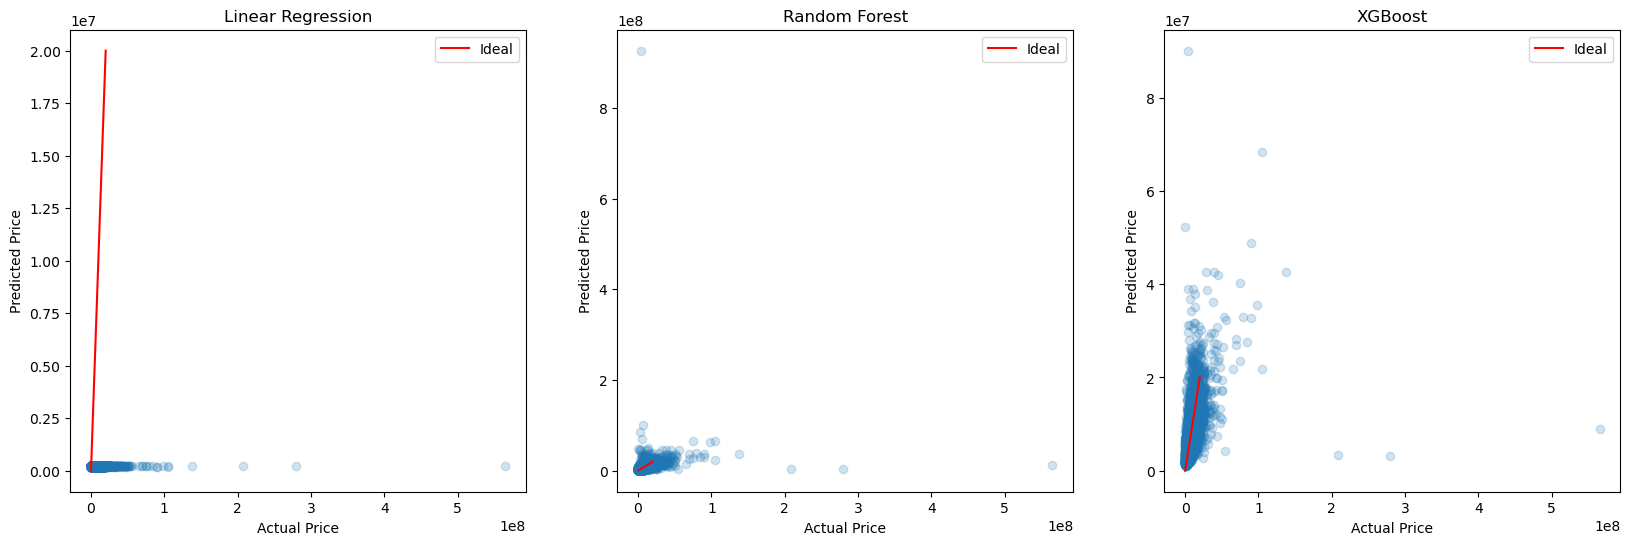

In [55]:
plt.figure(figsize=(20, 6))

# Linear Regression
plt.subplot(131)
plt.scatter(y_test, linreg_mae_test_preds, alpha=0.2)
plt.plot([0, 2e7], [0, 2e7], 'r', label='Ideal')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')
plt.legend()

# Random Forest
plt.subplot(132)
plt.scatter(y_test, rf_test_preds, alpha=0.2)
plt.plot([0, 2e7], [0, 2e7], 'r', label='Ideal')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest')
plt.legend()

# XGBoost
plt.subplot(133)
plt.scatter(y_test, xgb_test_preds, alpha=0.2)
plt.plot([0, 2e7], [0, 2e7], 'r', label='Ideal')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost')
plt.legend()

plt.show()